# ***Le météo:*** The use of Recurrent Neural Networks to explore climate prediction and uncover the caveats of machine learning

December 2020
<br>
_G. MEHAN, UCL Department of Physics and Astronomy_


### **CODE RESPOSITORY**
*Also available on GitHub at: https://github.com/MehanGaurav/*

The sections in this notebook are as follows: 

1. **Introduction the the repository**
2. **Loading the stations.txt dataset and choosing a station**
3. **Intial outlook of data and handling of missing data**
4. **Predicting the weather in October and November 2020 using data until September 2020**

  4**a**. **Predicting the Maximum (tmax) and Minimum (tmin) temperature with the use of a *feedback loop***

  4**b**. **Predicting the Maximum (tmax) and Minimum (tmin) temperature with the use of a *two months in advance***

  4**c**. **Predicting the Precipitation (prcp) with regards to its *probability of occurence***

5. **Predicting the weather a year in advance [as a weekly and monthly average]**
6. **Finding the hottest part of the world in 20 years time**


## 1. **Introduction to the repository -**

This notebook is a comprehensive set of code used in G. MEHANs 'Mini-Project' for Level 6 couse '_PHAS0056: Practical Machine Learning for Physicists_'. To read about the analysis please refer to the report attached to the GitHub profile linked above. 

The title brief for this project, found on Moodle, is as follows: '_Predicting the weather using historical data_'.

<br>

**Disclaimer:** All data used in this notebook has been taken from the _Global Historical Climatology Network_ or
GHCN; an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.

In [ ]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#import pandas for data processing
import pandas as pd
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

In [ ]:
#open and read the countries and stations file and plonk them into a dictionary
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


**Disclaimer:** Despite the much wider availability of stations within the _GCHN_, we have chosen only to incorporate data with a _GSN_ tag. In other words, stations associated with the _GCOS Surface Network_. 

This is to ensure high-quality of data from a  trusted, credible and accountable source. As you can see, this has limited the number of stations to extract data from to: $ 991 $. 

## 2. **Loading the stations.txt dataset and choosing a station -**

In [ ]:
#Gather and dump the list of stations into a dataframe from which we may be able to choose a station
def openStations():
  """ Calling this functions will collect, unpack and load the stations.txt file into a pandas dataframe (which it returns)
  """
  file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt') #open the file

  sid = [] #station id
  lat = [] #latitude
  lon = [] #longitude
  el = [] #elevation (m)
  state = [] #state - if applicable (US & CANADA)
  name = [] #name of station
  gsn = [] #gsn tag
  hcn = [] #hcn tag
  wmo = [] #wmo tag

  #for each line in the file, decode the data, and split the relevant information across the arrays
  for line in file:
    sid.append(line[0:11].decode('utf-8'))
    lat.append(line[12:20].decode('utf-8'))
    lon.append(line[21:30].decode('utf-8'))
    el.append(line[31:37].decode('utf-8'))
    state.append(line[38:40].decode('utf-8'))
    name.append(line[41:71].decode('utf-8'))
    gsn.append(line[72:75].decode('utf-8'))
    hcn.append(line[76:79].decode('utf-8'))
    wmo.append(line[80:85].decode('utf-8'))
  
  column_names = ['sid', 'lat', 'lon', 'el', 'state', 'name', 'gsn', 'hcn', 'wmo'] #column names for dataframe
  stations_array = np.transpose(np.array([sid, lat, lon, el, state, name, gsn, hcn, wmo])) #transpose the arrays for correct structuring 
  stations_df = pd.DataFrame(data = stations_array, columns = column_names) #collect the arrays and structure into ONE dataframe

  return stations_df

In [ ]:
stations_df = openStations() #read the stations file
stations_df.replace(r'^\s*$', np.nan, regex=True, inplace = True) #replace all blank values with 'NAN' for easier data analysis

**Disclaimer:** Even though we had already loaded the stations file into a dictionary the way we have defined it means every time we load a station, we also load its data. Now I just require the stations data and not its corresponding weather data. Hence why I have also defined a new function `openStations()` to achieve this in the most 'pythonic' way I can think off.

In [ ]:
stations_df.dropna(subset=['gsn'], inplace = True) #drop the stations not associated with GCOS
stations_df.head()

,sid,lat,lon,el,state,name,gsn,hcn,wmo
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196
6,AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930
10,AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390
11,AG000060590,30.5667,2.8667,397.0,NaN,EL-GOLEA,GSN,NaN,60590
12,AG000060611,28.0500,9.6331,561.0,NaN,IN-AMENAS,GSN,NaN,60611


In [ ]:
print('The number of stations available is: ', len(stations_df))

The number of stations available is:  991


In [ ]:
#correct the numerical parametrs into a float, rather than a string (as it remains currently)
def convert_List_to_Float(mylist):
  new_list = []
  for item in mylist:
      new_list.append(float(item))
  return new_list

**Disclaimer:** If you do not have _Basemap_ - a grpahical Matplotlib plotting package, then please run the following three lines seperately within the terminal: 

`!apt install proj-bin libproj-dev libgeos-dev`

`!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz`

`!sudo pip install -U git+https://github.com/matplotlib/basemap.git`

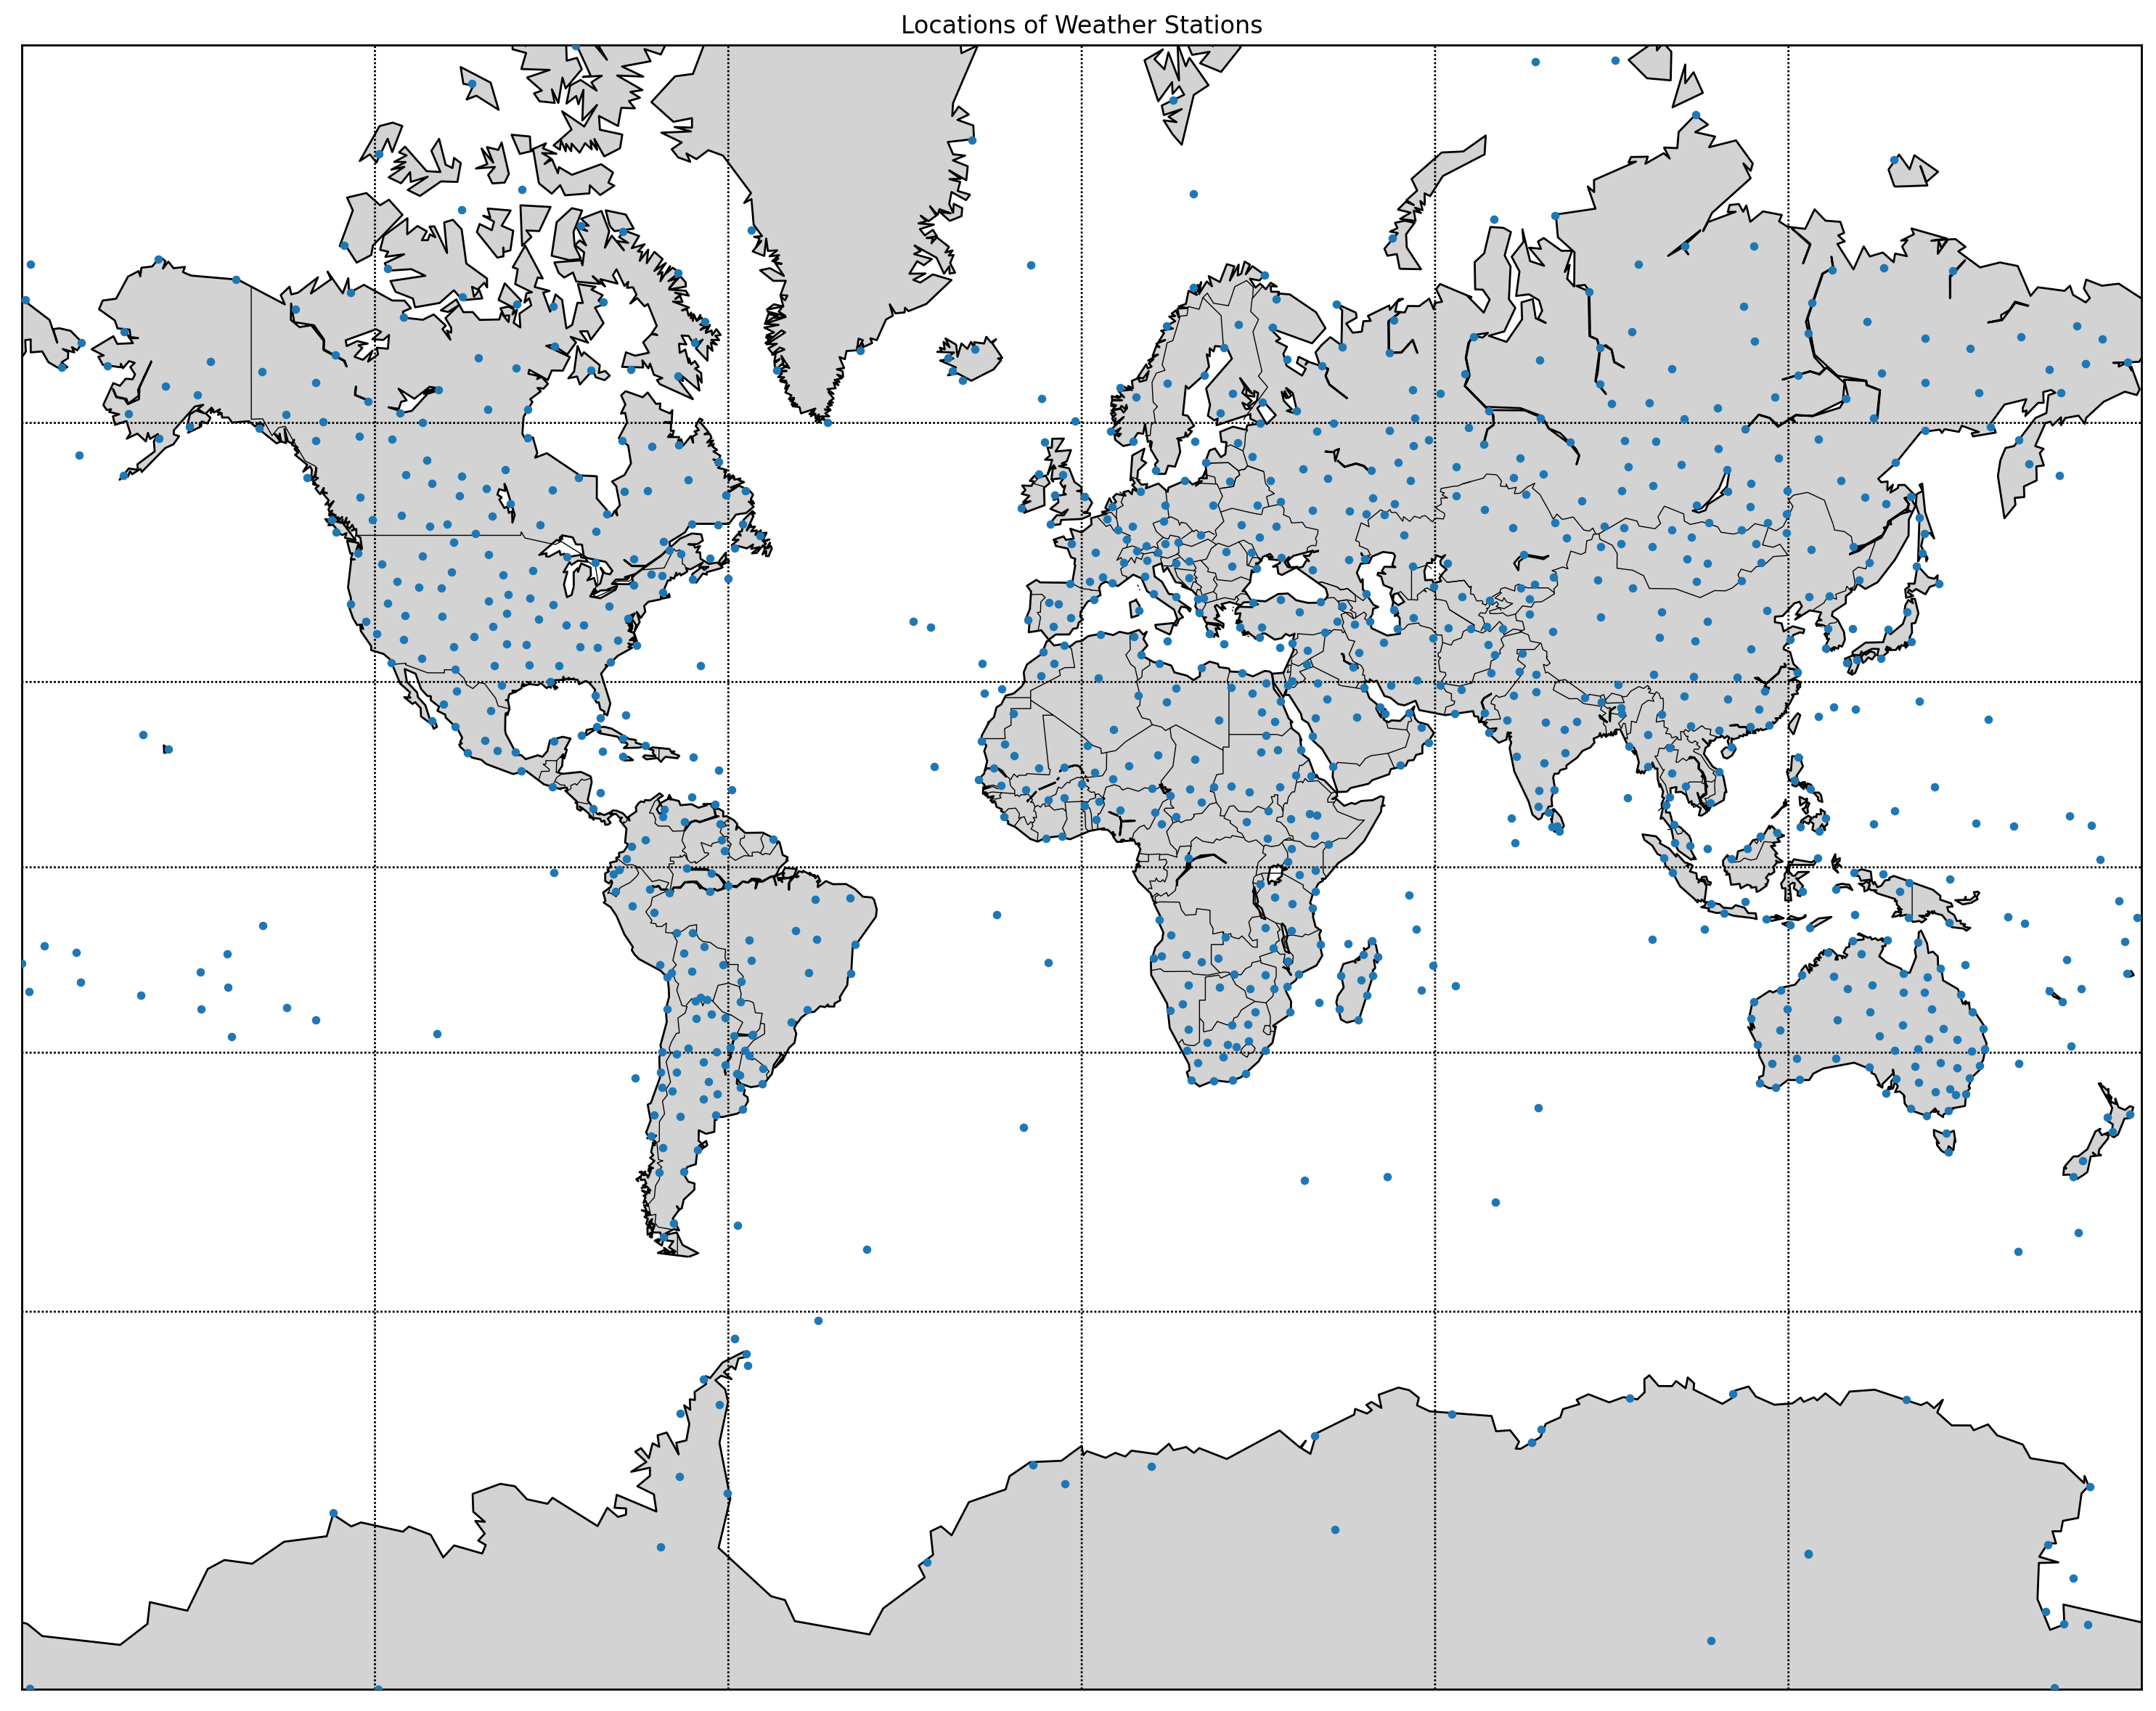

In [ ]:
#plot the available stations onto a global map for visual inspection
from mpl_toolkits.basemap import Basemap

#create a mercator projection
plt.figure(figsize=(30,15))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='lightgrey',lake_color='white', zorder = 1)

# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='white')
m.drawcountries()
plt.title("Locations of Weather Stations")

#convert the longtidues and latitudes into interprable float as right now they are strings with a lot of white space
longitude = convert_List_to_Float(stations_df['lon'].tolist())
latitude = convert_List_to_Float(stations_df['lat'].tolist())

#plot these locations as a point
x, y = m(longitude, latitude)
m.scatter(x, y, cmap= 'Blues', s = 10, zorder = 10)

plt.show()

**Note:** The reason for plotting the locations of each station is purely for outlook purposes and observe how the locations of each station has been chosen to be a part of the GSN network.

In [ ]:
#get rid of the unnecessary spaces in the 'names' field and replace with a string that can be searchable
new_name = stations_df['name'].str.strip()
stations_df.drop(['name'], axis=1, inplace = True) #delete the unhelpful, not properly formatted, names array

In [ ]:
stations_df.insert(5, "name", new_name, True) #insert the new much better names field that doesn't contain white space - this allows us to search through 
                                                #names if we require

**Disclaimer:** The data loaded from the GCHN contains a lot of white space when we load it into our code environment. Therefore for the name and latitude and longitude fields specifically, we get rid of this white space. So that we may search through names, and plot the locations of the stations (as done above) respectively. 

In [ ]:
#gather relevant attributes for station identification
names = stations_df['name'].tolist()
states = stations_df['state'].tolist()
sid = stations_df['sid'].tolist()

france_num = []
france_name = []

#return the first to letter of the station ID which corresponds to the country code
def first2(s):
    return s[:2]

#search for stations located in France
for i in range(0,len(names)):
  if first2(sid[i]) == 'FR':
    france_num.append(i)
    france_name.append(names[i])

print(france_name)
print(france_num)

['RENNES-ST JACQUES', 'STRASBOURG-ENTZHEIM', 'BOURGES', 'MONT-AIGOUAL', 'TOULOUSE-BLAGNAC', 'MARSEILLES-MARIGNANE', 'PORT-AUX-FRANCAIS (ILES KERGU']
[388, 389, 390, 391, 392, 393, 394]


In [ ]:
#Choose Toulouse-Blagnac Airport (Disclaimer: TLS is the IATA Airport code)
TLS = stations_df[stations_df['name'] == france_name[4]]
TLS_lat = float((TLS['lat'].tolist())[0])
TLS_lon = float((TLS['lon'].tolist())[0])
print(TLS)

               sid       lat        lon  ...  gsn  hcn    wmo
34082  FR000007630   43.6208     1.3789  ...  GSN  NaN  07630

[1 rows x 9 columns]


In [ ]:
#show a map of Toulouse-Blagnac Airport 

import folium
from folium import plugins
m = folium.Map(location=[43.635, 1.367778], zoom_start=14)

folium.Marker(location=[TLS_lat, TLS_lon], popup='LFBO Weather Station').add_to(m)

m  

# Disclaimer: 
# Please do not click on the map otherwise the whole thing will zoom in and out uncontrolablly.

## 3. **Intial Outlook of data and handling missing data -**

In [ ]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Construct and obtain the URL link
whichStat=france_num[4] #Toulouse-Blagnac Airport, France
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))

FR000007630 is TOULOUSE-BLAGNAC, France at 43.6208, 1.3789, 151.0


In [ ]:
#obtain the tmax and tmin for the station given
def getTemp(whichStat, graph):
  #minimum temperature
  tmaxArray=ghn.getVar(statDict,'TMAX')
  days, tmax = zip(*tmaxArray)
  #maximum temperature
  tminArray=ghn.getVar(statDict,'TMIN')
  days2, tmin = zip(*tminArray)
  print(len(days))
  
  if graph == True:

    #plot the data as a time series
    fig, ax = plt.subplots(2,1)
    plt.xticks(rotation=45)
    ax[0].plot(days,tmax,'.')
    ax[0].plot(days2,tmin,'.')
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("Temperature (C)")
    ax[0].set_title(ghn.getStation(statNames[whichStat]))
    ax[1].plot(days[-1000:],tmax[-1000:],'.', label = 'Maximum')
    ax[1].plot(days2[-1000:],tmin[-1000:],'.', label = 'Minimum')
    ax[1].set_xlabel("date")
    plt.legend(loc =  'best')
    ax[1].set_ylabel("Temperature (C)")

  return days, tmax, days2, tmin

In [ ]:
#obtain the prcp for the station given
def getPrec(whichStat, graph):
  #precipitation
  prcpArray=ghn.getVar(statDict,'PRCP')
  days3, prcp = zip(*prcpArray)

  if graph == True:
    #plot the data as a time series
    fig, ax = plt.subplots(2,1)
    plt.xticks(rotation=45)
    ax[0].plot(days3,prcp,'.')
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("Precipitation (mm)")
    ax[0].set_title(ghn.getStation(statNames[whichStat]))
    ax[1].plot(days3[-1000:],prcp[-1000:],'.')
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("Precipitation (mm)")

  return days3, prcp

26891


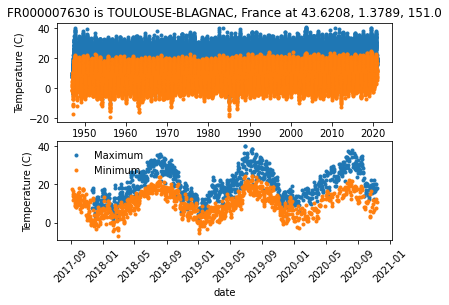

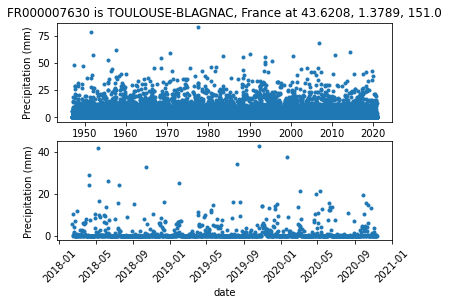

In [ ]:
graph = True
days, tmax, days2, tmin = getTemp(whichStat, graph) #call the function for obtaining tmax, tmin
days3, prcp = getPrec(whichStat, graph) #call the function for obtaining prcp

**Note:** I have specifically chosen a station with mostly complete data from a vast date range, and from a credible source, i.e. a major airport in South West France 

In [ ]:
from datetime import date, timedelta

#function that will fill in the missing dates from observations and fill in the measurement as 'NaN'
def fillDates(days, values):
  """ The fillDates functions takes in an array of dates and ensures that these dates are wholly complete in the dataset called values, it returns the filled
  in dataset as a pandas Series 
  """
  dates = pd.Index(days)
  s = pd.Series(values, dates)

  series = s.asfreq('D')

  return series

#function to ensure that all three datasets for tmax, tmin, and prcp span the same range of time series to enable grouping of data
def missingTimeSeries(timeseries1, timeseries2, timeseries3, dataset1, dataset2, dataset3):
  """ Takes in three timeseries (timeseries1, timeseries2, timeseries3) and the corresponding datasets (dataset1, dataset2, dataset3)
  and returns the three datasets with all matching date ranges (with the date_df also being returned) and missing values form missing days replacing
  missing days with NaN
  """
  #calculate the earliest date recorded for any measurement
  min_days = []
  min_days.append(min(timeseries1))
  min_days.append(min(timeseries2))
  min_days.append(min(timeseries3))
  print(min_days)
  min_date = min(min_days)
  print(min_date) 

  #calculate the latest date recorded for any measurement
  max_days = []
  max_days.append(max(timeseries1))
  max_days.append(max(timeseries2))
  max_days.append(max(timeseries3))
  print(max_days)
  max_date = max(max_days)
  print(max_date) 

  #create a DateTime index that spans this range
  date_df = pd.date_range(min_date,max_date-timedelta(days=0),freq='d')

  date_range = date_df.tolist()

  #fill these dates in where its missing from the three datasets
  dataset1 = fillDates(days, dataset1)
  dataset2 = fillDates(days2, dataset2)
  dataset3 = fillDates(days3, dataset3)

  return date_df, dataset1, dataset2, dataset3

In [ ]:
date_df, tmax, tmin, prcp = missingTimeSeries(days, days2, days3, tmax, tmin, prcp) #fill in the missing dates

assert len(tmax) == len(tmin) == len(prcp) == len(date_df) #ensure that datasets  span the same DateTime range

[datetime.date(1947, 1, 1), datetime.date(1947, 1, 1)]
1947-01-01
[datetime.date(2020, 11, 13), datetime.date(2020, 11, 13), datetime.date(2020, 11, 13)]
2020-11-13


In [ ]:
#convert the arrays into a pandas Series so that we may interpolate using the pandas function
TMAX = pd.Series(tmax)
TMIN = pd.Series(tmin)
PRCP = pd.Series(prcp)

#interpolate missing values with a linear fit
TMAX.interpolate(inplace=True)
TMIN.interpolate(inplace=True)
PRCP.interpolate(inplace=True)

**Note:** Given that gaps in our data are not that big (on the order of a few days), we may interpolate the values using the pandas function, linearly considering points either side. 

## 4. **Prediciting the weather in October and November 2020 using data up until Septmeber 2020 -**

In [ ]:
#delete data for October and November 2020 as we do not want to train or test with this data - as that would be cheating!
dates = date_df[:(len(date_df)-44)] #44 is the number of days between 01/10/2020 and the latest date available: 13/10/2020
tmax = TMAX[:(len(TMAX)-44)]

print(dates[-1]) #latest date available now - should be 30/09/2020
print(len(tmax)) #number of data we have now to train with

2020-09-30 00:00:00
26937


**Disclaimer:** For wholesome purposes, we delete the data from October and November 2020 as this is the range were interested in and don't want to train our model on it. I also round our data range quite nicely from 01/01/1947 to 30/09/2020.

### 1. **Predicting the Maximum (tmax) and Minimum (tmin) temperature with the use of a *feedback loop* -**

In [ ]:
#Function to convert a series with data values into a dataframe of n_ts values 
# with a target offset samples later
def make_timeseqs(series,n_ts,offset):
  """ This function takes in an array (series) and creates a time series from it using the windowsize (n_ts) anf offset
  """
    nn_df = pd.DataFrame()
    for i in range(n_ts):
        nn_df[i] = series.shift(n_ts-i) #Shift the data by n_ts-i samples
    nn_df['label'] = series.shift(-offset)
    return nn_df

#### 1. **tmax -**

In [ ]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler

# prepare data for normalization
values = np.array(TMAX)
values = values.reshape(-1, 1)
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

# normalize the dataset
normalized = scaler.transform(values)

# inverse transform 
inversed = scaler.inverse_transform(normalized)
tmax_df = pd.Series(data=normalized[:,0])

**Note:** Normalization is an important part of machine learning given that models perform best when data is normalized to the range 0 and 1, and generally follow a Gaussian distribution (as we shall see later for `prcp`). 

In [ ]:
from sklearn.model_selection import train_test_split

n_ts = 31 #number of timesamples
offset = 0 #how far into the future we want to predict

#create time series
nn_df=make_timeseqs(tmax_df,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

26950
(20212, 31, 1)


In [ ]:
#RNN model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(64,activation='relu'))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 31, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
203/203 [==============================] - 19s 55ms/step - loss: 0.0457 - val_loss: 0.0064
Epoch 2/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 3/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 4/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 5/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/100
203/203 [==============================] - 11s 52ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/100
203/203 [==============================] - 11s 54ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 10/100
203/203 [==============================] - 10s 51ms/step - l

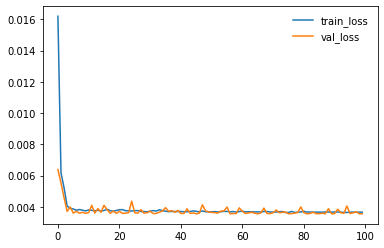

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for 30/09/2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 31 days from 01/10/2020 
                                      #since we want to predict 01/10/2020 initially

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

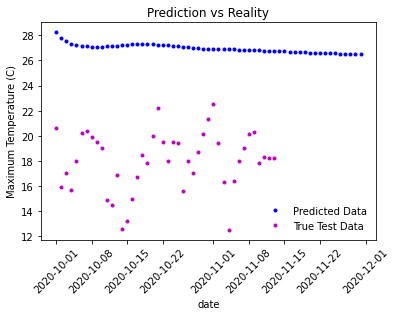

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,31+30-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions)

#create date range for our predcitions so we may plot it
OctNov = pd.date_range(date(2020, 10, 1),date(2020, 11, 30)-timedelta(days=0),freq='d')

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(OctNov, predictions,'b.',label="Predicted Data")
ax.plot(date_df[-44:],TMAX[-44:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Maximum Temperature (C)')
ax.legend()

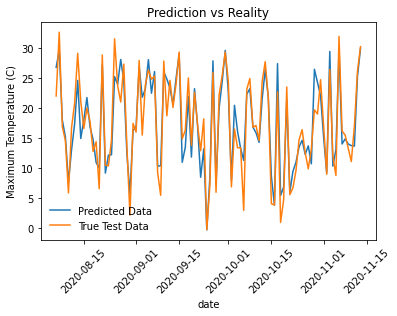

In [ ]:
#test on the past 100 days giving it the true data for the past 7 days for each prediction made - this is kind of cheating!
test_data=train_data[-100:]
test_label=train_label[-100:]

#make a prediction and inverse the values so that they are correctly scaled
test_predict=model.predict(test_data)
test_predict = test_predict.reshape(-1,1)
test_label = test_label.reshape(-1,1)
test_predict = scaler.inverse_transform(test_predict)
test_label = scaler.inverse_transform(test_label)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],test_predict,label="Predicted Data")
ax.plot(date_df[-100:],test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Maximum Temperature (C)')
ax.legend()

100
100


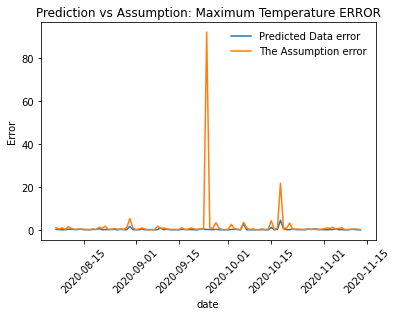

In [ ]:
#empty arrays for dumping error calculations
predict_error = []
sameWeather_error = []
nice_predict = []
nice_assumption = []

#for each prediction the model made, calculate the error
for i in range(0,len(test_predict)):
  predict = abs((test_predict[i]-test_label[i]))/test_label[i]
  predict_error.append(abs(predict))
  #if the error is more than 100% then don't add it to our array with error under 100% - so it doesn't mess with the scaling
  if predict < 1 and predict > 0:
    nice_predict.append(predict)

#calculate first error from our assumming statement
same = abs((train_label[-101]-test_label[0]))/test_label[0]
sameWeather_error.append(same)
#for each prediction the statement makes, calculate the error
for i in range(0,len(test_label)-1):
  same = abs((test_label[i]-test_label[i+1]))/test_label[i+1]
  sameWeather_error.append(abs(same))
  #if the error is more than 100% then don't add it to our array with error under 100% - so it doesn't mess with the scaling
  if same < 1 and same > 0:
    nice_assumption.append(same)

assert len(predict_error) == len(sameWeather_error)

#plot the errors of our predicted and our assumption that the weather today will be the same as yesterday
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],predict_error,label="Predicted Data error")
ax.plot(date_df[-100:],sameWeather_error,label="The Assumption error")
ax.set_title("Prediction vs Assumption: Maximum Temperature ERROR")
ax.set_xlabel("date")
ax.set_ylabel('Error')
ax.legend()

print(len(predict_error))
print(len(sameWeather_error))

95
84


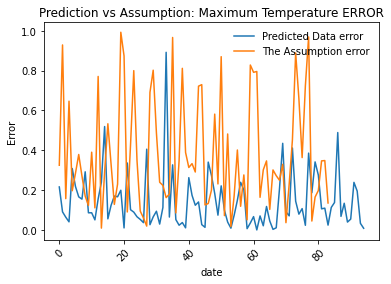

In [ ]:
#plot the errors of our predicted and our assumption that the weather today will be the same as yesterday
#but this this we discount errors above 100% so we can properly see the error made by most of the predictions
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(nice_predict,label="Predicted Data error")
ax.plot(nice_assumption,label="The Assumption error")
ax.set_title("Prediction vs Assumption: Maximum Temperature ERROR")
ax.set_xlabel("date")
ax.set_ylabel('Error')
ax.legend()

print(len(nice_predict))
print(len(nice_assumption))

**Note:** Above here, we have compared our model to the assumption - 
<br>
*The weather tomorrow will be exactly the same as today*
and shown the erros from both. I should point out that our model specifically requires the correct temperatures for the past 31 days (the windowsize) in order to make an accurate prediction so rather is the error given the correct data, and not the error given we can predict 100 days into the future (which is what we tried to do) [please read more in my report regarding this].

#### 2. **tmin -**

In [ ]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler

# prepare data for normalization
values = np.array(TMIN)
values = values.reshape(-1, 1)
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

# normalize the dataset
normalized = scaler.transform(values)

# inverse transform 
inversed = scaler.inverse_transform(normalized)
tmin_df = pd.Series(data=normalized[:,0])

In [ ]:
n_ts = 31 #number of timesamples
offset = 0 #how far into the future we want to predict

#create time series
nn_df=make_timeseqs(tmin_df,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

26950
(20212, 31, 1)


In [ ]:
#RNN model
model2=keras.models.Sequential()
model2.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model2.add(keras.layers.LSTM(64,activation='relu'))
model2.add(keras.layers.Dense(64,activation='relu'))
model2.add(keras.layers.Dense(32,activation='relu'))
model2.add(keras.layers.Dense(1,activation="linear"))
model2.compile(loss='mean_squared_error',optimizer='adam')
model2.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 31, 128)           66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model2.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
203/203 [==============================] - 12s 51ms/step - loss: 0.0518 - val_loss: 0.0069
Epoch 2/100
203/203 [==============================] - 10s 48ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 3/100
203/203 [==============================] - 10s 48ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 4/100
203/203 [==============================] - 10s 47ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 5/100
203/203 [==============================] - 10s 47ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 6/100
203/203 [==============================] - 10s 48ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 7/100
203/203 [==============================] - 10s 48ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/100
203/203 [==============================] - 10s 47ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/100
203/203 [==============================] - 10s 47ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/100
203/203 [==============================] - 10s 48ms/step - l

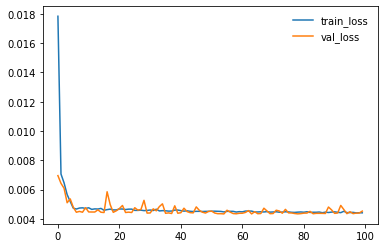

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for 30/09/2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 31 days from 01/10/2020 
                                      #since we want to predict 01/10/2020 initially

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

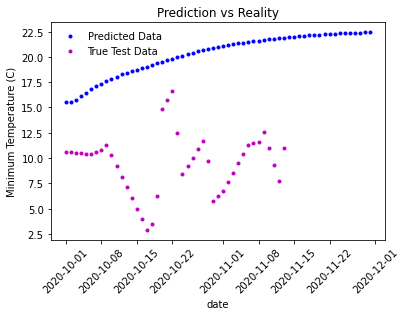

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model2.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,31+30-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model2.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions)

#create date range for our predcitions so we may plot it
OctNov = pd.date_range(date(2020, 10, 1),date(2020, 11, 30)-timedelta(days=0),freq='d')

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(OctNov, predictions,'b.',label="Predicted Data")
ax.plot(date_df[-44:],TMIN[-44:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Minimum Temperature (C)')
ax.legend()

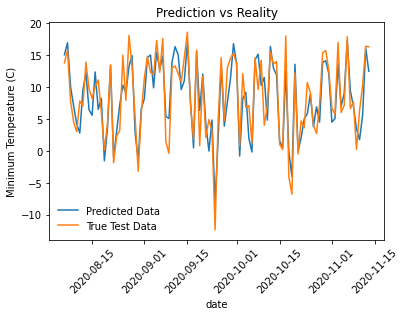

In [ ]:
#test on the past 100 days giving it the true data for the past 7 days for each prediction made - this is kind of cheating!
test_data=train_data[-100:]
test_label=train_label[-100:]

#make a prediction and inverse the values so that they are correctly scaled
test_predict=model.predict(test_data)
test_predict = test_predict.reshape(-1,1)
test_label = test_label.reshape(-1,1)
test_predict = scaler.inverse_transform(test_predict)
test_label = scaler.inverse_transform(test_label)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],test_predict,label="Predicted Data")
ax.plot(date_df[-100:],test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Minimum Temperature (C)')
ax.legend()

100
100


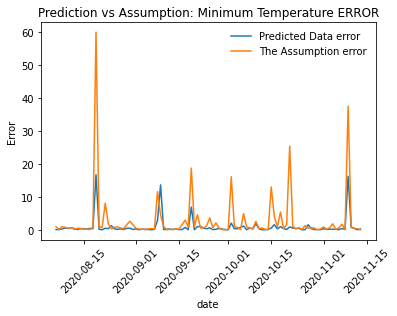

In [ ]:
#empty arrays for dumping error calculations
predict_error = []
sameWeather_error = []
nice_predict = []
nice_assumption = []

#for each prediction the model made, calculate the error
for i in range(0,len(test_predict)):
  predict = abs((test_predict[i]-test_label[i]))/test_label[i]
  predict_error.append(abs(predict))
  #if the error is more than 100% then don't add it to our array with error under 100% - so it doesn't mess with the scaling
  if predict < 1 and predict > 0:
    nice_predict.append(predict)

#calculate first error from our assumming statement
same = abs((train_label[-101]-test_label[0]))/test_label[0]
sameWeather_error.append(same)
#for each prediction the statement makes, calculate the error
for i in range(0,len(test_label)-1):
  same = abs((test_label[i]-test_label[i+1]))/test_label[i+1]
  sameWeather_error.append(abs(same))
  #if the error is more than 100% then don't add it to our array with error under 100% - so it doesn't mess with the scaling
  if same < 1 and same > 0:
    nice_assumption.append(same)

assert len(predict_error) == len(sameWeather_error)

#plot the errors of our predicted and our assumption that the weather today will be the same as yesterday
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],predict_error,label="Predicted Data error")
ax.plot(date_df[-100:],sameWeather_error,label="The Assumption error")
ax.set_title("Prediction vs Assumption: Minimum Temperature ERROR")
ax.set_xlabel("date")
ax.set_ylabel('Error')
ax.legend()

print(len(predict_error))
print(len(sameWeather_error))

82
68


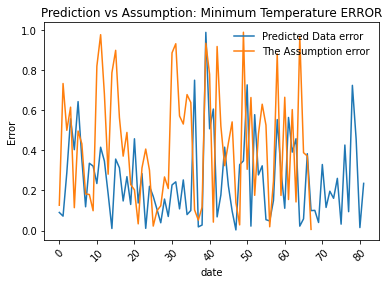

In [ ]:
#plot the errors of our predicted and our assumption that the weather today will be the same as yesterday
#but this this we discount errors above 100% so we can properly see the error made by most of the predictions
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(nice_predict,label="Predicted Data error")
ax.plot(nice_assumption,label="The Assumption error")
ax.set_title("Prediction vs Assumption: Minimum Temperature ERROR")
ax.set_xlabel("date")
ax.set_ylabel('Error')
ax.legend()

print(len(nice_predict))
print(len(nice_assumption))

### 2. **Predicting the Maximum (tmax) and Minimum (tmin) temperature *two months in advance* -**

**Note:** Here we try an alternative approach.

#### 1. **tmax -**

In [ ]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler

# prepare data for normalization
values = np.array(TMAX)
values = values.reshape(-1, 1)
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

# normalize the dataset
normalized = scaler.transform(values)

# inverse transform 
inversed = scaler.inverse_transform(normalized)
tmax_df = pd.Series(data=normalized[:,0])

In [ ]:
n_ts = 7 #number of timesamples
offset = 31+30 #how far into the future we want to predict

#create time series
nn_df=make_timeseqs(tmax_df,n_ts,offset)
test_df = nn_df[-offset:].drop('label',axis=1).values
nn_df.dropna(axis=0, inplace=True)


#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=(nn_df.drop('label',axis=1)).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

26913
(20184, 7, 1)


In [ ]:
#RNN model
model3=keras.models.Sequential()
model3.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model3.add(keras.layers.LSTM(64,activation='relu'))
model3.add(keras.layers.Dense(64,activation='relu'))
model3.add(keras.layers.Dense(32,activation='relu'))
model3.add(keras.layers.Dense(1,activation="linear"))
model3.compile(loss='mean_squared_error',optimizer='adam')
model3.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 128)            66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model3.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
202/202 [==============================] - 6s 19ms/step - loss: 0.0831 - val_loss: 0.0215
Epoch 2/100
202/202 [==============================] - 3s 16ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 3/100
202/202 [==============================] - 3s 16ms/step - loss: 0.0214 - val_loss: 0.0214
Epoch 4/100
202/202 [==============================] - 3s 16ms/step - loss: 0.0212 - val_loss: 0.0214
Epoch 5/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0218 - val_loss: 0.0214
Epoch 6/100
202/202 [==============================] - 3s 16ms/step - loss: 0.0213 - val_loss: 0.0215
Epoch 7/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0213 - val_loss: 0.0226
Epoch 8/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0213 - val_loss: 0.0213
Epoch 9/100
202/202 [==============================] - 3s 16ms/step - loss: 0.0210 - val_loss: 0.0212
Epoch 10/100
202/202 [==============================] - 3s 15ms/step - loss: 0.020

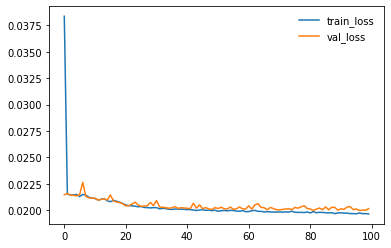

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

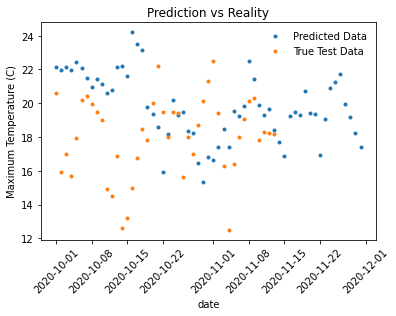

In [ ]:
#make a prediction and inverse the values so that they are correctly scaled
test_data=test_df.reshape(-1,n_ts,1)
test_predict=model3.predict(test_data)
test_predict = test_predict.reshape(-1,1)
test_predict = scaler.inverse_transform(test_predict)


#create date range for our predcitions so we may plot it
OctNov = pd.date_range(date(2020, 10, 1),date(2020, 11, 30)-timedelta(days=0),freq='d')

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(OctNov, test_predict, '.',label="Predicted Data")
ax.plot(date_df[-44:], TMAX[-44:].values,'.',label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Maximum Temperature (C)')
ax.legend()

#### 2. **tmin -**

In [ ]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler

# prepare data for normalization
values = np.array(TMIN)
values = values.reshape(-1, 1)
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

# normalize the dataset
normalized = scaler.transform(values)

# inverse transform 
inversed = scaler.inverse_transform(normalized)
tmin_df = pd.Series(data=normalized[:,0])

In [ ]:
n_ts = 7 #number of timesamples
offset = 31+30 #how far into the future we want to predict

#create time series
nn_df=make_timeseqs(tmin_df,n_ts,offset)
test_df = nn_df[-offset:].drop('label',axis=1).values
nn_df.dropna(axis=0, inplace=True)


#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=(nn_df.drop('label',axis=1)).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

26913
(20184, 7, 1)


In [ ]:
#RNN model
model4=keras.models.Sequential()
model4.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model4.add(keras.layers.LSTM(64,activation='relu'))
model4.add(keras.layers.Dense(64,activation='relu'))
model4.add(keras.layers.Dense(32,activation='relu'))
model4.add(keras.layers.Dense(1,activation="linear"))
model4.compile(loss='mean_squared_error',optimizer='adam')
model4.summary() 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 7, 128)            66560     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model4.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
202/202 [==============================] - 5s 17ms/step - loss: 0.0948 - val_loss: 0.0184
Epoch 2/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 3/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 4/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 5/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 6/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 7/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 8/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 9/100
202/202 [==============================] - 3s 15ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 10/100
202/202 [==============================] - 3s 15ms/step - loss: 0.018

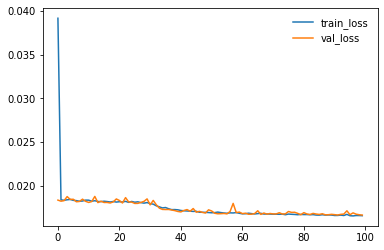

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

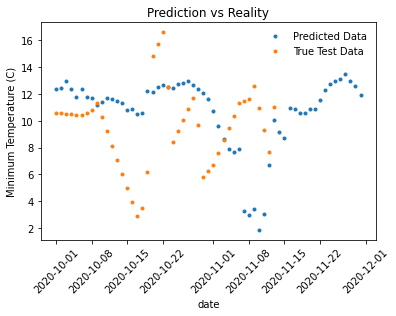

In [ ]:
#make a prediction and inverse the values so that they are correctly scaled
test_data=test_df.reshape(-1,n_ts,1)
test_predict=model4.predict(test_data)
test_predict = test_predict.reshape(-1,1)
test_predict = scaler.inverse_transform(test_predict)


#create date range for our predcitions so we may plot it
OctNov = pd.date_range(date(2020, 10, 1),date(2020, 11, 30)-timedelta(days=0),freq='d')

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(OctNov, test_predict, '.',label="Predicted Data")
ax.plot(date_df[-44:], TMIN[-44:].values,'.',label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Minimum Temperature (C)')
ax.legend()

### 2. **Predicting the Precipitation (prcp) with regards to its *probability of occurence* -**

In [ ]:
from sklearn import preprocessing

#noramlize data into binary, i.e. either 1s or 0s
def Binary(dataset):
  """ Takes in a dataset and normalizes all data into either 0 or 1, return a pandas Series of the new normalized dataset
  """
  dataset = np.array(dataset).reshape(-1,1)
  normalized = preprocessing.normalize(dataset)
  normalized_df = pd.Series(normalized[:,0])
  return normalized_df

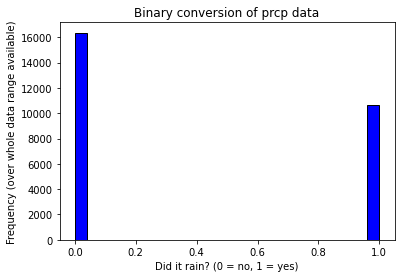

In [ ]:
#convert our prcp data into binary
prcp_df = Binary(PRCP)

#plot a histogram to show the probability of occurence
plt.figure()
plt.hist(prcp_df,bins=25, color = 'b', edgecolor='k')
plt.xlabel('Did it rain? (0 = no, 1 = yes)')
plt.ylabel('Frequency (over whole data range available)')
plt.title('Binary conversion of prcp data')
plt.show()

In [ ]:
n_ts = 31 #number of timesamples
offset = 0 #how far into the future we want to predict

#create time series
nn_df=make_timeseqs(prcp_df,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

26950
(20212, 31, 1)


In [ ]:
#RNN model
model5=keras.models.Sequential()
model5.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model5.add(keras.layers.LSTM(64,activation='relu'))
model5.add(keras.layers.Dense(64,activation='relu'))
model5.add(keras.layers.Dense(32,activation='relu'))
model5.add(keras.layers.Dense(1,activation="sigmoid"))
model5.compile(loss='binary_crossentropy',optimizer='adam')
model5.summary() 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 31, 128)           66560     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model5.fit(train_data,train_label,epochs=50,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/50
203/203 [==============================] - 13s 53ms/step - loss: 0.6620 - val_loss: 0.6109
Epoch 2/50
203/203 [==============================] - 10s 49ms/step - loss: 0.6173 - val_loss: 0.6025
Epoch 3/50
203/203 [==============================] - 10s 50ms/step - loss: 0.6145 - val_loss: 0.6036
Epoch 4/50
203/203 [==============================] - 10s 51ms/step - loss: 0.6092 - val_loss: 0.6049
Epoch 5/50
203/203 [==============================] - 10s 48ms/step - loss: 0.6111 - val_loss: 0.6045
Epoch 6/50
203/203 [==============================] - 10s 49ms/step - loss: 0.6135 - val_loss: 0.6032
Epoch 7/50
203/203 [==============================] - 10s 51ms/step - loss: 0.6192 - val_loss: 0.6030
Epoch 8/50
203/203 [==============================] - 10s 49ms/step - loss: 0.6080 - val_loss: 0.6033
Epoch 9/50
203/203 [==============================] - 10s 50ms/step - loss: 0.6104 - val_loss: 0.6034
Epoch 10/50
203/203 [==============================] - 10s 50ms/step - loss: 0.614

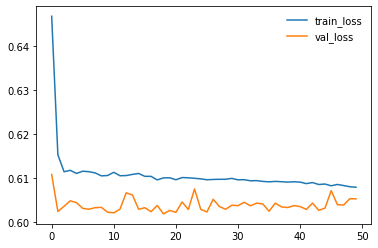

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for 30/09/2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 31 days from 01/10/2020 
                                      #since we want to predict 01/10/2020 initially

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

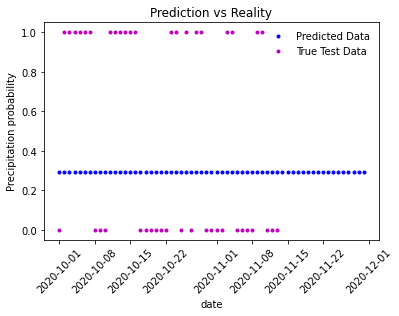

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model5.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,31+30-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model5.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

predictions = np.array(predictions)
                       
#create date range for our predcitions so we may plot it
OctNov = pd.date_range(date(2020, 10, 1),date(2020, 11, 30)-timedelta(days=0),freq='d')

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(OctNov, predictions[:,0,0],'b.',label="Predicted Data")
ax.plot(date_df[-44:],prcp_df[-44:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Precipitation probability')
ax.legend()

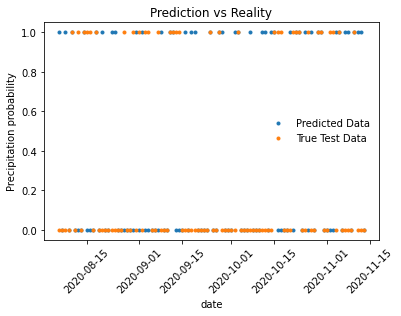

In [ ]:
#test on the past 100 days giving it the true data for the past 7 days for each prediction made - this is kind of cheating!
test_data=train_data[-100:]
test_label=train_label[-100:]

#make a prediction and inverse the values so that they are correctly scaled
test_predict=model.predict(test_data)
test_predict = test_predict.reshape(-1,1)
test_label = test_label.reshape(-1,1)
#test_predict = scaler.inverse_transform(test_predict)
#test_label = scaler.inverse_transform(test_label)

#convert our probabilities into either 0 or 1s
new_test_predict = []
for i in range(0,len(test_predict)):
  if test_predict[i] > 0.5:
    new_test_predict.append(1)
  else:
    new_test_predict.append(0)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],new_test_predict, '.', label="Predicted Data")
ax.plot(date_df[-100:],test_label,'.',label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel('Precipitation probability')
ax.legend()

100
100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


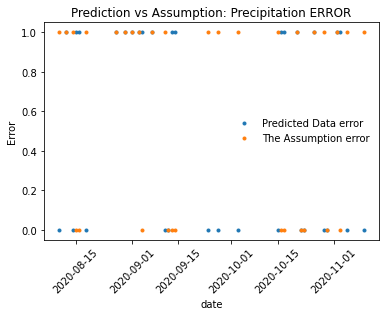

In [ ]:
#empty arrays for dumping error calculations
predict_error = []
sameWeather_error = []

#for each prediction the model made, calculate the error
for i in range(0,len(new_test_predict)):
  predict = abs((new_test_predict[i]-test_label[i]))/test_label[i]
  predict_error.append(abs(predict))

#calculate first error from our assumming statement
same = abs((train_label[-101]-test_label[0]))/test_label[0]
sameWeather_error.append(same)
#for each prediction the statement makes, calculate the error
for i in range(0,len(test_label)-1):
  same = abs((test_label[i]-test_label[i+1]))/test_label[i+1]
  sameWeather_error.append(abs(same))

assert len(predict_error) == len(sameWeather_error)

#plot the errors of our predicted and our assumption that the weather today will be the same as yesterday
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(date_df[-100:],predict_error,'.',label="Predicted Data error")
ax.plot(date_df[-100:],sameWeather_error,'.',label="The Assumption error")
ax.set_title("Prediction vs Assumption: Precipitation ERROR")
ax.set_xlabel("date")
ax.set_ylabel('Error')
ax.legend()

print(len(predict_error))
print(len(sameWeather_error))

## 5. **Prediciting the weather in a year in advance... -**

### 1. **as a weekly average -**

**Disclaimer:** We discount this *weekly average* invesigation from our report given that it performs badly. The *monthly average* on the other hand performs much better ** **Spoiler Alert** **

#### 1. **tmax -**

In [ ]:
#delete data least recent so that all data can be grouped into 7 days
print(len(TMAX) % 7)

tmax_weekly = TMAX[-(len(TMAX)-(len(TMAX)%7)):]

print(len(tmax_weekly) % 7)

3
0


In [ ]:
#calculate the average tmax for each of these weekly groups
tmax_avg = []
j = 0
k = 6
for i in range(0,int(len(tmax_weekly)/7)):
  array = np.array(tmax_weekly[j:k])
  sum = np.sum(array)
  mean = sum/len(array)
  tmax_avg.append(mean)

  j = j + 7
  k = k + 7

In [ ]:
print(tmax_avg[-5:])
print(len(tmax_avg))

[15.183333333333335, 19.122222222222224, 18.033333333333335, 18.066666666666666, 18.966666666666665]
3854


In [ ]:
n_ts = 12 #number of timesamples
offset = 0 #how far into the future we want to predict

tmax_avg = pd.Series(tmax_avg)

#create time series
nn_df=make_timeseqs(tmax_avg,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

3842
(2881, 12, 1)


In [ ]:
#RNN model
model6=keras.models.Sequential()
model6.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model6.add(keras.layers.LSTM(64,activation='relu'))
model6.add(keras.layers.Dense(64,activation='relu'))
model6.add(keras.layers.Dense(32,activation='relu'))
model6.add(keras.layers.Dense(1,activation="linear"))
model6.compile(loss='mean_squared_error',optimizer='adam')
model6.summary() 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 12, 128)           66560     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model6.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
29/29 [==============================] - 3s 38ms/step - loss: 228.3492 - val_loss: 32.6759
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 29.1685 - val_loss: 14.5897
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 13.3556 - val_loss: 10.4067
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 11.0791 - val_loss: 10.4973
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 10.4223 - val_loss: 9.4432
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 11.2870 - val_loss: 11.5456
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 11.0522 - val_loss: 9.7021
Epoch 8/100
29/29 [==============================] - 1s 22ms/step - loss: 9.7644 - val_loss: 9.6628
Epoch 9/100
29/29 [==============================] - 1s 22ms/step - loss: 10.3226 - val_loss: 9.2074
Epoch 10/100
29/29 [==============================] - 1s 22ms/step - loss: 10.1929 - v

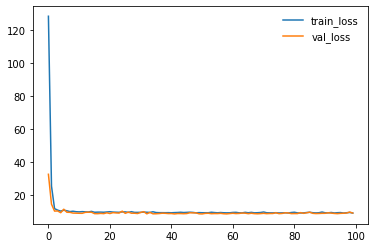

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for September 2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 12 weeks behind September 2020

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

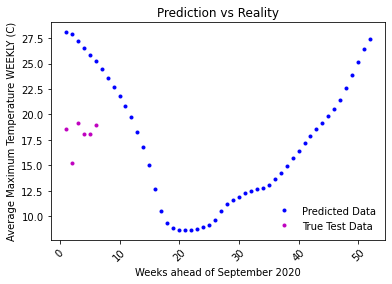

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model6.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,52-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model6.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
#predictions = scaler.inverse_transform(predictions)

#create date range for our predcitions so we may plot it
NextYearWeekly = np.linspace(1,52,52)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(NextYearWeekly, predictions,'b.',label="Predicted Data")
ax.plot(NextYearWeekly[:6],tmax_avg[-6:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Weeks ahead of September 2020")
ax.set_ylabel('Average Maximum Temperature WEEKLY (C)')
ax.legend()

#### 2. **tmin -**

In [ ]:
#delete data least recently so that all data can be grouped into 7 days
tmin_weekly = TMIN[-(len(TMIN)-(len(TMIN)%7)):]

#calculate the average tmax for each of these weekly groups
tmin_avg = []
j = 0
k = 6
for i in range(0,int(len(tmin_weekly)/7)):
  array = np.array(tmin_weekly[j:k])
  sum = np.sum(array)
  mean = sum/len(array)
  tmin_avg.append(mean)

  j = j + 7
  k = k + 7

In [ ]:
n_ts = 12 #number of timesamples
offset = 0 #how far into the future we want to predict

tmin_avg = pd.Series(tmin_avg)

#create time series
nn_df=make_timeseqs(tmin_avg,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

3842
(2881, 12, 1)


In [ ]:
#RNN model
model7=keras.models.Sequential()
model7.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model7.add(keras.layers.LSTM(64,activation='relu'))
model7.add(keras.layers.Dense(64,activation='relu'))
model7.add(keras.layers.Dense(32,activation='relu'))
model7.add(keras.layers.Dense(1,activation="linear"))
model7.compile(loss='mean_squared_error',optimizer='adam')
model7.summary() 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 12, 128)           66560     
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model7.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
29/29 [==============================] - 3s 37ms/step - loss: 69.2042 - val_loss: 19.3040
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 15.4289 - val_loss: 8.7564
Epoch 3/100
29/29 [==============================] - 1s 23ms/step - loss: 8.0821 - val_loss: 7.4525
Epoch 4/100
29/29 [==============================] - 1s 22ms/step - loss: 8.2197 - val_loss: 7.2704
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 8.0651 - val_loss: 7.3959
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 7.8570 - val_loss: 7.2681
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 7.8020 - val_loss: 7.2572
Epoch 8/100
29/29 [==============================] - 1s 23ms/step - loss: 7.5592 - val_loss: 6.9758
Epoch 9/100
29/29 [==============================] - 1s 24ms/step - loss: 7.6729 - val_loss: 6.7315
Epoch 10/100
29/29 [==============================] - 1s 22ms/step - loss: 7.2802 - val_loss: 6.8

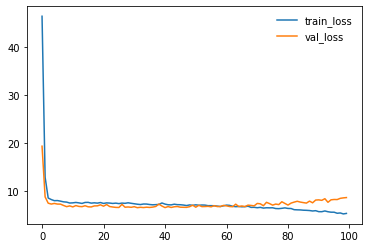

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for September 2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 12 weeks behind September 2020

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

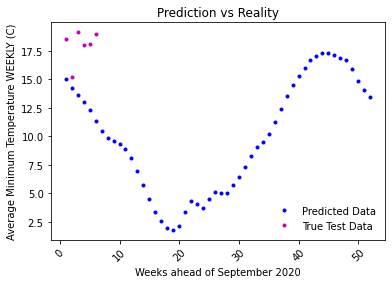

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model7.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,52-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model7.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
#predictions = scaler.inverse_transform(predictions)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(NextYearWeekly, predictions,'b.',label="Predicted Data")
ax.plot(NextYearWeekly[:6],tmax_avg[-6:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Weeks ahead of September 2020")
ax.set_ylabel('Average Minimum Temperature WEEKLY (C)')
ax.legend()

### 2. **as a monthly average -**

#### 1. **tmax -**

In [ ]:
#delete data least recent so that all data can be grouped into 31 days
print(len(TMAX) % 31)

tmax_monthly = TMAX[-(len(TMAX)-(len(TMAX)%31)):]

print(len(tmax_monthly) % 31)

11
0


In [ ]:
#calculate the average tmax for each of these monthly groups
tmax_avg = []
j = 0
k = 30
for i in range(0,int(len(tmax_monthly)/31)):
  array = np.array(tmax_monthly[j:k])
  sum = np.sum(array)
  mean = sum/len(array)
  tmax_avg.append(mean)

  j = j + 31
  k = k + 31

In [ ]:
n_ts = 6 #number of timesamples
offset = 0 #how far into the future we want to predict

tmax_avg = pd.Series(tmax_avg)

#create time series
nn_df=make_timeseqs(tmax_avg,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

864
(648, 6, 1)


In [ ]:
#RNN model
model8=keras.models.Sequential()
model8.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model8.add(keras.layers.LSTM(64,activation='relu'))
model8.add(keras.layers.Dense(64,activation='relu'))
model8.add(keras.layers.Dense(32,activation='relu'))
model8.add(keras.layers.Dense(1,activation="linear"))
model8.compile(loss='mean_squared_error',optimizer='adam')
model8.summary() 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 6, 128)            66560     
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model8.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
7/7 [==============================] - 3s 138ms/step - loss: 371.7868 - val_loss: 314.6537
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 282.3185 - val_loss: 82.5511
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 95.5670 - val_loss: 54.8315
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 62.7703 - val_loss: 57.9151
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 58.5033 - val_loss: 51.2688
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 51.6441 - val_loss: 42.9219
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 46.7256 - val_loss: 39.5205
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 39.7474 - val_loss: 35.6053
Epoch 9/100
7/7 [==============================] - 0s 17ms/step - loss: 34.9016 - val_loss: 30.2110
Epoch 10/100
7/7 [==============================] - 0s 17ms/step - loss: 27.6021 - val_loss: 23.

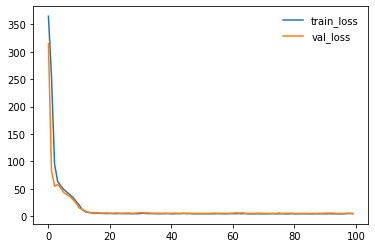

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for September 2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 6 months behind September 2020

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

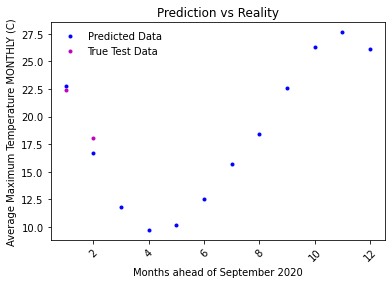

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model8.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,12-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model8.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
#predictions = scaler.inverse_transform(predictions)

#dates for next year 
NextYearMonthly = np.linspace(1,12,12)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(NextYearMonthly, predictions,'b.',label="Predicted Data")
ax.plot(NextYearMonthly[:2],tmax_avg[-2:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Months ahead of September 2020")
ax.set_ylabel('Average Maximum Temperature MONTHLY (C)')
ax.legend()

#### 2. **tmin -**

In [ ]:
#delete data least recently so that all data can be grouped into 31 days
tmin_monthly = TMIN[-(len(TMIN)-(len(TMIN)%31)):]

#calculate the average tmin for each of these monthly groups
tmin_avg = []
j = 0
k = 30
for i in range(0,int(len(tmin_monthly)/31)):
  array = np.array(tmin_monthly[j:k])
  sum = np.sum(array)
  mean = sum/len(array)
  tmin_avg.append(mean)

  j = j + 31
  k = k + 31

In [ ]:
n_ts = 6 #number of timesamples
offset = 0 #how far into the future we want to predict

tmin_avg = pd.Series(tmin_avg)

#create time series
nn_df=make_timeseqs(tmin_avg,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

864
(648, 6, 1)


In [ ]:
#RNN model
model9=keras.models.Sequential()
model9.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model9.add(keras.layers.LSTM(64,activation='relu'))
model9.add(keras.layers.Dense(64,activation='relu'))
model9.add(keras.layers.Dense(32,activation='relu'))
model9.add(keras.layers.Dense(1,activation="linear"))
model9.compile(loss='mean_squared_error',optimizer='adam')
model9.summary() 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 6, 128)            66560     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model9.fit(train_data,train_label,epochs=100,batch_size=100,verbose=1,validation_data=(val_data,val_label))

Epoch 1/100
7/7 [==============================] - 3s 86ms/step - loss: 105.8113 - val_loss: 94.5140
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 93.5287 - val_loss: 69.5057
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 68.5219 - val_loss: 51.5635
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 51.8223 - val_loss: 38.9421
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 38.1664 - val_loss: 30.1037
Epoch 6/100
7/7 [==============================] - 0s 18ms/step - loss: 28.1523 - val_loss: 21.1261
Epoch 7/100
7/7 [==============================] - 0s 18ms/step - loss: 18.0429 - val_loss: 10.7869
Epoch 8/100
7/7 [==============================] - 0s 18ms/step - loss: 7.9540 - val_loss: 5.9902
Epoch 9/100
7/7 [==============================] - 0s 17ms/step - loss: 5.0697 - val_loss: 5.1576
Epoch 10/100
7/7 [==============================] - 0s 17ms/step - loss: 4.6822 - val_loss: 4.5156
Epoc

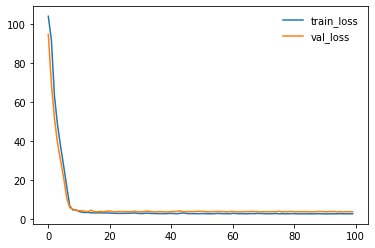

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
test_data = train_data[-1] #obtain the last element of the train dataset as this is what we will feed into our network intially
test_data = np.append(test_data, train_label[-1]) #add the final piece of the test dataset which is the data for September 2020
test_data = np.delete(test_data, 0) #delete the first element of the list to ensure our test set is the data for past 6 months behind September 2020

assert len(test_data) == n_ts #ensure that the length of the test dataset is the the same as the model is designed to handle having been trained

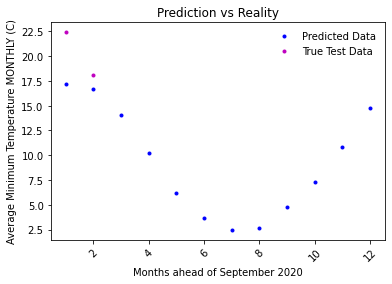

In [ ]:
#reshape the test dataset into correct format for Tensor to handle and predict the next day
test_data=test_data.reshape(-1,n_ts,1)
test_predict = model9.predict(test_data)

#now feed this prediction into the model again to predict the next day and so forth
predictions = []
predictions.append(test_predict)
for i in range(0,12-1): 
  #add our prediction to the list and delete the first element to keep n_ts the same
  test_data = np.append(test_data, test_predict)
  test_data = np.delete(test_data, 0)
  
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test_data=test_data.reshape(-1,n_ts,1)
  test_predict = model9.predict(test_data)

  #add the prediction to our list
  predictions.append(test_predict)

#inverse the normalisation of the temperature values
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)
#predictions = scaler.inverse_transform(predictions)

#dates for next year
NextYearMonthly = np.linspace(1,12,12)

#plot the prediction and true values
fig,ax=plt.subplots()
plt.xticks(rotation=45)
ax.plot(NextYearMonthly, predictions,'b.',label="Predicted Data")
ax.plot(NextYearMonthly[:2],tmax_avg[-2:].values, 'm.',label= 'True Test Data')
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Months ahead of September 2020")
ax.set_ylabel('Average Minimum Temperature MONTHLY (C)')
ax.legend()

## 6. **Finding the hottest part of the world in 20 years time -**

In [ ]:
#delete data least recently so that all data can be grouped into 365 days
print(len(tmax) % 365)

tmax_yearly = TMAX[-(len(TMAX)-(len(TMAX)%365)):]

print(len(tmax_yearly) % 365)

292
0


In [ ]:
#calculate the maximum tmax for each of these yearly groups
tmax_max = []
j = 0
k = 364
for i in range(0,int(len(tmax_yearly)/365)):
  array = np.array(tmax_yearly[j:k])
  maximum_temp = 0
  for l in range(0, len(array)):
    if array[l] > maximum_temp:
      maximum_temp = array[l]
  tmax_max.append(maximum_temp)

  j = j + 365
  k = k + 365

print(len(tmax_max))

73


Text(0.5, 1.0, 'FR000007630 is TOULOUSE-BLAGNAC, France at 43.6208, 1.3789, 151.0')

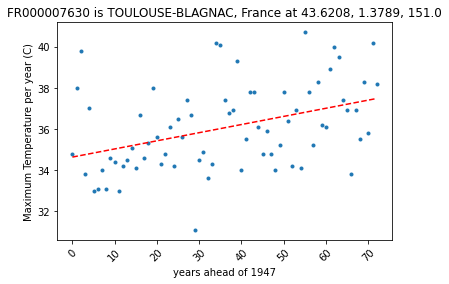

In [ ]:
#plot the average yearly temperature for TLS
fig, ax = plt.subplots()
plt.xticks(rotation=45)
ax.plot(tmax_max,'.')

#fit a straight line so we may observe the trends
x = np.linspace(0,len(tmax_max)-1, len(tmax_max))
z = np.polyfit(x, tmax_max, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

ax.set_xlabel("years ahead of 1947")
ax.set_ylabel("Maximum Temperature per year (C)")
ax.set_title(ghn.getStation(statNames[whichStat]))

In [ ]:
n_ts = 5 #number of timesamples
offset = 0 #how far into the future we want to predict

tmax_max = pd.Series(tmax_max)
#create time series
nn_df=make_timeseqs(tmax_max,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)

#obtain train data and label and reshape for Tensor to handle
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
train_data=train_data.reshape(-1,n_ts,1)

#correctly format data for Tensor to handle
train_data=np.asarray(train_data).astype(np.float32)
train_label=np.asarray(train_label).astype(np.float32)

print(len(train_data))

#split the train into train and validation
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape) 

68
(51, 5, 1)


In [ ]:
#RNN model
model10=keras.models.Sequential()
model10.add(keras.layers.LSTM(128,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model10.add(keras.layers.LSTM(64,activation='relu'))
model10.add(keras.layers.Dense(64,activation='relu'))
model10.add(keras.layers.Dense(32,activation='relu'))
model10.add(keras.layers.Dense(1,activation="linear"))
model10.compile(loss='mean_squared_error',optimizer='adam')
model10.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
history=model10.fit(train_data,train_label,epochs=500,batch_size=5,verbose=1,validation_data=(val_data,val_label))

Epoch 1/500
11/11 [==============================] - 5s 77ms/step - loss: 1293.5996 - val_loss: 1254.5006
Epoch 2/500
11/11 [==============================] - 0s 16ms/step - loss: 1109.2557 - val_loss: 421.8416
Epoch 3/500
11/11 [==============================] - 0s 16ms/step - loss: 188.4309 - val_loss: 6.5360
Epoch 4/500
11/11 [==============================] - 0s 15ms/step - loss: 25.4563 - val_loss: 31.7342
Epoch 5/500
11/11 [==============================] - 0s 29ms/step - loss: 21.7676 - val_loss: 5.4495
Epoch 6/500
11/11 [==============================] - 0s 18ms/step - loss: 9.5143 - val_loss: 8.1516
Epoch 7/500
11/11 [==============================] - 0s 18ms/step - loss: 7.6479 - val_loss: 3.6379
Epoch 8/500
11/11 [==============================] - 0s 17ms/step - loss: 5.5424 - val_loss: 6.2747
Epoch 9/500
11/11 [==============================] - 0s 16ms/step - loss: 5.2039 - val_loss: 3.4472
Epoch 10/500
11/11 [==============================] - 0s 16ms/step - loss: 5.5794 - 

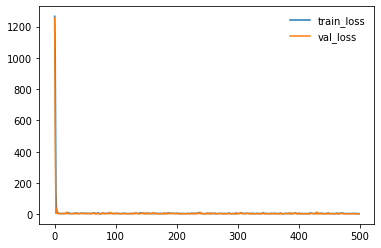

In [ ]:
#plot the loss
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

In [ ]:
#arrays for dumping data into
maxTemps_all = []
graph = False
whichStation = []

from tqdm import tqdm

#for each station...
for i in tqdm(range(0, len(stations_df))):
  try:
    #... load the data...
    whichStat=i #Toulouse-Blagnac Airport, France
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    # Copy a network object to a local file
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    print(ghn.getStation(statNames[whichStat]))
  
    days, tmax, days2, tmin = getTemp(whichStat, graph) #call the function for obtaining tmax, tmin

    #index data so we only get the last 5 years worth of data (as our windowsize is 5)
    tmax_yearly = tmax[-(365*5):]
    #...calculate the maximum tmax for each of these yearly groups...
    tmax_max = []
    j = 0
    k = 364
    for m in range(0,int(len(tmax_yearly)/365)):
      array = np.array(tmax_yearly[j:k])
      maximum_temp = 0
      for l in range(0, len(array)):
        if array[l] > maximum_temp:
          maximum_temp = array[l]
      tmax_max.append(maximum_temp)

      j = j + 365
      k = k + 365

    #.. and append the 5 data values to our array
    maxTemps_all.append(tmax_max)
    whichStation.append(i)
  except:
    # EXCEPT if we can get the TMAX for some reason, in which case skip that station and move on to the next
    pass


  0%|          | 1/991 [00:02<33:17,  2.02s/it]

AE000041196 is SHARJAH INTER. AIRP, United Arab Emirates at 25.333, 55.517, 34.0
15638


  0%|          | 2/991 [00:03<28:19,  1.72s/it]

AF000040930 is NORTH-SALANG, Afghanista at 35.317, 69.017, 3366.0
1390


  0%|          | 3/991 [00:05<32:12,  1.96s/it]

AG000060390 is ALGER-DAR EL BEIDA, Algeria at 36.7167, 3.25, 24.0
26363


  0%|          | 4/991 [00:08<35:29,  2.16s/it]

AG000060590 is EL-GOLEA, Algeria at 30.5667, 2.8667, 397.0
29949


  1%|          | 5/991 [00:10<35:52,  2.18s/it]

AG000060611 is IN-AMENAS, Algeria at 28.05, 9.6331, 561.0
20138


  1%|          | 6/991 [00:12<35:21,  2.15s/it]

AG000060680 is TAMANRASSET, Algeria at 22.8, 5.4331, 1362.0
23701


  1%|          | 7/991 [00:14<35:00,  2.13s/it]

AJ000037989 is ASTARA, Azerbaijan at 38.5, 48.9, -22.0
14497


  1%|          | 8/991 [00:16<31:49,  1.94s/it]

ALM00013615 is TIRANA RINAS, Albani at 41.415, 19.721, 38.4
6048


  1%|          | 9/991 [00:17<31:05,  1.90s/it]

AM000037781 is ARAGAC VISOKOGORNAYA, Armenia at 40.5, 44.2, 3223.0
27424


  1%|          | 10/991 [00:19<28:40,  1.75s/it]

AO000066160 is LUANDA, Angola at -8.85, 13.233, 74.0
3104


  1%|          | 11/991 [00:19<23:28,  1.44s/it]

AO000066270 is WAKU KUNGU (CELA), Angola at -11.417, 15.117, 1304.0
537


  1%|          | 12/991 [00:21<22:46,  1.40s/it]

AO000066390 is LUBANGO (SA DA BAND, Angola at -14.933, 13.567, 1761.0
2326


  1%|▏         | 13/991 [00:22<20:11,  1.24s/it]

AO000066410 is MENONGUE (SERPA PIN, Angola at -14.65, 17.683, 1343.0
1511


  1%|▏         | 14/991 [00:23<19:56,  1.22s/it]

AO000066422 is MOCAMEDES, Angola at -15.2, 12.15, 45.0
2774


  2%|▏         | 15/991 [00:24<18:20,  1.13s/it]

AO000066447 is MAVINGA, Angola at -15.833, 20.35, 1088.0
1578


  2%|▏         | 16/991 [00:28<35:06,  2.16s/it]

AQW00061705 is PAGO PAGO WSO AP, American Samoa [United States] at -14.3306, -170.7136, 3.7
19515


  2%|▏         | 17/991 [00:30<34:12,  2.11s/it]

AR000087007 is LA QUIACA OBSERVATO, Argentina at -22.1, -65.6, 3479.0
19950


  2%|▏         | 18/991 [00:32<30:37,  1.89s/it]

AR000087065 is RIVADAVIA, Argentina at -24.167, -62.9, 205.0
15088


  2%|▏         | 19/991 [00:34<31:04,  1.92s/it]

AR000087078 is LAS LOMITAS, Argentina at -24.7, -60.583, 130.0
17510


  2%|▏         | 20/991 [00:36<32:16,  1.99s/it]

AR000087155 is RESISTENCIA AERO, Argentina at -27.45, -59.05, 53.0
16919


  2%|▏         | 21/991 [00:38<32:31,  2.01s/it]

AR000087217 is LA RIOJA AERO., Argentina at -29.383, -66.817, 438.0
19249


  2%|▏         | 22/991 [00:40<33:26,  2.07s/it]

AR000087257 is CERES AERO, Argentina at -29.883, -61.95, 88.0
18974


  2%|▏         | 23/991 [00:42<33:18,  2.06s/it]

AR000087270 is RECONQUISTA AERO, Argentina at -29.183, -59.7, 53.0
17914


  2%|▏         | 24/991 [00:44<33:53,  2.10s/it]

AR000087344 is CORDOBA AERO, Argentina at -31.317, -64.217, 489.0
18958


  3%|▎         | 25/991 [00:47<34:07,  2.12s/it]

AR000087374 is PARANA AERO, Argentina at -31.783, -60.483, 74.0
19470


  3%|▎         | 26/991 [00:49<33:40,  2.09s/it]

AR000087418 is MENDOZA AERO, Argentina at -32.833, -68.783, 704.0
18452


  3%|▎         | 27/991 [00:51<34:41,  2.16s/it]

AR000087534 is LABOULAYE AERO, Argentina at -34.133, -63.367, 137.0
22793


  3%|▎         | 28/991 [00:53<34:13,  2.13s/it]

AR000087623 is SANTA ROSA AERO, Argentina at -36.567, -64.266, 192.0
21255


  3%|▎         | 29/991 [00:55<34:55,  2.18s/it]

AR000087692 is MAR DEL PLATA AERO, Argentina at -37.933, -57.583, 22.0
19342


  3%|▎         | 30/991 [00:58<35:35,  2.22s/it]

AR000087715 is NEUQUEN AERO, Argentina at -38.95, -68.133, 273.0
19643


  3%|▎         | 31/991 [01:00<35:29,  2.22s/it]

AR000087803 is ESQUEL AERO, Argentina at -42.933, -71.15, 799.0
18188


  3%|▎         | 32/991 [01:02<35:20,  2.21s/it]

AR000087828 is TRELEW AERO, Argentina at -43.2, -65.266, 43.0
20564


  3%|▎         | 33/991 [01:04<36:08,  2.26s/it]

AR000087860 is COMODORO RIVADAVIA, Argentina at -45.783, -67.5, 58.0
20673


  3%|▎         | 34/991 [01:07<35:46,  2.24s/it]

AR000087925 is RIO GALLEGOS AERO, Argentina at -51.617, -69.283, 19.0
19395


  4%|▎         | 35/991 [01:09<35:07,  2.20s/it]

AR000870470 is SALTA AERO, Argentina at -24.85, -65.483, 1246.0
19213


  4%|▎         | 36/991 [01:10<31:47,  2.00s/it]

AR000873050 is JACHAL, Argentina at -30.25, -68.75, 1175.0
13449


  4%|▎         | 37/991 [01:12<30:30,  1.92s/it]

AR000875440 is PEHUAJO AERO, Argentina at -35.867, -61.9, 85.0
16297


  4%|▍         | 38/991 [01:14<31:45,  2.00s/it]

AR000877500 is BAHIA BLANCA AERO, Argentina at -38.733, -62.167, 75.0
20128


  4%|▍         | 39/991 [01:16<32:17,  2.03s/it]

ARM00087178 is POSADAS, Argentina at -27.386, -55.971, 131.1
7238


  4%|▍         | 40/991 [01:18<31:48,  2.01s/it]

ARM00087289 is PASO DE LOS LIBRES, Argentina at -29.689, -57.152, 70.1
6217


  4%|▍         | 41/991 [01:20<31:33,  1.99s/it]

ARM00087497 is GUALEGUAYCHU, Argentina at -33.01, -58.613, 22.9
6762


  4%|▍         | 42/991 [01:22<30:41,  1.94s/it]

ARM00087506 is MALARGUE, Argentina at -35.494, -69.574, 1430.1
7391


  4%|▍         | 43/991 [01:24<29:57,  1.90s/it]

ARM00087593 is LA PLATA, Argentina at -34.972, -57.895, 21.9
5496


  4%|▍         | 44/991 [01:26<30:44,  1.95s/it]

ASM00094299 is WILLIS ISLAND, Australia at -16.288, 149.965, 9.0
12253


  5%|▍         | 45/991 [01:28<30:12,  1.92s/it]

ASM00094995 is LORD HOWE ISLAND AERO, Australia at -31.542, 159.079, 7.0
10756


  5%|▍         | 46/991 [01:29<29:26,  1.87s/it]

ASM00094998 is MACQUARIE ISLAND, Australia at -54.499, 158.937, 8.3
8256


  5%|▍         | 47/991 [01:31<26:55,  1.71s/it]

ASN00001019 is KALUMBURU, Australia at -14.2964, 126.6453, 23.0
7867


  5%|▍         | 48/991 [01:33<31:05,  1.98s/it]

ASN00002012 is HALLS CREEK AIRPORT, Australia at -18.2292, 127.6636, 422.0
26705


  5%|▍         | 49/991 [01:36<34:36,  2.20s/it]

ASN00003003 is BROOME AIRPORT, Australia at -17.9475, 122.2353, 7.4
29654


  5%|▌         | 50/991 [01:39<36:45,  2.34s/it]

ASN00004032 is PORT HEDLAND AIRPORT, Australia at -20.3725, 118.6317, 6.4
26302


  5%|▌         | 51/991 [01:41<36:09,  2.31s/it]

ASN00005007 is LEARMONTH AIRPORT, Australia at -22.2406, 114.0967, 5.0
16620


  5%|▌         | 52/991 [01:43<37:11,  2.38s/it]

ASN00006011 is CARNARVON AIRPORT, Australia at -24.8878, 113.67, 4.0
26871


  5%|▌         | 53/991 [01:46<38:04,  2.44s/it]

ASN00007045 is MEEKATHARRA AIRPORT, Australia at -26.6136, 118.5372, 517.0
25713


  5%|▌         | 54/991 [01:48<34:48,  2.23s/it]

ASN00007176 is NEWMAN AERO, Australia at -23.4169, 119.7989, 524.0
8607


  6%|▌         | 55/991 [01:50<36:44,  2.36s/it]

ASN00008051 is GERALDTON AIRPORT, Australia at -28.7953, 114.6975, 33.0
28087


  6%|▌         | 56/991 [01:53<38:59,  2.50s/it]

ASN00009518 is CAPE LEEUWIN, Australia at -34.3728, 115.1358, 13.0
41490


  6%|▌         | 57/991 [01:56<38:09,  2.45s/it]

ASN00009741 is ALBANY AIRPORT, Australia at -34.9414, 117.8022, 68.0
20146


  6%|▌         | 58/991 [01:58<36:49,  2.37s/it]

ASN00009789 is ESPERANCE, Australia at -33.83, 121.8925, 25.0
18734


  6%|▌         | 59/991 [01:59<32:08,  2.07s/it]

ASN00010286 is CUNDERDIN AIRFIELD, Australia at -31.6219, 117.2217, 216.7
8720


  6%|▌         | 60/991 [02:01<29:51,  1.92s/it]

ASN00011052 is FORREST, Australia at -30.8453, 128.1092, 159.0
9877


  6%|▌         | 61/991 [02:03<33:23,  2.15s/it]

ASN00012038 is KALGOORLIE-BOULDER AIRPORT, Australia at -30.7847, 121.4533, 365.3
28897


  6%|▋         | 62/991 [02:06<34:24,  2.22s/it]

ASN00013017 is GILES METEOROLOGICAL OFFICE, Australia at -25.0341, 128.301, 598.0
23463


  6%|▋         | 63/991 [02:08<33:59,  2.20s/it]

ASN00014015 is DARWIN AIRPORT, Australia at -12.4239, 130.8925, 30.4
28926


  6%|▋         | 64/991 [02:10<32:07,  2.08s/it]

ASN00014508 is GOVE AIRPORT, Australia at -12.2741, 136.8203, 51.6
15144


  7%|▋         | 65/991 [02:12<31:10,  2.02s/it]

ASN00014932 is TINDAL RAAF, Australia at -14.5229, 132.3826, 133.6
12103


  7%|▋         | 66/991 [02:14<31:09,  2.02s/it]

ASN00015135 is TENNANT CREEK AIRPORT, Australia at -19.6423, 134.1833, 375.7
18683


  7%|▋         | 67/991 [02:15<30:00,  1.95s/it]

ASN00015548 is RABBIT FLAT, Australia at -20.1883, 130.0161, 340.0
16627


  7%|▋         | 68/991 [02:18<33:07,  2.15s/it]

ASN00015590 is ALICE SPRINGS AIRPORT, Australia at -23.7951, 133.889, 546.0
28855


  7%|▋         | 69/991 [02:21<35:44,  2.33s/it]

ASN00017031 is MARREE COMPARISON, Australia at -29.6481, 138.0637, 50.0
27226


  7%|▋         | 70/991 [02:23<35:54,  2.34s/it]

ASN00017043 is OODNADATTA AIRPORT, Australia at -27.5553, 135.4456, 116.5
25670


  7%|▋         | 71/991 [02:26<37:49,  2.47s/it]

ASN00018011 is CEDUNA POST OFFICE, Australia at -32.1267, 133.6725, 10.0
15115


  7%|▋         | 72/991 [02:27<32:39,  2.13s/it]

ASN00021133 is SNOWTOWN (RAYVILLE PARK), Australia at -33.7676, 138.2182, 109.1
7985


  7%|▋         | 73/991 [02:29<29:05,  1.90s/it]

ASN00022823 is CAPE BORDA, Australia at -35.7549, 136.5959, 158.0
6450


  7%|▋         | 74/991 [02:32<33:56,  2.22s/it]

ASN00026020 is MOUNT GAMBIER POST OFFICE, Australia at -37.8333, 140.7833, 65.0
25469


  8%|▊         | 75/991 [02:33<30:48,  2.02s/it]

ASN00027045 is WEIPA AERO, Australia at -12.6778, 141.9208, 18.0
10207


  8%|▊         | 76/991 [02:35<28:13,  1.85s/it]

ASN00029077 is BURKETOWN AIRPORT, Australia at -17.7483, 139.5356, 5.7
6826


  8%|▊         | 77/991 [02:37<30:38,  2.01s/it]

ASN00029126 is MOUNT ISA MINE, Australia at -20.7361, 139.4817, 381.0
17142


  8%|▊         | 78/991 [02:40<37:06,  2.44s/it]

ASN00030045 is RICHMOND POST OFFICE, Australia at -20.7289, 143.1425, 211.1
45382


  8%|▊         | 79/991 [02:42<31:54,  2.10s/it]

ASN00030124 is GEORGETOWN AIRPORT, Australia at -18.3039, 143.5306, 301.8
5930


  8%|▊         | 80/991 [02:45<35:51,  2.36s/it]

ASN00031010 is CAIRNS POST OFFICE, Australia at -16.9333, 145.7833, 2.0
31907


  8%|▊         | 81/991 [02:47<35:15,  2.32s/it]

ASN00033119 is MACKAY M.O, Australia at -21.1172, 149.2169, 30.3
22301


  8%|▊         | 82/991 [02:49<35:08,  2.32s/it]

ASN00036031 is LONGREACH AERO, Australia at -23.4372, 144.2769, 192.2
19724


  8%|▊         | 83/991 [02:51<30:42,  2.03s/it]

ASN00038026 is BIRDSVILLE AIRPORT, Australia at -25.8975, 139.3472, 46.6
7254


  8%|▊         | 84/991 [02:53<32:08,  2.13s/it]

ASN00039123 is GLADSTONE RADAR, Australia at -23.8553, 151.2628, 74.5
22550


  9%|▊         | 85/991 [02:54<28:43,  1.90s/it]

ASN00040908 is TEWANTIN RSL PARK, Australia at -26.3911, 153.0403, 6.4
8939


  9%|▊         | 86/991 [02:56<27:00,  1.79s/it]

ASN00043109 is ST GEORGE AIRPORT, Australia at -28.0489, 148.5942, 198.5
8487


  9%|▉         | 87/991 [02:59<31:05,  2.06s/it]

ASN00044021 is CHARLEVILLE AERO, Australia at -26.4139, 146.2558, 301.6
28552


  9%|▉         | 88/991 [03:00<28:00,  1.86s/it]

ASN00045025 is THARGOMINDAH AIRPORT, Australia at -27.9867, 143.815, 130.9
7454


  9%|▉         | 89/991 [03:03<33:40,  2.24s/it]

ASN00046037 is TIBOOBURRA POST OFFICE, Australia at -29.4345, 142.0098, 183.0
36258


  9%|▉         | 90/991 [03:05<33:52,  2.26s/it]

ASN00047007 is BROKEN HILL (PATTON STREET), Australia at -31.9759, 141.4676, 315.0
18801


  9%|▉         | 91/991 [03:08<34:59,  2.33s/it]

ASN00048027 is COBAR MO, Australia at -31.484, 145.8294, 260.0
21339


  9%|▉         | 92/991 [03:09<30:42,  2.05s/it]

ASN00056242 is INVERELL (RAGLAN ST), Australia at -29.7796, 151.1121, 582.0
9329


  9%|▉         | 93/991 [03:12<33:46,  2.26s/it]

ASN00058012 is YAMBA PILOT STATION, Australia at -29.4333, 153.3633, 27.4
23521


  9%|▉         | 94/991 [03:13<29:50,  2.00s/it]

ASN00060141 is TAREE AIRPORT AWS, Australia at -31.8896, 152.512, 8.0
8464


 10%|▉         | 95/991 [03:15<27:43,  1.86s/it]

ASN00065070 is DUBBO AIRPORT AWS, Australia at -32.2206, 148.5753, 284.0
9944


 10%|▉         | 96/991 [03:17<28:46,  1.93s/it]

ASN00067033 is RICHMOND RAAF, Australia at -33.6022, 150.7794, 19.0
22765


 10%|▉         | 97/991 [03:20<31:46,  2.13s/it]

ASN00069018 is MORUYA HEADS PILOT STATION, Australia at -35.9093, 150.1532, 17.0
23228


 10%|▉         | 98/991 [03:22<31:30,  2.12s/it]

ASN00072091 is CABRAMURRA SMHEA, Australia at -35.9383, 148.3842, 1475.0
18345


 10%|▉         | 99/991 [03:24<33:59,  2.29s/it]

ASN00072150 is WAGGA WAGGA AMO, Australia at -35.1583, 147.4573, 212.0
28770


 10%|█         | 100/991 [03:26<29:56,  2.02s/it]

ASN00074258 is DENILIQUIN AIRPORT AWS, Australia at -35.5575, 144.9458, 94.0
8519


 10%|█         | 101/991 [03:28<32:18,  2.18s/it]

ASN00076031 is MILDURA AIRPORT, Australia at -34.2358, 142.0867, 50.0
27092


 10%|█         | 102/991 [03:30<31:45,  2.14s/it]

ASN00085072 is EAST SALE AIRPORT, Australia at -38.1156, 147.1322, 4.6
27472
ASN00090015 is CAPE OTWAY LIGHTHOUSE, Australia at -38.8556, 143.5128, 82.0


 10%|█         | 103/991 [03:34<38:20,  2.59s/it]

56570


 10%|█         | 104/991 [03:35<32:52,  2.22s/it]

ASN00091293 is LOW HEAD, Australia at -41.0556, 146.7856, 3.0
8316


 11%|█         | 105/991 [03:38<33:32,  2.27s/it]

ASN00094010 is CAPE BRUNY LIGHTHOUSE, Australia at -43.4892, 147.1453, 55.0
23130


 11%|█         | 106/991 [03:41<38:54,  2.64s/it]

AU000005010 is KREMSMUENSTER, Austria at 48.05, 14.1331, 383.0
52755


 11%|█         | 107/991 [03:45<44:00,  2.99s/it]

AU000005901 is WIEN, Austria at 48.2331, 16.35, 199.0
60305


 11%|█         | 108/991 [03:49<46:11,  3.14s/it]

AU000015410 is SONNBLICK, Austria at 47.05, 12.95, 3106.0
47175


 11%|█         | 109/991 [03:51<41:20,  2.81s/it]

AYM00088963 is BASE ESPERANZA, Antarctica at -63.4, -56.983, 24.0
17857


 11%|█         | 110/991 [03:53<39:01,  2.66s/it]

AYM00088968 is BASE ORCADAS, Antarctica at -60.733, -44.733, 8.0
20490


 11%|█         | 111/991 [03:55<34:23,  2.34s/it]

AYM00089002 is NEUMAYER, Antarctica at -70.667, -8.25, 50.0
10610


 11%|█▏        | 112/991 [03:56<29:14,  2.00s/it]

AYM00089004 is S.A.N.A.E. AWS, Antarctica at -71.7, -2.8, 817.0
6324


 11%|█▏        | 113/991 [03:57<27:26,  1.88s/it]

AYM00089022 is HALLEY, Antarctica at -75.45, -26.217, 30.0
8529


 12%|█▏        | 114/991 [03:59<25:52,  1.77s/it]

AYM00089050 is BELLINGSHAUSEN AWS, Antarctica at -62.183, -58.883, 14.0
1895


 12%|█▏        | 115/991 [04:01<26:43,  1.83s/it]

AYM00089055 is BASE MARAMBIO, Antarctica at -64.233, -56.717, 198.0
14999


 12%|█▏        | 116/991 [04:03<26:50,  1.84s/it]

AYM00089056 is CENTRO MET. ANTARTICO PDTE. E, Antarctica at -62.183, -58.983, 48.0
7689


 12%|█▏        | 117/991 [04:04<24:45,  1.70s/it]

AYM00089062 is ROTHERA, Antarctica at -67.567, -68.117, 33.0
4607


 12%|█▏        | 118/991 [04:05<23:07,  1.59s/it]

AYM00089063 is VERNADSKY, Antarctica at -65.25, -64.267, 11.0
4347


 12%|█▏        | 119/991 [04:06<18:35,  1.28s/it]

AYM00089065 is FOSSIL BLUFF, Antarctica at -71.317, -68.283, 69.0
2


 12%|█▏        | 120/991 [04:07<16:03,  1.11s/it]

AYM00089262 is UNIV. WI ID 8926 (LARSEN ICE, Antarctica at -67.017, -61.467, 45.0


 12%|█▏        | 121/991 [04:08<14:55,  1.03s/it]

AYM00089266 is UNIV. WI ID 8902 (BUTLER ISLA, Antarctica at -72.2, -60.167, 115.0


 12%|█▏        | 122/991 [04:08<13:25,  1.08it/s]

AYM00089272 is UNIV. WI ID 8917 (SKI-BLU), Antarctica at -74.8, -71.483, 1589.0


 12%|█▏        | 123/991 [04:09<11:47,  1.23it/s]

AYM00089324 is BYRD STATION, Antarctica at -80.0, -119.4, 1530.0


 13%|█▎        | 124/991 [04:09<11:12,  1.29it/s]

AYM00089327 is MOUNT SIPLE, Antarctica at -73.2, -127.05, 230.0


 13%|█▎        | 125/991 [04:10<09:37,  1.50it/s]

AYM00089329 is HARRY, Antarctica at -83.0, -121.383, 945.0


 13%|█▎        | 126/991 [04:11<09:45,  1.48it/s]

AYM00089345 is SIPLE DOME, Antarctica at -81.65, -148.783, 620.0


 13%|█▎        | 127/991 [04:11<09:50,  1.46it/s]

AYM00089376 is GILL, Antarctica at -79.983, -178.6, 55.0


 13%|█▎        | 128/991 [04:12<09:51,  1.46it/s]

AYM00089377 is LETTAU, Antarctica at -82.517, -174.45, 55.0


 13%|█▎        | 129/991 [04:14<13:41,  1.05it/s]

AYM00089512 is NOVOLAZAREVSKAJA, Antarctica at -70.767, 11.833, 119.0
8089


 13%|█▎        | 130/991 [04:15<16:25,  1.14s/it]

AYM00089532 is SYOWA, Antarctica at -69.0, 39.583, 21.0
11650


 13%|█▎        | 131/991 [04:17<19:56,  1.39s/it]

AYM00089564 is MAWSON, Antarctica at -67.6, 62.867, 16.0
23019


 13%|█▎        | 132/991 [04:19<22:03,  1.54s/it]

AYM00089571 is DAVIS, Antarctica at -68.583, 77.95, 13.0
20200


 13%|█▎        | 133/991 [04:20<19:00,  1.33s/it]

AYM00089573 is ZHONGSHAN, Antarctica at -69.367, 76.367, 18.0


 14%|█▎        | 134/991 [04:21<18:59,  1.33s/it]

AYM00089574 is PROGRESS, Antarctica at -69.383, 76.383, 64.0
4246


 14%|█▎        | 135/991 [04:22<16:18,  1.14s/it]

AYM00089577 is DOME PLATEAU DOME A, Antarctica at -80.37, 77.37, 4084.0


 14%|█▎        | 136/991 [04:23<17:10,  1.21s/it]

AYM00089592 is MIRNYJ, Antarctica at -66.55, 93.017, 40.0
721


 14%|█▍        | 137/991 [04:25<19:23,  1.36s/it]

AYM00089606 is VOSTOK, Antarctica at -78.45, 106.867, 3488.0
5638


 14%|█▍        | 138/991 [04:27<21:07,  1.49s/it]

AYM00089611 is CASEY, Antarctica at -66.283, 110.517, 41.0
17466


 14%|█▍        | 139/991 [04:27<17:09,  1.21s/it]

AYM00089625 is CONCORDIA, Antarctica at -75.1, 123.4, 3233.0


 14%|█▍        | 140/991 [04:29<18:31,  1.31s/it]

AYM00089642 is DUMONT D'URVILLE, Antarctica at -66.667, 140.017, 43.0
10068


 14%|█▍        | 141/991 [04:30<16:29,  1.16s/it]

AYM00089662 is BASE BAIA TERRA NOVA, Antarctica at -74.7, 164.1, 92.0
555


 14%|█▍        | 142/991 [04:33<24:00,  1.70s/it]

AYM00089664 is MCMURDO SOUND NAF, Antarctica at -77.8833, 166.7333, 24.1
16117


 14%|█▍        | 143/991 [04:33<19:07,  1.35s/it]

AYM00089744 is RELAY STAT, Antarctica at -74.017, 43.05, 3353.0


 15%|█▍        | 144/991 [04:34<17:00,  1.20s/it]

AYM00089828 is DOME C II, Antarctica at -75.117, 123.367, 3250.0


 15%|█▍        | 145/991 [04:34<13:36,  1.04it/s]

AYM00089865 is WHITLOCK, Antarctica at -76.133, 168.383, 274.0


 15%|█▍        | 146/991 [04:35<12:25,  1.13it/s]

AYM00089869 is MARILYN, Antarctica at -79.95, 165.117, 75.0


 15%|█▍        | 147/991 [04:36<11:04,  1.27it/s]

AYM00089872 is FERRELL, Antarctica at -77.9, 170.817, 45.0


 15%|█▍        | 148/991 [04:36<10:42,  1.31it/s]

AYM00089879 is POSSESSION IS, Antarctica at -71.883, 171.2, 30.0


 15%|█▌        | 149/991 [04:37<11:05,  1.27it/s]

AYW00087602 is MARBLE POINT, Antarctica at -77.4167, 163.6833, 48.2
120


 15%|█▌        | 150/991 [04:40<20:16,  1.45s/it]

AYW00090001 is AMUNDSEN-SCOTT, Antarctica at -90.0, 0.0, -999.9
17498


 15%|█▌        | 151/991 [04:42<21:24,  1.53s/it]

BA000041150 is BAHRAIN (INT. AIRPO, Bahrain at 26.267, 50.65, 2.0
10187


 15%|█▌        | 152/991 [04:43<21:37,  1.55s/it]

BB000078954 is GRANTLEY ADAMS, Barbados at 13.067, -59.483, 52.0
9827


 15%|█▌        | 153/991 [04:46<24:24,  1.75s/it]

BC000068032 is MAUN, Botswana at -19.983, 23.417, 943.0
14210


 16%|█▌        | 154/991 [04:49<31:37,  2.27s/it]

BDM00078016 is L F WADE INTL AP KINDLEY FLD, Bermuda [United Kingdom] at 32.3667, -64.6833, 6.1
21191


 16%|█▌        | 155/991 [04:53<37:27,  2.69s/it]

BE000006447 is UCCLE, Belgium at 50.8, 4.35, 104.0
67156


 16%|█▌        | 156/991 [04:55<35:16,  2.54s/it]

BF000078073 is NASSAU AIRPORT NEW, Bahamas, The at 25.05, -77.467, 5.0
18127


 16%|█▌        | 157/991 [04:57<34:20,  2.47s/it]

BKM00014652 is BJELASNICA, Bosnia and Herzegovina at 44.0667, 18.2667, 2067.0
25361


 16%|█▌        | 158/991 [04:59<32:06,  2.31s/it]

BL000085041 is COBIJA, Bolivia at -11.03, -68.78, -999.9
8357


 16%|█▌        | 159/991 [05:01<29:56,  2.16s/it]

BL000085043 is RIBERALTA, Bolivia at -11.0, -66.117, 141.0
9242


 16%|█▌        | 160/991 [05:03<29:16,  2.11s/it]

BL000085114 is MAGDALENA, Bolivia at -13.333, -64.117, 140.0
8349


 16%|█▌        | 161/991 [05:05<27:58,  2.02s/it]

BL000085141 is RURRENABAQUE, Bolivia at -14.47, -67.57, -999.9
8851


 16%|█▋        | 162/991 [05:07<27:04,  1.96s/it]

BL000085223 is COCHABAMBA, Bolivia at -17.42, -66.18, -999.9
12001


 16%|█▋        | 163/991 [05:08<24:47,  1.80s/it]

BL000085230 is CHARANA, Bolivia at -17.58, -69.6, -999.9
3673


 17%|█▋        | 164/991 [05:10<25:09,  1.83s/it]

BL000085364 is TARIJA, Bolivia at -21.55, -64.7, 1854.0
9787


 17%|█▋        | 165/991 [05:12<25:29,  1.85s/it]

BL000085365 is YACUIBA, Bolivia at -21.95, -63.65, -999.9
9939


 17%|█▋        | 166/991 [05:14<24:28,  1.78s/it]

BLM00085207 is SAN IGNACIO VELASCO, Bolivia at -16.367, -60.95, 413.0
9248


 17%|█▋        | 167/991 [05:15<24:26,  1.78s/it]

BLM00085289 is TTE DE AV SALVADOR OGAYA G, Bolivia at -18.975, -57.821, 133.8
7948


 17%|█▋        | 168/991 [05:17<25:13,  1.84s/it]

BMM00048042 is MANDALAY, Burm at 21.983, 96.1, 76.0
8803


 17%|█▋        | 169/991 [05:19<24:56,  1.82s/it]

BMM00048062 is SITTWE, Burm at 20.133, 92.873, 8.2
7486


 17%|█▋        | 170/991 [05:21<23:58,  1.75s/it]

BMM00048097 is YANGON INTL, Burm at 16.907, 96.133, 33.2
7933


 17%|█▋        | 171/991 [05:23<25:12,  1.84s/it]

BN000065306 is KANDI, Benin at 11.133, 2.933, 292.0
13306


 17%|█▋        | 172/991 [05:25<25:12,  1.85s/it]

BN000065335 is SAVE, Benin at 8.032, 2.467, 200.0
13648


 17%|█▋        | 173/991 [05:28<31:01,  2.28s/it]

BOM00033038 is VASILEVICI, Belarus at 52.25, 29.8331, 142.0
33227


 18%|█▊        | 174/991 [05:30<28:39,  2.10s/it]

BP000091503 is MUNDA, Solomon Islands at -8.333, 157.267, 3.0
4432


 18%|█▊        | 175/991 [05:31<27:13,  2.00s/it]

BPW00080601 is GUADALCANAL AAF, Solomon Islands at -9.4333, 160.05, 10.1
7770


 18%|█▊        | 176/991 [05:33<23:57,  1.76s/it]

BR000082704 is CRUZEIRO DO SUL, Brazi at -7.633, -72.667, 194.0
1583


 18%|█▊        | 177/991 [05:33<20:11,  1.49s/it]

BR000083361 is CUIABA, Brazi at -15.55, -56.117, 151.0
626


 18%|█▊        | 178/991 [05:34<17:00,  1.26s/it]

BR001746006 is PONTE DA BR-040 - PRATA, Brazi at -17.66, -46.35, 0.0


 18%|█▊        | 179/991 [05:35<17:18,  1.28s/it]

BR002549075 is CURITIBA, Brazi at -25.417, -49.267, 932.0
1034


 18%|█▊        | 180/991 [05:37<16:55,  1.25s/it]

BR00E3-0070 is SAO PAULO, Brazi at -23.5, -46.617, 792.0
249


 18%|█▊        | 181/991 [05:38<15:20,  1.14s/it]

BR036190520 is BARRA DO CORDA, Brazi at -5.5, -45.267, 153.0
271


 18%|█▊        | 182/991 [05:39<16:04,  1.19s/it]

BR038014410 is QUIXERAMOBIM, Brazi at -5.2, -39.3, 212.0
266


 18%|█▊        | 183/991 [05:40<16:43,  1.24s/it]

BR047403040 is BARREIRAS, Brazi at -12.15, -45.0, 439.0
615


 19%|█▊        | 184/991 [05:41<16:25,  1.22s/it]

BR048620980 is SALVADOR, Brazi at -13.017, -38.517, 51.0
403


 19%|█▊        | 185/991 [05:42<14:58,  1.11s/it]

BR058514530 is CARAVELAS, Brazi at -17.733, -39.25, 3.0
242


 19%|█▉        | 186/991 [05:43<12:38,  1.06it/s]

BRM00082024 is BOA VISTA, Brazi at 2.817, -60.65, 90.0
192


 19%|█▉        | 187/991 [05:43<11:42,  1.14it/s]

BRM00082106 is SAO GABRIEL DA CACH, Brazi at -0.133, -67.083, 90.0
216


 19%|█▉        | 188/991 [05:44<10:23,  1.29it/s]

BRM00082113 is BARCELOS, Brazi at -0.981, -62.92, 34.1
262


 19%|█▉        | 189/991 [05:45<09:28,  1.41it/s]

BRM00082331 is MANAUS, Brazi at -3.133, -60.017, 72.0
223


 19%|█▉        | 190/991 [05:45<09:26,  1.41it/s]

BRM00082410 is BENJAMIN CONSTANT, Brazi at -4.383, -70.033, 65.0
270


 19%|█▉        | 191/991 [05:46<09:21,  1.42it/s]

BRM00082425 is COARI, Brazi at -4.083, -63.133, 46.0
205


 19%|█▉        | 192/991 [05:47<09:16,  1.44it/s]

BRM00083064 is PORTO NACIONAL, Brazi at -10.717, -48.583, 239.0
566


 19%|█▉        | 193/991 [05:47<09:12,  1.44it/s]

BRM00083264 is GLEBA CELESTE, Brazi at -12.2, -56.5, 415.0
316


 20%|█▉        | 194/991 [05:48<09:52,  1.34it/s]

BY000064397 is MUYINGA, Burund at -2.833, 30.333, 1755.0


 20%|█▉        | 195/991 [05:51<18:48,  1.42s/it]

CA001026270 is PORT HARDY A, Canada at 50.6833, -127.3667, 22.0
26527


 20%|█▉        | 196/991 [05:53<20:22,  1.54s/it]

CA001032731 is ESTEVAN POINT CS, Canada at 49.3833, -126.55, 7.0
10718


 20%|█▉        | 197/991 [05:54<18:56,  1.43s/it]

CA001096631 is QUESNEL AIRPORT AUTO, Canada at 53.0333, -122.5, 545.0
4039


 20%|█▉        | 198/991 [05:55<17:56,  1.36s/it]

CA001163842 is KAMLOOPS AUT, Canada at 50.7, -120.45, 345.0
5115


 20%|██        | 199/991 [05:58<23:02,  1.75s/it]

CA001192940 is FORT NELSON A, Canada at 58.8333, -122.6, 382.0
27279


 20%|██        | 200/991 [06:00<22:43,  1.72s/it]

CA00119BLM0 is DEASE LAKE (AUT), Canada at 58.4333, -130.0333, 802.0
9808


 20%|██        | 201/991 [06:02<24:58,  1.90s/it]

CA002100402 is DAWSON A, Canada at 64.05, -139.1333, 370.0
14470


 20%|██        | 202/991 [06:03<22:59,  1.75s/it]

CA002100693 is MACMILLAN PASS, Canada at 63.25, -130.0333, 1379.0
7178


 20%|██        | 203/991 [06:05<21:30,  1.64s/it]

CA002101204 is WATSON LAKE (AUT), Canada at 60.1167, -128.8167, 690.0
6028


 21%|██        | 204/991 [06:06<19:38,  1.50s/it]

CA002101310 is WHITEHORSE AUTO, Canada at 60.7333, -135.1, 707.0
3965


 21%|██        | 205/991 [06:08<20:36,  1.57s/it]

CA002201903 is FORT RELIANCE (AUT), Canada at 62.7167, -109.1667, 168.0
8062


 21%|██        | 206/991 [06:09<20:00,  1.53s/it]

CA002202102 is FORT SIMPSON CLIMATE, Canada at 61.7667, -121.2333, 168.0
6114


 21%|██        | 207/991 [06:11<19:53,  1.52s/it]

CA002202202 is FORT SMITH CLIMATE, Canada at 60.0333, -111.9333, 203.0
6123


 21%|██        | 208/991 [06:12<19:21,  1.48s/it]

CA002202402 is HAY RIVER CLIMATE, Canada at 60.8333, -115.7833, 164.0
6203


 21%|██        | 209/991 [06:14<19:32,  1.50s/it]

CA002202578 is INUVIK CLIMATE, Canada at 68.3167, -133.5167, 103.0
6263


 21%|██        | 210/991 [06:15<18:59,  1.46s/it]

CA002202810 is NORMAN WELLS CLIMATE, Canada at 65.2833, -126.75, 94.0
5803


 21%|██▏       | 211/991 [06:17<19:27,  1.50s/it]

CA002203058 is PAULATUK, Canada at 69.35, -124.0833, 6.0
9271


 21%|██▏       | 212/991 [06:18<18:56,  1.46s/it]

CA002300501 is BAKER LAKE CLIMATE, Canada at 64.3167, -96.0, 51.0
5812


 21%|██▏       | 213/991 [06:19<18:31,  1.43s/it]

CA002300904 is KUGLUKTUK CLIMATE, Canada at 67.8167, -115.1333, 23.0
5834


 22%|██▏       | 214/991 [06:22<25:02,  1.93s/it]

CA002301000 is CORAL HARBOUR A, Canada at 64.2, -83.3667, 62.0
26864


 22%|██▏       | 215/991 [06:24<24:34,  1.90s/it]

CA002301102 is ENNADAI LAKE (AUT), Canada at 61.1333, -100.8833, 353.0
9539


 22%|██▏       | 216/991 [06:26<22:25,  1.74s/it]

CA002301153 is ARVIAT CLIMATE, Canada at 61.1, -94.0667, 10.0
5735


 22%|██▏       | 217/991 [06:27<21:00,  1.63s/it]

CA002302340 is GJOA HAVEN CLIMATE, Canada at 68.6333, -95.85, 42.0
5965


 22%|██▏       | 218/991 [06:28<20:22,  1.58s/it]

CA002303094 is KUGAARUK CLIMATE, Canada at 68.5333, -89.8, 16.0
5387


 22%|██▏       | 219/991 [06:30<21:00,  1.63s/it]

CA002303610 is ROBERTSON LAKE (AUT), Canada at 65.1, -102.4333, 244.0
7824


 22%|██▏       | 220/991 [06:32<20:01,  1.56s/it]

CA002400305 is ALERT CLIMATE, Canada at 82.5, -62.3333, 65.0
5601


 22%|██▏       | 221/991 [06:33<19:41,  1.53s/it]

CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0
5341


 22%|██▏       | 222/991 [06:34<19:02,  1.49s/it]

CA002400573 is QIKIQTARJUAQ CLIMATE, Canada at 67.55, -64.0333, 6.0
5373


 23%|██▎       | 223/991 [06:36<18:50,  1.47s/it]

CA002400602 is CAMBRIDGE BAY GSN, Canada at 69.1, -105.1333, 19.0
6407


 23%|██▎       | 224/991 [06:37<18:23,  1.44s/it]

CA002400636 is CAPE DORSET CLIMATE, Canada at 64.2333, -76.5333, 50.0
5467


 23%|██▎       | 225/991 [06:39<17:58,  1.41s/it]

CA002400802 is CLYDE RIVER CLIMATE, Canada at 70.4833, -68.5167, 27.0
4989


 23%|██▎       | 226/991 [06:41<23:44,  1.86s/it]

CA002401200 is EUREKA, Canada at 79.9833, -85.9333, 10.0
25485


 23%|██▎       | 227/991 [06:43<21:44,  1.71s/it]

CA002402353 is HALL BEACH CLIMATE, Canada at 68.7833, -81.25, 8.0
5507


 23%|██▎       | 228/991 [06:44<20:28,  1.61s/it]

CA002402592 is IQALUIT CLIMATE, Canada at 63.75, -68.55, 34.0
5529


 23%|██▎       | 229/991 [06:46<20:48,  1.64s/it]

CA002402604 is ISACHSEN (AUT), Canada at 78.8, -103.55, 58.0
6670


 23%|██▎       | 230/991 [06:48<21:21,  1.68s/it]

CA002403049 is PANGNIRTUNG, Canada at 66.15, -65.7167, 23.0
10173


 23%|██▎       | 231/991 [06:49<19:32,  1.54s/it]

CA002403204 is POND INLET CLIMATE, Canada at 72.7, -77.95, 65.0
5345


 23%|██▎       | 232/991 [06:50<18:57,  1.50s/it]

CA002403505 is RESOLUTE CS, Canada at 74.7167, -94.9833, 30.0
6170


 24%|██▎       | 233/991 [06:51<17:49,  1.41s/it]

CA002403756 is STEFANSSON ISLAND, Canada at 73.7667, -105.3, 11.0
4582


 24%|██▎       | 234/991 [06:53<17:38,  1.40s/it]

CA002403945 is WAGER BAY (AUT), Canada at 65.8833, -89.45, 18.0
4528


 24%|██▎       | 235/991 [06:54<17:34,  1.40s/it]

CA002502505 is HOLMAN CS, Canada at 70.7667, -117.8, 30.0
7289


 24%|██▍       | 236/991 [06:56<18:05,  1.44s/it]

CA002503648 is SACHS HARBOUR CLIMATE, Canada at 72.0, -125.25, 88.0
8643


 24%|██▍       | 237/991 [06:57<17:55,  1.43s/it]

CA00250M001 is MOULD BAY CS, Canada at 76.2333, -119.35, 2.0
7158


 24%|██▍       | 238/991 [06:59<18:18,  1.46s/it]

CA003034485 is MEDICINE HAT RCS, Canada at 50.0333, -110.7167, 715.0
7287


 24%|██▍       | 239/991 [07:00<18:45,  1.50s/it]

CA003050519 is BANFF CS, Canada at 51.2, -115.55, 1397.0
9197


 24%|██▍       | 240/991 [07:02<19:01,  1.52s/it]

CA003062696 is FORT MCMURRAY CS, Canada at 56.65, -111.2167, 369.0
8667


 24%|██▍       | 241/991 [07:03<16:00,  1.28s/it]

CA003066002 is SLAVE LAKE AWOS A, Canada at 55.3, -114.7833, 583.0
3151


 24%|██▍       | 242/991 [07:05<18:42,  1.50s/it]

CA003073140 is HIGH LEVEL, Canada at 58.6167, -117.1667, 338.0
9445


 25%|██▍       | 243/991 [07:08<24:21,  1.95s/it]

CA003081680 is COLD LAKE A, Canada at 54.4167, -110.2833, 541.0
24708


 25%|██▍       | 244/991 [07:11<28:21,  2.28s/it]

CA004012400 is ESTEVAN A, Canada at 49.2167, -102.9667, 581.0
26512


 25%|██▍       | 245/991 [07:13<29:17,  2.36s/it]

CA004028060 is SWIFT CURRENT CDA, Canada at 50.2667, -107.7333, 825.0
22464


 25%|██▍       | 246/991 [07:16<32:02,  2.58s/it]

CA004056240 is PRINCE ALBERT A, Canada at 53.2167, -105.6667, 428.0
26961


 25%|██▍       | 247/991 [07:18<28:17,  2.28s/it]

CA004064149 is LA RONGE RCS, Canada at 55.15, -105.2667, 379.0
7603


 25%|██▌       | 248/991 [07:20<26:34,  2.15s/it]

CA005030203 is BERENS RIVER CS, Canada at 52.3667, -97.0167, 222.0
12275


 25%|██▌       | 249/991 [07:21<24:30,  1.98s/it]

CA005040681 is DAUPHIN CS, Canada at 51.1, -100.05, 305.0
8976


 25%|██▌       | 250/991 [07:23<22:13,  1.80s/it]

CA005052890 is THE PAS CLIMATE, Canada at 53.9667, -101.1, 274.0
5352


 25%|██▌       | 251/991 [07:24<20:33,  1.67s/it]

CA005060608 is CHURCHILL CLIMATE, Canada at 58.7333, -94.0667, 29.0
5258


 25%|██▌       | 252/991 [07:27<23:59,  1.95s/it]

CA005062922 is THOMPSON A, Canada at 55.8, -97.8667, 223.0
18073


 26%|██▌       | 253/991 [07:28<21:47,  1.77s/it]

CA006010739 is BIG TROUT LAKE READAC, Canada at 53.8167, -89.9, 222.0
6833


 26%|██▌       | 254/991 [07:30<22:19,  1.82s/it]

CA006016295 is PEAWANUCK (AUT), Canada at 54.9833, -85.4333, 53.0
10240


 26%|██▌       | 255/991 [07:33<26:45,  2.18s/it]

CA006037775 is SIOUX LOOKOUT A, Canada at 50.1167, -91.9, 383.0
28193


 26%|██▌       | 256/991 [07:34<23:54,  1.95s/it]

CA006073980 is KAPUSKASING CDA ON, Canada at 49.4, -82.45, 218.0
7007


 26%|██▌       | 257/991 [07:36<21:39,  1.77s/it]

CA006075435 is MOOSONEE RCS, Canada at 51.3, -80.6167, 9.0
6090


 26%|██▌       | 258/991 [07:37<18:57,  1.55s/it]

CA006092920 is GORE BAY CLIMATE, Canada at 45.8833, -82.5667, 189.0
3626


 26%|██▌       | 259/991 [07:38<18:56,  1.55s/it]

CA007034482 is MANIWAKI AIRPORT, Canada at 46.2667, -76.0, 200.0
9820


 26%|██▌       | 260/991 [07:39<17:04,  1.40s/it]

CA007045401 is NATASHQUAN A, Canada at 50.1833, -61.8, 11.0
4233


 26%|██▋       | 261/991 [07:41<16:45,  1.38s/it]

CA007047914 is SEPT-ILES, Canada at 50.2167, -66.25, 53.0
6524


 26%|██▋       | 262/991 [07:42<17:23,  1.43s/it]

CA007054096 is LA POCATIERE, Canada at 47.35, -70.0333, 31.0
8885


 27%|██▋       | 263/991 [07:45<23:47,  1.96s/it]

CA007060400 is BAGOTVILLE A, Canada at 48.3333, -71.0, 159.0
28090


 27%|██▋       | 264/991 [07:47<24:01,  1.98s/it]

CA007093715 is LA GRANDE RIVIERE A, Canada at 53.6333, -77.7, 195.0
12990


 27%|██▋       | 265/991 [07:49<23:38,  1.95s/it]

CA007093GJ5 is LA GRANDE IV, Canada at 53.75, -73.6833, 306.0
7757


 27%|██▋       | 266/991 [07:52<26:02,  2.16s/it]

CA007103282 is INUKJUAK UA, Canada at 58.4667, -78.0833, 24.0
24493


 27%|██▋       | 267/991 [07:55<29:00,  2.40s/it]

CA007113534 is KUUJJUAQ A, Canada at 58.1, -68.4167, 40.0
25405


 27%|██▋       | 268/991 [07:56<25:07,  2.09s/it]

CA007116505 is RIVIERE AUX FEUILLES, Canada at 57.9167, -72.9833, 171.0
4623


 27%|██▋       | 269/991 [07:59<25:56,  2.16s/it]

CA007117825 is SCHEFFERVILLE A, Canada at 54.8, -66.8167, 522.0
21860


 27%|██▋       | 270/991 [08:02<30:44,  2.56s/it]

CA008204700 is SABLE ISLAND, Canada at 43.9333, -60.0167, 5.0
43096


 27%|██▋       | 271/991 [08:04<29:13,  2.43s/it]

CA008206495 is YARMOUTH A, Canada at 43.8333, -66.0833, 43.0
11548


 27%|██▋       | 272/991 [08:06<25:50,  2.16s/it]

CA00830P001 is HARRINGTON CDA CS, Canada at 46.35, -63.1667, 53.0
7174


 28%|██▊       | 273/991 [08:08<27:23,  2.29s/it]

CA008401400 is DANIELS HARBOUR, Canada at 50.2333, -57.5833, 19.0
25029


 28%|██▊       | 274/991 [08:10<23:55,  2.00s/it]

CA008401705 is GANDER AIRPORT CS, Canada at 48.95, -54.5667, 151.0
5491


 28%|██▊       | 275/991 [08:12<24:23,  2.04s/it]

CA008402450 is ISLE AUX MORTS, Canada at 47.5833, -58.9667, 5.0
13392


 28%|██▊       | 276/991 [08:15<28:10,  2.36s/it]

CA008501100 is CARTWRIGHT, Canada at 53.7167, -57.0333, 14.0
30154


 28%|██▊       | 277/991 [08:18<31:20,  2.63s/it]

CA008501900 is GOOSE A, Canada at 53.3167, -60.4167, 49.0
28765


 28%|██▊       | 278/991 [08:19<26:08,  2.20s/it]

CA008502799 is NAIN, Canada at 56.55, -61.6833, 8.0
5637


 28%|██▊       | 279/991 [08:22<26:56,  2.27s/it]

CD000004700 is NDJAMENA, Chad at 12.13, 15.03, 295.0
17453


 28%|██▊       | 280/991 [08:24<25:25,  2.15s/it]

CD000064706 is MOUNDOU, Chad at 8.567, 16.067, 429.0
10585


 28%|██▊       | 281/991 [08:25<21:18,  1.80s/it]

CD000064751 is ATI, Chad at 13.217, 18.317, 334.0
648


 28%|██▊       | 282/991 [08:26<19:08,  1.62s/it]

CD000064753 is FAYA, Chad at 18.0, 19.167, 234.0
481


 29%|██▊       | 283/991 [08:27<18:07,  1.54s/it]

CD000064754 is AM-TIMAN, Chad at 11.033, 20.283, 436.0
1164


 29%|██▊       | 284/991 [08:30<22:43,  1.93s/it]

CE000043497 is HAMBANTOTA, Sri Lanka at 6.117, 81.133, 20.0
46818


 29%|██▉       | 285/991 [08:33<27:20,  2.32s/it]

CE000434730 is NUWARA ELIYA, Sri Lanka at 6.967, 80.767, 1880.0
51921


 29%|██▉       | 286/991 [08:35<24:01,  2.05s/it]

CEM00043466 is COLOMBO, Sri Lanka at 6.9, 79.867, 7.0
5053


 29%|██▉       | 287/991 [08:36<22:58,  1.96s/it]

CF000064459 is IMPFONDO, Congo (Brazzaville) at 1.617, 18.067, 327.0
5370


 29%|██▉       | 288/991 [08:39<24:37,  2.10s/it]

CHM00050527 is HAILAR, China  at 49.25, 119.7, 650.0
23545


 29%|██▉       | 289/991 [08:41<24:53,  2.13s/it]

CHM00050745 is QIQIHAR, China  at 47.383, 123.917, 148.0
23707


 29%|██▉       | 290/991 [08:43<25:45,  2.20s/it]

CHM00051076 is ALTAY, China  at 47.733, 88.083, 737.0
22643


 29%|██▉       | 291/991 [08:46<26:31,  2.27s/it]

CHM00051463 is WU LU MU QI, China  at 43.8, 87.65, 947.0
23710


 29%|██▉       | 292/991 [08:49<27:52,  2.39s/it]

CHM00051709 is KASHI, China  at 39.467, 75.983, 1380.0
23244


 30%|██▉       | 293/991 [08:51<27:53,  2.40s/it]

CHM00051777 is RUOQIANG, China  at 39.033, 88.167, 889.0
23040


 30%|██▉       | 294/991 [08:53<27:26,  2.36s/it]

CHM00051828 is HOTAN, China  at 37.133, 79.933, 1375.0
23046


 30%|██▉       | 295/991 [08:56<27:42,  2.39s/it]

CHM00052203 is HAMI, China  at 42.817, 93.517, 739.0
23664


 30%|██▉       | 296/991 [08:58<27:33,  2.38s/it]

CHM00052533 is JIUQUAN, China  at 39.767, 98.483, 1478.0
23725


 30%|██▉       | 297/991 [09:01<27:44,  2.40s/it]

CHM00052836 is DULAN, China  at 36.3, 98.1, 3192.0
22754


 30%|███       | 298/991 [09:02<23:28,  2.03s/it]

CHM00052983 is YU ZHONG, China  at 35.867, 104.15, 1875.0
4188


 30%|███       | 299/991 [09:04<24:16,  2.10s/it]

CHM00053068 is ERENHOT, China  at 43.65, 112.0, 966.0
22391


 30%|███       | 300/991 [09:07<25:48,  2.24s/it]

CHM00053614 is YINCHUAN, China  at 38.467, 106.2, 1112.0
23692


 30%|███       | 301/991 [09:09<26:34,  2.31s/it]

CHM00054342 is SHENYANG, China  at 41.733, 123.517, 43.0
23764


 30%|███       | 302/991 [09:11<26:56,  2.35s/it]

CHM00054511 is BEIJING, China  at 39.933, 116.283, 55.0
23206


 31%|███       | 303/991 [09:14<26:30,  2.31s/it]

CHM00054857 is QINGDAO, China  at 36.067, 120.333, 77.0
17866


 31%|███       | 304/991 [09:16<26:40,  2.33s/it]

CHM00055591 is LHASA, China  at 29.667, 91.133, 3650.0
22194


 31%|███       | 305/991 [09:18<26:00,  2.27s/it]

CHM00056137 is QAMDO, China  at 31.15, 97.167, 3307.0
22205


 31%|███       | 306/991 [09:19<22:16,  1.95s/it]

CHM00056187 is WENJIANG, China  at 30.75, 103.867, 541.0
4322


 31%|███       | 307/991 [09:22<23:50,  2.09s/it]

CHM00056571 is XICHANG, China  at 27.9, 102.267, 1599.0
23799


 31%|███       | 308/991 [09:24<24:30,  2.15s/it]

CHM00056739 is TENGCHONG, China  at 25.117, 98.483, 1649.0
23678


 31%|███       | 309/991 [09:27<25:32,  2.25s/it]

CHM00056985 is MENGZI, China  at 23.383, 103.383, 1302.0
23701


 31%|███▏      | 310/991 [09:29<26:08,  2.30s/it]

CHM00057083 is ZHENGZHOU, China  at 34.717, 113.65, 111.0
23573


 31%|███▏      | 311/991 [09:31<26:46,  2.36s/it]

CHM00057461 is YICHANG, China  at 30.7, 111.3, 134.0
23447


 31%|███▏      | 312/991 [09:34<27:23,  2.42s/it]

CHM00057745 is ZHIJIANG, China  at 27.45, 109.683, 273.0
23688


 32%|███▏      | 313/991 [09:36<27:00,  2.39s/it]

CHM00057993 is GANZHOU, China  at 25.867, 115.0, 138.0
23794


 32%|███▏      | 314/991 [09:38<24:13,  2.15s/it]

CHM00058362 is SHANGHAI, China  at 31.4, 121.467, 4.0
9067


 32%|███▏      | 315/991 [09:40<25:05,  2.23s/it]

CHM00058606 is NANCHANG, China  at 28.6, 115.917, 50.0
23365


 32%|███▏      | 316/991 [09:43<25:46,  2.29s/it]

CHM00059287 is GUANGZHOU, China  at 23.217, 113.483, 71.0
23069


 32%|███▏      | 317/991 [09:45<26:30,  2.36s/it]

CHM00059316 is SHANTOU, China  at 23.4, 116.683, 3.0
22741


 32%|███▏      | 318/991 [09:48<27:16,  2.43s/it]

CHM00059431 is NANNING, China  at 22.633, 108.217, 126.0
23282


 32%|███▏      | 319/991 [09:50<26:51,  2.40s/it]

CHM00059758 is HAIKOU, China  at 20.0, 110.25, 24.0
23426


 32%|███▏      | 320/991 [09:52<25:32,  2.28s/it]

CI000085406 is ARICA, Chile at -18.35, -70.333, 58.0
12306


 32%|███▏      | 321/991 [09:54<24:36,  2.20s/it]

CI000085442 is ANTOFAGASTA, Chile at -23.433, -70.45, 140.0
12961


 32%|███▏      | 322/991 [09:56<23:23,  2.10s/it]

CI000085469 is ISLA DE PASCUA, Chile at -27.167, -109.433, 69.0
8120


 33%|███▎      | 323/991 [09:58<23:37,  2.12s/it]

CI000085488 is LA SERENA, Chile at -29.917, -71.2, 146.0
11365


 33%|███▎      | 324/991 [09:59<19:54,  1.79s/it]

CI000085543 is QUINTERO, Chile at -32.783, -71.517, 5.0
2106


 33%|███▎      | 325/991 [10:01<20:39,  1.86s/it]

CI000085585 is JUAN FERNANDEZ, Chile at -33.633, -75.817, 30.0
9297


 33%|███▎      | 326/991 [10:04<21:59,  1.98s/it]

CI000085629 is CURICO, Chile at -34.967, -71.233, 225.0
7045


 33%|███▎      | 327/991 [10:06<22:06,  2.00s/it]

CI000085743 is TEMUCO, Chile at -38.75, -72.633, 114.0
8813


 33%|███▎      | 328/991 [10:08<22:13,  2.01s/it]

CI000085799 is PUERTO MONTT, Chile at -41.433, -73.1, 90.0
9487


 33%|███▎      | 329/991 [10:10<22:00,  1.99s/it]

CI000085874 is BALMACEDA, Chile at -45.917, -71.7, 525.0
6755


 33%|███▎      | 330/991 [10:12<21:59,  2.00s/it]

CI000085934 is PUNTA ARENAS, Chile at -53.0, -70.967, 37.0
8489


 33%|███▎      | 331/991 [10:14<23:17,  2.12s/it]

CJW00011813 is ROBERTS, Cayman Islands [United Kingdom] at 19.3, -81.3667, 2.1
15278


 34%|███▎      | 332/991 [10:16<23:26,  2.13s/it]

CK000096996 is COCOS ISLAND AERO, Cocos (Keeling) Islands [Australia] at -12.183, 96.833, 4.0
23807


 34%|███▎      | 333/991 [10:18<22:11,  2.02s/it]

CM000064870 is NGAOUNDERE, Cameroon at 7.35, 13.567, 1104.0
6330


 34%|███▎      | 334/991 [10:20<22:26,  2.05s/it]

CO000080001 is SAN ANDRES (ISLA)/S, Colombia at 12.583, -81.717, 6.0
12090


 34%|███▍      | 335/991 [10:22<22:21,  2.05s/it]

CO000080222 is BOGOTA/ELDORADO, Colombia at 4.701, -74.15, 2548.0
12765


 34%|███▍      | 336/991 [10:24<22:12,  2.03s/it]

CO000080259 is CALI/ALFONSO BONILL, Colombia at 3.55, -76.383, 969.0
13116


 34%|███▍      | 337/991 [10:26<21:30,  1.97s/it]

CO000080342 is PASTO/ANTONIO NARIN, Colombia at 1.417, -77.267, 1826.0
8896


 34%|███▍      | 338/991 [10:28<21:48,  2.00s/it]

CS000081003 is PUERTO LIMON, Costa Rica at 9.967, -83.017, 3.0
16518


 34%|███▍      | 339/991 [10:29<19:08,  1.76s/it]

CUM00078310 is CABO SAN ANTONIO   PINAR DEL, Cuba at 21.867, -84.95, 8.0
4480


 34%|███▍      | 340/991 [10:31<18:33,  1.71s/it]

CUM00078325 is CASA BLANCA   LA HABANA, Cuba at 23.167, -82.35, 50.0
10169


 34%|███▍      | 341/991 [10:32<17:48,  1.64s/it]

CUM00078355 is CAMAGUEY  CAMAGUEY, Cuba at 21.4, -77.85, 122.0
6145


 35%|███▍      | 342/991 [10:34<16:55,  1.57s/it]

CUM00078369 is PUNTA DE MAISI   GUANTANAMO, Cuba at 20.25, -74.15, 10.0
6368


 35%|███▍      | 343/991 [10:35<15:44,  1.46s/it]

CVM00008583 is MINDELO, Cape Verd at 16.883, -25.0, 63.0
3473


 35%|███▍      | 344/991 [10:37<17:12,  1.60s/it]

CWM00091843 is RAROTONGA INTL, Cook Islands [New Zealand at -21.203, -159.806, 5.8
9693


 35%|███▍      | 345/991 [10:39<19:08,  1.78s/it]

CY000176090 is LARNACA, Cyprus at 34.8831, 33.6331, 1.0
15517


 35%|███▍      | 346/991 [10:42<22:36,  2.10s/it]

DA000030380 is KOEBENHAVN: LANDBOHOJSKOLEN-1, Denmark at 55.6831, 12.5331, 9.0
46364


 35%|███▌      | 347/991 [10:44<22:47,  2.12s/it]

DAM00006011 is TORSHAVN, Denmark at 62.02, -6.77, 54.0
15085


 35%|███▌      | 348/991 [10:45<19:40,  1.84s/it]

EC000000006 is PICHILINGUE, Ecuador at -1.1, -79.467, 73.0
1762


 35%|███▌      | 349/991 [10:46<16:56,  1.58s/it]

ECM00084008 is SAN CRISTOBAL, Ecuador at -0.917, -89.617, 18.9
2199


 35%|███▌      | 350/991 [10:47<14:33,  1.36s/it]

ECM00084088 is IZOBAMBA, Ecuador at -0.35, -78.55, 3058.0
1829


 35%|███▌      | 351/991 [10:48<12:56,  1.21s/it]

ECM00084270 is LOJA/LA ARGELIA, Ecuador at -4.033, -79.2, 2160.0
1722


 36%|███▌      | 352/991 [10:51<17:17,  1.62s/it]

EG000062306 is MERSA MATRUH, Egypt at 31.3331, 27.2167, 25.0
25303


 36%|███▌      | 353/991 [10:53<18:29,  1.74s/it]

EG000062414 is ASSWAN, Egypt at 23.9667, 32.7831, 200.0
15087


 36%|███▌      | 354/991 [10:55<20:34,  1.94s/it]

EG000062417 is SIWA, Egypt at 29.2, 25.3167, -15.0
25238


 36%|███▌      | 355/991 [10:56<18:49,  1.78s/it]

EG000062463 is HURGUADA, Egypt at 27.15, 33.7167, 16.0
9336


 36%|███▌      | 356/991 [10:57<14:51,  1.40s/it]

EG000624200 is BAHARIA, Egypt at 28.3331, 28.9, 127.0
1818


 36%|███▌      | 357/991 [10:58<12:37,  1.19s/it]

EGM00062378 is HELWAN, Egypt at 29.867, 31.333, 141.0
1781


 36%|███▌      | 358/991 [10:59<14:25,  1.37s/it]

EGM00062435 is KHARGA, Egypt at 25.45, 30.533, 73.0
13464


 36%|███▌      | 359/991 [11:02<18:26,  1.75s/it]

EI000003953 is VALENTIA OBSERVATORY, Ireland at 51.9394, -10.2219, 9.0
30293


 36%|███▋      | 360/991 [11:05<22:01,  2.09s/it]

EI000003980 is MALIN HEAD, Ireland at 55.3717, -7.34, 21.0
25781


 36%|███▋      | 361/991 [11:08<25:01,  2.38s/it]

EN000026242 is TARTU-TORAVERE, Estonia at 58.2639, 26.4614, 70.0
43672


 37%|███▋      | 362/991 [11:10<23:35,  2.25s/it]

ER000063021 is ASMARA, Eritrea at 15.283, 38.917, 2325.0
16730


 37%|███▋      | 363/991 [11:12<22:06,  2.11s/it]

ES000078650 is ACAJUTLA, El Salvador at 13.567, -89.833, 15.0
13967


 37%|███▋      | 364/991 [11:13<21:06,  2.02s/it]

ET000063403 is GORE, Ethiopia at 8.15, 35.533, 2002.0
12524


 37%|███▋      | 365/991 [11:16<21:25,  2.05s/it]

ET000063450 is ADDIS ABABA-BOLE, Ethiopia at 9.033, 38.75, 2354.0
14377


 37%|███▋      | 366/991 [11:17<19:42,  1.89s/it]

ET000063453 is METEHARA, Ethiopia at 8.87, 39.9, 930.0
11273


 37%|███▋      | 367/991 [11:19<18:37,  1.79s/it]

ET000063533 is NEGHELLE, Ethiopia at 5.33, 39.57, 1544.0
11466


 37%|███▋      | 368/991 [11:20<18:35,  1.79s/it]

EUM00061972 is ILE EUROPA, Europa Island [France at -22.333, 40.333, 6.0
9480


 37%|███▋      | 369/991 [11:23<21:26,  2.07s/it]

EZ000011464 is MILESOVKA, Czech Republic at 50.5544, 13.9314, 833.0
38967


 37%|███▋      | 370/991 [11:25<22:02,  2.13s/it]

FG000081405 is ROCHAMBEAU, French Guiana [France] at 4.833, -52.367, 9.0
23361


 37%|███▋      | 371/991 [11:28<23:22,  2.26s/it]

FI000002401 is JYVASKYLA LENTOASEMA, Finland at 62.4019, 25.6783, 139.0
25495


 38%|███▊      | 372/991 [11:31<24:14,  2.35s/it]

FI000002963 is JOKIOINEN JOKIOISTEN OBSERVATO, Finland at 60.8139, 23.5006, 104.0
22636


 38%|███▊      | 373/991 [11:33<25:58,  2.52s/it]

FI000007501 is SODANKYLA AWS, Finland at 67.3678, 26.6328, 179.0
40323


 38%|███▊      | 374/991 [11:35<23:50,  2.32s/it]

FJ000091650 is ROTUMA, Fij at -12.5, 177.05, 26.0
4852


 38%|███▊      | 375/991 [11:37<20:53,  2.04s/it]

FJ000091652 is UDU POINT AWS, Fij at -16.133, -179.983, 63.0
2628


 38%|███▊      | 376/991 [11:39<20:56,  2.04s/it]

FJ000091680 is NADI AIRPORT, Fij at -17.75, 177.45, 18.0
8815


 38%|███▊      | 377/991 [11:40<18:46,  1.83s/it]

FJM00091699 is ONO-I-LAU AWS, Fij at -20.667, -178.717, 28.0
1605


 38%|███▊      | 378/991 [11:42<18:22,  1.80s/it]

FKM00088889 is MOUNT PLEASANT, Falkland Islands (Islas Malvinas) [United Kingdom] at -51.823, -58.447, 74.4
5471


 38%|███▊      | 379/991 [11:47<29:00,  2.84s/it]

FMW00040308 is YAP ISLAND WSO AP, Federated States of Micronesia at 9.4833, 138.0833, 13.4
25337


 38%|███▊      | 380/991 [11:52<34:22,  3.38s/it]

FMW00040504 is POHNPEI WSO, Federated States of Micronesia at 6.9667, 158.2167, 36.6
25338


 38%|███▊      | 381/991 [11:56<37:45,  3.71s/it]

FMW00040505 is CHUUK WSO AP, Federated States of Micronesia at 7.45, 151.8333, 1.5
25063


 39%|███▊      | 382/991 [11:58<32:40,  3.22s/it]

FP000091925 is HIVA-OA, French Polynesia at -9.8, -139.033, 53.0
10833


 39%|███▊      | 383/991 [12:00<28:49,  2.84s/it]

FP000091938 is TAHITI-FAAA, French Polynesia at -17.55, -149.617, 3.0
10947


 39%|███▊      | 384/991 [12:02<25:31,  2.52s/it]

FP000091943 is TAKAROA, French Polynesia at -14.483, -145.033, 3.0
7660


 39%|███▉      | 385/991 [12:04<23:17,  2.31s/it]

FP000091948 is MANGAREVA, French Polynesia at -23.133, -134.967, 89.0
9098


 39%|███▉      | 386/991 [12:06<21:47,  2.16s/it]

FP000091954 is TUBUAI, French Polynesia at -23.35, -149.483, 3.0
9921


 39%|███▉      | 387/991 [12:08<21:09,  2.10s/it]

FP000091958 is RAPA, French Polynesia at -27.617, -144.333, 2.0
10429


 39%|███▉      | 388/991 [12:09<20:22,  2.03s/it]

FPM00091945 is HEREHERETUE, French Polynesia at -19.9, -145.0, 4.0
6965


 39%|███▉      | 389/991 [12:12<21:32,  2.15s/it]

FR000007130 is RENNES-ST JACQUES, France at 48.0689, -1.7339, 36.0
27635


 39%|███▉      | 390/991 [12:15<23:13,  2.32s/it]

FR000007190 is STRASBOURG-ENTZHEIM, France at 48.5492, 7.6403, 150.0
34263


 39%|███▉      | 391/991 [12:17<23:33,  2.36s/it]

FR000007255 is BOURGES, France at 47.0592, 2.3594, 161.0
27646


 40%|███▉      | 392/991 [12:20<23:52,  2.39s/it]

FR000007560 is MONT-AIGOUAL, France at 44.1167, 3.5831, 1567.0
25506


 40%|███▉      | 393/991 [12:22<23:32,  2.36s/it]

FR000007630 is TOULOUSE-BLAGNAC, France at 43.6208, 1.3789, 151.0
26891


 40%|███▉      | 394/991 [12:24<24:16,  2.44s/it]

FR000007650 is MARSEILLES-MARIGNANE, France at 43.4378, 5.2158, 9.0
35617


 40%|███▉      | 395/991 [12:27<23:12,  2.34s/it]

FRM00061998 is PORT-AUX-FRANCAIS (ILES KERGU, France at -49.35, 70.25, 30.0
9349


 40%|███▉      | 396/991 [12:28<21:41,  2.19s/it]

FSM00061996 is MARTIN DE VIVIES (I, French Southern and Antarctic Lands [France at -37.8, 77.5, 29.0
9581


 40%|████      | 397/991 [12:30<20:48,  2.10s/it]

FSM00061997 is ALFRED FAURE (ILES CROZET), French Southern and Antarctic Lands [France at -46.433, 51.85, 142.0
6994


 40%|████      | 398/991 [12:32<20:49,  2.11s/it]

GL000004250 is NUUK, Greenland [Denmark] at 64.1667, -51.75, 80.0
21577


 40%|████      | 399/991 [12:35<21:45,  2.20s/it]

GL000004320 is DANMARKSHAVN, Greenland [Denmark] at 76.77, -18.67, 12.0
21747


 40%|████      | 400/991 [12:38<24:46,  2.52s/it]

GL000004360 is TASIILAQ, Greenland [Denmark] at 65.5997, -37.6331, 50.0
43897


 40%|████      | 401/991 [12:39<20:20,  2.07s/it]

GLE00146908 is MITT. UPERNAVIK, Greenland [Denmark] at 72.7831, -56.1331, 126.0
6045


 41%|████      | 402/991 [12:41<19:54,  2.03s/it]

GLM00004390 is IKERASASSUAQ, Greenland [Denmark] at 60.0331, -43.1167, 26.0
11392


 41%|████      | 403/991 [12:44<23:40,  2.42s/it]

GM000010147 is HAMBURG FUHLSBUETTEL, Germany at 53.635, 9.99, 11.0
47390


 41%|████      | 404/991 [12:47<25:36,  2.62s/it]

GM000010393 is LINDENBERG, Germany at 52.2094, 14.1203, 98.0
41806


 41%|████      | 405/991 [12:51<29:23,  3.01s/it]

GM000010962 is HOHENPEISSENBERG, Germany at 47.8017, 11.0117, 977.0
51772


 41%|████      | 406/991 [12:54<29:06,  2.99s/it]

GMW00035032 is RHEIN MAIN, Germany at 50.0333, 8.5833, 112.2
29368


 41%|████      | 407/991 [12:56<26:41,  2.74s/it]

GP000078897 is LE RAIZET, GUADELOUPE, Guadeloupe [France] at 16.27, -61.6, 11.0
19766


 41%|████      | 408/991 [13:01<31:14,  3.22s/it]

GQW00041415 is GUAM INTL AP, Guam [United States] at 13.4836, 144.7961, 77.4
23259


 41%|████▏     | 409/991 [13:03<28:45,  2.96s/it]

GR000016641 is CORFU, Greece at 39.6167, 19.9167, 11.0
20589


 41%|████▏     | 410/991 [13:05<26:12,  2.71s/it]

GR000016734 is METHONI, Greece at 36.8331, 21.7, 52.0
22544


 41%|████▏     | 411/991 [13:07<24:15,  2.51s/it]

GR000167230 is SAMOS AIRPORT, Greece at 37.7, 26.9167, 2.0
12987


 42%|████▏     | 412/991 [13:09<23:06,  2.40s/it]

GR000167460 is SOUDA AIRPORT, Greece at 35.4831, 24.1167, 146.0
19089


 42%|████▏     | 413/991 [13:13<25:32,  2.65s/it]

HR000142360 is ZAGREB-GRIC, Croati at 45.8167, 15.9781, 157.0
50399


 42%|████▏     | 414/991 [13:16<26:41,  2.78s/it]

HU000012942 is PECS POGANY, Hungary at 46.0056, 18.2328, 203.0
43408


 42%|████▏     | 415/991 [13:18<25:37,  2.67s/it]

IC000004013 is STYKKISHOLMUR, Iceland at 65.0739, -22.7333, 13.0
26119


 42%|████▏     | 416/991 [13:21<24:32,  2.56s/it]

IC000004030 is REYKJAVIK, Iceland at 64.1269, -21.9025, 52.0
25968


 42%|████▏     | 417/991 [13:23<23:40,  2.47s/it]

IC000004048 is VESTMANNAEYJAR, Iceland at 63.4, -20.2831, 118.0
23229


 42%|████▏     | 418/991 [13:25<22:30,  2.36s/it]

IC000004063 is AKUREYRI, Iceland at 65.68, -18.0794, 27.0
25270


 42%|████▏     | 419/991 [13:27<21:10,  2.22s/it]

ID000096073 is SIBOLGA/PINANGSORI, Indonesia at 1.55, 98.883, 3.0
10396


 42%|████▏     | 420/991 [13:29<19:53,  2.09s/it]

ID000096145 is TAREMPA, Indonesia at 3.2, 106.25, 3.0
8588


 42%|████▏     | 421/991 [13:30<18:32,  1.95s/it]

ID000096163 is PADANG/TABING, Indonesia at -0.883, 100.35, 3.0
9999


 43%|████▎     | 422/991 [13:32<17:23,  1.83s/it]

ID000096745 is JAKARTA/OBSERVATORY, Indonesia at -6.183, 106.833, 8.0
6257


 43%|████▎     | 423/991 [13:34<17:38,  1.86s/it]

ID000096805 is CILACAP, Indonesia at -7.733, 109.017, 6.0
9845


 43%|████▎     | 424/991 [13:36<17:34,  1.86s/it]

ID000096925 is SANGKAPURA (BAWEAN, Indonesia at -5.85, 112.633, 3.0
8939


 43%|████▎     | 425/991 [13:37<17:24,  1.85s/it]

ID000097014 is MENADO/ SAM RATULAN, Indonesia at 1.533, 124.917, 80.0
8134


 43%|████▎     | 426/991 [13:39<16:03,  1.71s/it]

ID000097146 is KENDARI/WOLTER MONG, Indonesia at -4.1, 122.433, 50.0
2344


 43%|████▎     | 427/991 [13:40<15:42,  1.67s/it]

ID000097340 is WAINGAPU/MAU HAU, Indonesia at -9.667, 120.333, 12.0
8423


 43%|████▎     | 428/991 [13:42<15:49,  1.69s/it]

ID000097372 is KUPANG/ELTARI, Indonesia at -10.167, 123.667, 108.0
8132


 43%|████▎     | 429/991 [13:44<15:24,  1.64s/it]

ID000097502 is SORONG/JEFMAN, Indonesia at -0.933, 131.117, 3.0
6405


 43%|████▎     | 430/991 [13:46<16:21,  1.75s/it]

ID000097560 is BIAK/FRANS KAISIEPO, Indonesia at -1.183, 136.117, 11.0
8779


 43%|████▎     | 431/991 [13:47<15:39,  1.68s/it]

ID000097686 is WAMENA, Indonesia at -4.067, 138.95, 1660.0
5782


 44%|████▎     | 432/991 [13:49<15:22,  1.65s/it]

ID000097690 is JAYAPURA/SENTANI, Indonesia at -2.567, 140.483, 99.0
7486


 44%|████▎     | 433/991 [13:51<16:18,  1.75s/it]

ID000097724 is AMBON/PATTIMURA, Indonesia at -3.7, 128.083, 12.0
7193


 44%|████▍     | 434/991 [13:52<16:14,  1.75s/it]

ID000097900 is SAUMLAKI/OLILIT, Indonesia at -7.983, 131.3, 24.0
8555


 44%|████▍     | 435/991 [13:54<16:10,  1.75s/it]

ID000097980 is MERAUKE/MOPAH, Indonesia at -8.467, 140.383, 3.0
7054


 44%|████▍     | 436/991 [13:56<15:50,  1.71s/it]

IDM00097240 is MATARAM-LOMBOK INTL AIRPORT, Indonesia at -8.75, 116.267, 96.0
7454


 44%|████▍     | 437/991 [13:58<17:45,  1.92s/it]

IN001080500 is BEGUMPET        OBSY, India at 17.45, 78.47, 527.0
14696


 44%|████▍     | 438/991 [14:01<18:54,  2.05s/it]

IN003041800 is GAUHATI, India at 26.1, 91.583, 54.0
13683


 44%|████▍     | 439/991 [14:02<17:29,  1.90s/it]

IN004091000 is DALTONGANJ, India at 24.05, 84.067, 221.0
4474


 44%|████▍     | 440/991 [14:03<15:55,  1.73s/it]

IN005030100 is DEESA, India at 24.2, 72.2, 136.0
1263


 45%|████▍     | 441/991 [14:05<14:50,  1.62s/it]

IN005090100 is DWARKA, India at 22.367, 69.083, 11.0
1373


 45%|████▍     | 442/991 [14:06<14:03,  1.54s/it]

IN007101600 is SHIMLA, India at 31.1, 77.167, 2202.0
1513


 45%|████▍     | 443/991 [14:08<16:06,  1.76s/it]

IN008010200 is SRINAGAR, India at 34.083, 74.833, 1587.0
11572


 45%|████▍     | 444/991 [14:11<17:57,  1.97s/it]

IN009010100 is BANGALORE, India at 12.967, 77.583, 921.0
14980


 45%|████▍     | 445/991 [14:13<18:56,  2.08s/it]

IN011020300 is JAGDALPUR, India at 19.083, 82.033, 553.0
12284


 45%|████▌     | 446/991 [14:15<19:20,  2.13s/it]

IN011060800 is PENDRA ROAD, India at 22.767, 81.9, 625.0
11810


 45%|████▌     | 447/991 [14:17<17:11,  1.90s/it]

IN011330900 is SAGAR, India at 23.85, 78.75, 551.0
1357


 45%|████▌     | 448/991 [14:19<17:46,  1.96s/it]

IN012190100 is POONA, India at 18.533, 73.85, 559.0
14768


 45%|████▌     | 449/991 [14:20<15:40,  1.74s/it]

IN014020800 is CHERRAPUNJI, India at 25.25, 91.733, 1313.0


 45%|████▌     | 450/991 [14:22<17:02,  1.89s/it]

IN019070100 is BIKANER, India at 28.0, 73.3, 224.0
14421


 46%|████▌     | 451/991 [14:25<18:20,  2.04s/it]

IN020040900 is MADRAS/MINAMBAKKAM, India at 13.0, 80.183, 16.0
14873


 46%|████▌     | 452/991 [14:26<16:00,  1.78s/it]

IN020081000 is KODAIKANAL, India at 10.233, 77.467, 2343.0


 46%|████▌     | 453/991 [14:28<15:20,  1.71s/it]

IN020100400 is PAMBAN, India at 9.267, 79.3, 11.0
3143


 46%|████▌     | 454/991 [14:30<17:38,  1.97s/it]

IN022021900 is NEW DELHI/SAFDARJUN, India at 28.583, 77.2, 216.0
16873


 46%|████▌     | 455/991 [14:31<15:50,  1.77s/it]

IN024050100 is DARJEELING, India at 27.05, 88.267, 2128.0
10


 46%|████▌     | 456/991 [14:33<16:41,  1.87s/it]

IN025010100 is MINICOY         OBSY, India at 8.3, 73.0, 2.0
12727


 46%|████▌     | 457/991 [14:36<17:56,  2.02s/it]

IN099999901 is PORT BLAIR, India at 11.667, 92.717, 79.0
10804


 46%|████▌     | 458/991 [14:38<19:09,  2.16s/it]

IR000040706 is TABRIZ, Iran at 38.08, 46.28, 1361.0
24802


 46%|████▋     | 459/991 [14:41<19:13,  2.17s/it]

IR000040745 is MASHHAD, Iran at 36.267, 59.633, 999.0
25252


 46%|████▋     | 460/991 [14:43<19:28,  2.20s/it]

IR000040841 is KERMAN, Iran at 30.25, 56.967, 1754.0
24907


 47%|████▋     | 461/991 [14:45<19:27,  2.20s/it]

IR000040848 is SHIRAZ, Iran at 29.533, 52.533, 1481.0
24811


 47%|████▋     | 462/991 [14:47<18:29,  2.10s/it]

IR000407540 is TEHRAN-MEHRABAD, Iran at 35.683, 51.317, 1191.0
10263


 47%|████▋     | 463/991 [14:49<18:44,  2.13s/it]

IR000407660 is KERMANSHAH, Iran at 34.267, 47.117, 1322.0
24487


 47%|████▋     | 464/991 [14:51<18:52,  2.15s/it]

IR000408560 is ZAHEDAN, Iran at 29.476, 60.907, 1378.0
24542


 47%|████▋     | 465/991 [14:54<20:04,  2.29s/it]

IS000009972 is ELAT, Israel at 29.55, 34.95, 12.0
22607


 47%|████▋     | 466/991 [14:56<19:54,  2.27s/it]

IT000016134 is MONTE CIMONE, Italy at 44.2, 10.7, 2165.0
22414


 47%|████▋     | 467/991 [14:59<20:09,  2.31s/it]

IT000016550 is CAPO BELLAVISTA, Italy at 39.93, 9.72, 138.0
24627


 47%|████▋     | 468/991 [15:01<19:59,  2.29s/it]

IT000160220 is PAGANELLA, Italy at 46.15, 11.0331, 2125.0
23598


 47%|████▋     | 469/991 [15:03<19:41,  2.26s/it]

IT000162240 is VIGNA DI VALLE, Italy at 42.0828, 12.2167, 266.0
23009


 47%|████▋     | 470/991 [15:05<18:35,  2.14s/it]

IT000162580 is MONTE S. ANGELO, Italy at 41.7, 15.95, 844.0
24074


 48%|████▊     | 471/991 [15:07<17:49,  2.06s/it]

IV000065585 is ADIAKE, Cote D'Ivoire at 5.3, -3.3, 39.0
11445


 48%|████▊     | 472/991 [15:09<17:30,  2.02s/it]

IV000065599 is SASSANDRA, Cote D'Ivoire at 4.95, -6.083, 66.0
11581


 48%|████▊     | 473/991 [15:10<16:07,  1.87s/it]

IZ000040665 is KUT-AL-HAI, Iraq at 32.17, 46.05, 15.0
6142


 48%|████▊     | 474/991 [15:12<17:21,  2.02s/it]

JA000047401 is WAKKANAI, Japan at 45.417, 141.683, 12.0
22198


 48%|████▊     | 475/991 [15:15<19:14,  2.24s/it]

JA000047420 is NEMURO, Japan at 43.333, 145.583, 39.0
30609


 48%|████▊     | 476/991 [15:18<19:27,  2.27s/it]

JA000047582 is AKITA, Japan at 39.717, 140.1, 7.0
23354


 48%|████▊     | 477/991 [15:20<19:19,  2.26s/it]

JA000047600 is WAJIMA, Japan at 37.4, 136.9, 15.0
19940


 48%|████▊     | 478/991 [15:22<19:55,  2.33s/it]

JA000047648 is CHOSHI, Japan at 35.733, 140.85, 28.0
31008


 48%|████▊     | 479/991 [15:25<20:08,  2.36s/it]

JA000047778 is SHIONOMISAKI, Japan at 33.45, 135.75, 76.0
22815


 48%|████▊     | 480/991 [15:27<19:59,  2.35s/it]

JA000047815 is OITA, Japan at 33.233, 131.617, 13.0
24107


 49%|████▊     | 481/991 [15:30<20:24,  2.40s/it]

JA000047817 is NAGASAKI, Japan at 32.732, 129.866, 35.0
23719


 49%|████▊     | 482/991 [15:31<18:46,  2.21s/it]

JA000047927 is SHIMOJISHIMA, Japan at 24.817, 125.133, 16.0
14610


 49%|████▊     | 483/991 [15:34<19:05,  2.26s/it]

JA000047936 is NAHA, Japan at 26.2, 127.683, 53.0
20612


 49%|████▉     | 484/991 [15:35<17:48,  2.11s/it]

JA000047945 is KITADAITO, Japan at 25.933, 131.317, 24.0
14610


 49%|████▉     | 485/991 [15:37<16:21,  1.94s/it]

JA000047971 is CHICHIJIMA, Japan at 27.1, 142.183, 8.0
13000


 49%|████▉     | 486/991 [15:39<16:45,  1.99s/it]

JA000047991 is MINAMI TORI SHIMA MA, Japan at 24.3, 153.967, 6.1
16508


 49%|████▉     | 487/991 [15:41<16:37,  1.98s/it]

JM000078388 is MONTEGO BAY/SANGSTE, Jamaica at 18.5, -77.917, 8.0
14446


 49%|████▉     | 488/991 [15:44<18:23,  2.19s/it]

JNM00001001 is JAN MAYEN, Jan Mayen [Norway] at 70.9331, -8.6667, 10.0
26951


 49%|████▉     | 489/991 [15:46<17:48,  2.13s/it]

JOM00040250 is H4, Jorda at 32.539, 38.195, 685.8
11002


 49%|████▉     | 490/991 [15:48<17:21,  2.08s/it]

JOM00040310 is MA'AN, Jorda at 30.167, 35.783, 1069.0
12243


 50%|████▉     | 491/991 [15:50<16:46,  2.01s/it]

KE000063612 is LODWAR, Kenya at 3.117, 35.617, 515.0
10827


 50%|████▉     | 492/991 [15:51<16:09,  1.94s/it]

KE000063624 is MANDERA, Kenya at 3.933, 41.867, 231.0
5143


 50%|████▉     | 493/991 [15:53<16:29,  1.99s/it]

KE000063661 is KITALE, Kenya at 1.016, 35.0, 1875.0
10797


 50%|████▉     | 494/991 [15:55<16:04,  1.94s/it]

KE000063723 is GARISSA, Kenya at -0.467, 39.633, 147.0
10077


 50%|████▉     | 495/991 [15:57<16:34,  2.00s/it]

KE000063740 is JOMO KENYATTA INTL, Kenya at -1.317, 36.917, 1624.0
12353


 50%|█████     | 496/991 [16:00<17:12,  2.09s/it]

KE000063820 is MOMBASA, Kenya at -4.033, 39.617, 55.0
11338


 50%|█████     | 497/991 [16:03<19:22,  2.35s/it]

KG000036974 is NARYN, Kyrgyzstan at 41.4331, 76.0, 2041.0
33809


 50%|█████     | 498/991 [16:05<19:42,  2.40s/it]

KG000038353 is BISHKEK, Kyrgyzstan at 42.83, 74.58, 756.0
28008


 50%|█████     | 499/991 [16:07<19:11,  2.34s/it]

KNM00047014 is CHUNGGANG, Korea, North at 41.783, 126.883, 331.0
17531


 50%|█████     | 500/991 [16:09<17:49,  2.18s/it]

KR000091610 is TARAWA, Kiribati at 1.35, 172.917, 4.0
8293


 51%|█████     | 501/991 [16:12<18:15,  2.24s/it]

KS000047112 is INCHEON, Korea, South at 37.467, 126.633, 70.0
23782


 51%|█████     | 502/991 [16:14<18:47,  2.31s/it]

KS000047115 is ULLEUNGDO, Korea, South at 37.483, 130.9, 220.0
27916


 51%|█████     | 503/991 [16:17<19:57,  2.45s/it]

KS000047165 is MOKPO, Korea, South at 34.817, 126.383, 39.0
32845


 51%|█████     | 504/991 [16:19<18:10,  2.24s/it]

KT000096995 is CHRISTMAS ISLAND AE, Christmas Island [Australia] at -10.45, 105.683, 262.0
13483


 51%|█████     | 505/991 [16:21<17:51,  2.21s/it]

KU000405820 is KUWAIT INTERNATIONA, Kuwait at 29.222, 47.966, 48.0
17961


 51%|█████     | 506/991 [16:24<20:23,  2.52s/it]

KZ000028952 is KUSTANAI, Kazakhstan at 53.2167, 63.6167, 170.0
36497


 51%|█████     | 507/991 [16:27<20:29,  2.54s/it]

KZ000029807 is IRTYSHSK, Kazakhstan at 53.35, 75.45, 94.0
29197


 51%|█████▏    | 508/991 [16:29<21:05,  2.62s/it]

KZ000035078 is ATBASAR, Kazakhstan at 51.8167, 68.3667, 304.0
32900


 51%|█████▏    | 509/991 [16:33<22:26,  2.79s/it]

KZ000035108 is URALSK, Kazakhstan at 51.25, 51.4, 36.0
35508


 51%|█████▏    | 510/991 [16:35<21:59,  2.74s/it]

KZ000035394 is KARAGANDA, Kazakhstan at 49.8, 73.15, 553.0
30244


 52%|█████▏    | 511/991 [16:38<22:24,  2.80s/it]

KZ000035416 is UIL, Kazakhstan at 49.0667, 54.6831, 128.0
32495


 52%|█████▏    | 512/991 [16:41<22:05,  2.77s/it]

KZ000035796 is BALHASH, Kazakhstan at 46.8, 75.0831, 350.0
30233


 52%|█████▏    | 513/991 [16:44<22:57,  2.88s/it]

KZ000035849 is KAZALINSK, Kazakhstan at 45.767, 62.117, 68.0
35611


 52%|█████▏    | 514/991 [16:46<21:55,  2.76s/it]

KZ000035925 is SAM, Kazakhstan at 45.4, 56.2, 82.0
26550


 52%|█████▏    | 515/991 [16:50<23:01,  2.90s/it]

KZ000036177 is SEMEJ, Kazakhstan at 50.4167, 80.3, 196.0
36619


 52%|█████▏    | 516/991 [16:53<23:06,  2.92s/it]

KZ000036535 is KOKPEKTY, Kazakhstan at 48.75, 82.367, 512.0
36799


 52%|█████▏    | 517/991 [16:56<23:26,  2.97s/it]

KZ000036859 is ZHARKENT, Kazakhstan at 44.1667, 80.0667, 645.0
35547


 52%|█████▏    | 518/991 [16:59<23:24,  2.97s/it]

KZ000036870 is ALMATY, Kazakhstan at 43.2331, 76.9331, 851.0
36515


 52%|█████▏    | 519/991 [17:02<23:31,  2.99s/it]

LG000026406 is LIEPAJA, Latvia at 56.4831, 21.0167, 7.0
33730


 52%|█████▏    | 520/991 [17:05<24:22,  3.10s/it]

LH000026730 is VILNIUS, Lithuani at 54.6331, 25.1, 156.0
41504


 53%|█████▎    | 521/991 [17:07<22:29,  2.87s/it]

LO000011934 is POPRAD/TATRY, Slovakia at 49.0667, 20.2331, 694.0
23760


 53%|█████▎    | 522/991 [17:10<21:16,  2.72s/it]

LU000006590 is LUXEMBOURG AIRPORT, Luxembourg at 49.6258, 6.2033, 376.0
26821


 53%|█████▎    | 523/991 [17:12<19:17,  2.47s/it]

LY000062124 is SEBHA, Libya at 27.02, 14.45, 432.0
9715


 53%|█████▎    | 524/991 [17:14<17:48,  2.29s/it]

LY000062131 is HON, Libya at 29.12, 15.95, 267.0
12192


 53%|█████▎    | 525/991 [17:16<17:04,  2.20s/it]

LY000062271 is KUFRA, Libya at 24.22, 23.3, 436.0
13212


 53%|█████▎    | 526/991 [17:18<17:12,  2.22s/it]

LYE00147744 is TRIPOLI AIRPORT, Libya at 32.67, 13.15, 81.0
15524


 53%|█████▎    | 527/991 [17:20<17:23,  2.25s/it]

LYE00147747 is BENGHAZI BENINA, Libya at 32.08, 20.27, 132.0
15726


 53%|█████▎    | 528/991 [17:22<16:39,  2.16s/it]

MA000067009 is ANTSIRANANA, Madagascar at -12.35, 49.3, 105.0
12187


 53%|█████▎    | 529/991 [17:23<14:21,  1.86s/it]

MA000067019 is ANALALAVA, Madagascar at -14.633, 47.767, 57.0
1571


 53%|█████▎    | 530/991 [17:25<14:30,  1.89s/it]

MA000067083 is ANTANANARIVO/IVATO, Madagascar at -18.8, 47.483, 1276.0
9166


 54%|█████▎    | 531/991 [17:27<15:08,  1.98s/it]

MA000067095 is TOAMASINA, Madagascar at -18.117, 49.4, 6.0
12324


 54%|█████▎    | 532/991 [17:29<14:14,  1.86s/it]

MA000067143 is MANANJARY, Madagascar at -21.2, 48.367, 6.0
5191


 54%|█████▍    | 533/991 [17:31<14:14,  1.87s/it]

MA000067161 is TOLIARA, Madagascar at -23.383, 43.733, 8.0
7808


 54%|█████▍    | 534/991 [17:33<14:43,  1.93s/it]

MA000067197 is TAOLAGNARO, Madagascar at -25.033, 46.95, 9.0
11389


 54%|█████▍    | 535/991 [17:35<14:18,  1.88s/it]

MAM00067025 is ANTSIRABATO, Madagascar at -14.999, 50.32, 6.1
7133


 54%|█████▍    | 536/991 [17:36<13:50,  1.83s/it]

MAM00067073 is MAINTIRANO, Madagascar at -18.05, 44.033, 23.0
6881


 54%|█████▍    | 537/991 [17:39<16:36,  2.20s/it]

MD000033815 is KISINEV, Moldova at 47.02, 28.87, 173.0
31353


 54%|█████▍    | 538/991 [17:41<16:02,  2.13s/it]

MFM00067005 is DZAOUDZI PAMANDZI, Mayotte [France at -12.805, 45.281, 7.0
9315


 54%|█████▍    | 539/991 [17:44<17:00,  2.26s/it]

MG000044212 is ULAAN-GOM, Mongolia at 49.8, 92.08, 936.0
21267


 54%|█████▍    | 540/991 [17:46<17:17,  2.30s/it]

MG000044218 is HOVD, Mongolia at 48.017, 91.567, 1405.0
21380


 55%|█████▍    | 541/991 [17:49<17:27,  2.33s/it]

MG000044231 is MUREN, Mongolia at 49.633, 100.167, 1283.0
21999


 55%|█████▍    | 542/991 [17:51<17:26,  2.33s/it]

MG000044239 is BULGAN, Mongolia at 48.8, 103.55, 1208.0
21767


 55%|█████▍    | 543/991 [17:54<17:37,  2.36s/it]

MG000044259 is CHOIBALSAN, Mongolia at 48.083, 114.55, 747.0
21865


 55%|█████▍    | 544/991 [17:56<17:46,  2.39s/it]

MG000044272 is ULIASTAI, Mongolia at 47.75, 96.85, 1759.0
21466


 55%|█████▍    | 545/991 [17:58<17:55,  2.41s/it]

MG000044288 is ARVAIHEER, Mongolia at 46.267, 102.783, 1813.0
19672


 55%|█████▌    | 546/991 [18:00<15:52,  2.14s/it]

MG000044317 is ERDENETSAGAAN, Mongolia at 45.9, 115.367, 1076.0
6903


 55%|█████▌    | 547/991 [18:02<16:09,  2.18s/it]

MG000044341 is MANDALGOBI, Mongolia at 45.767, 106.283, 1393.0
21557


 55%|█████▌    | 548/991 [18:05<16:25,  2.22s/it]

MG000044373 is DALANZADGAD, Mongolia at 43.583, 104.417, 1465.0
21770


 55%|█████▌    | 549/991 [18:07<16:13,  2.20s/it]

MI000067693 is CHILEKA, Malaw at -15.683, 34.967, 767.0
4360


 55%|█████▌    | 550/991 [18:09<15:55,  2.17s/it]

MK000013577 is LAZAROPOLE, Macedonia at 41.53, 20.7, 1321.0
8157


 56%|█████▌    | 551/991 [18:10<14:37,  1.99s/it]

ML000061202 is TESSALIT, Mali at 20.2, 0.983, 491.0
4649


 56%|█████▌    | 552/991 [18:12<14:08,  1.93s/it]

ML000061223 is TOMBOUCTOU, Mali at 16.717, -3.0, 264.0
10607


 56%|█████▌    | 553/991 [18:14<12:50,  1.76s/it]

ML000061250 is MENAKA, Mali at 15.867, 2.217, 278.0
3454


 56%|█████▌    | 554/991 [18:15<13:12,  1.81s/it]

ML000061270 is KITA, Mali at 13.067, -9.467, 334.0
10354


 56%|█████▌    | 555/991 [18:18<14:07,  1.94s/it]

ML000061297 is SIKASSO, Mali at 11.35, -5.683, 375.0
12207


 56%|█████▌    | 556/991 [18:20<13:52,  1.91s/it]

MO000060195 is MIDELT, Morocco at 32.68, -4.73, 1508.0
14926


 56%|█████▌    | 557/991 [18:22<14:03,  1.94s/it]

MO000060265 is OUARZAZATE, Morocco at 30.93, -6.9, 1139.0
14989


 56%|█████▋    | 558/991 [18:24<15:19,  2.12s/it]

MOW00013017 is KENITRA PORT LYAUTEY, Morocco at 34.3, -6.6, 12.2
9994


 56%|█████▋    | 559/991 [18:26<15:30,  2.15s/it]

MP000061974 is AGALEGA, Mauritius at -10.433, 56.75, 3.0
24288


 57%|█████▋    | 560/991 [18:29<15:39,  2.18s/it]

MP000061986 is ST. BRANDON (ST. RA, Mauritius at -16.45, 59.617, 4.0
24455


 57%|█████▋    | 561/991 [18:31<15:36,  2.18s/it]

MP000061988 is RODRIGUES, Mauritius at -19.683, 63.417, 59.0
18757


 57%|█████▋    | 562/991 [18:33<15:49,  2.21s/it]

MP000061990 is PLAISANCE (MAURITIU, Mauritius at -20.433, 57.683, 57.0
24504


 57%|█████▋    | 563/991 [18:35<14:57,  2.10s/it]

MR000061401 is BIR MOGHREIN, Mauritania at 25.233, -11.617, 360.0
7116


 57%|█████▋    | 564/991 [18:37<14:21,  2.02s/it]

MR000061415 is NOUADHIBOU, Mauritania at 20.933, -17.033, 3.0
12220


 57%|█████▋    | 565/991 [18:39<14:11,  2.00s/it]

MR000061421 is ATAR, Mauritania at 20.517, -13.067, 224.0
10675


 57%|█████▋    | 566/991 [18:40<13:41,  1.93s/it]

MR000061450 is TIDJIKJA, Mauritania at 18.567, -11.433, 402.0
9359


 57%|█████▋    | 567/991 [18:42<13:17,  1.88s/it]

MR000061497 is NEMA, Mauritania at 16.6, -7.267, 269.0
7477


 57%|█████▋    | 568/991 [18:44<13:59,  1.98s/it]

MT000016597 is LUQA, Malta at 35.85, 14.4831, 91.0
19876


 57%|█████▋    | 569/991 [18:46<13:05,  1.86s/it]

MU000041254 is SAIQ, Oman at 23.067, 57.633, 1755.0
7714


 58%|█████▊    | 570/991 [18:48<12:50,  1.83s/it]

MU000041288 is MASIRAH, Oman at 20.667, 58.9, 19.0
11613


 58%|█████▊    | 571/991 [18:50<13:08,  1.88s/it]

MUM00041316 is SALALAH, Oman at 17.039, 54.091, 22.3
15816


 58%|█████▊    | 572/991 [18:51<12:30,  1.79s/it]

MV000043555 is MALE, Maldives at 4.2, 73.533, 2.0
7951


 58%|█████▊    | 573/991 [18:53<13:10,  1.89s/it]

MXM00076225 is CHIHUAHUA, Mexico at 28.6333, -106.0833, 1428.0
12993


 58%|█████▊    | 574/991 [18:55<12:52,  1.85s/it]

MXM00076311 is CHOIX, Mexico at 26.7167, -108.3167, 237.7
8055


 58%|█████▊    | 575/991 [18:57<12:59,  1.87s/it]

MXM00076393 is MONTERREY (CITY), Mexico at 25.733, -100.3, 515.0
8996


 58%|█████▊    | 576/991 [18:59<13:10,  1.90s/it]

MXM00076405 is LA PAZ (CITY), Mexico at 24.167, -110.3, 18.0
12415


 58%|█████▊    | 577/991 [19:01<13:16,  1.92s/it]

MXM00076458 is COLONIA JUAN CARRAS, Mexico at 23.2, -106.417, 4.0
12475


 58%|█████▊    | 578/991 [19:03<13:11,  1.92s/it]

MXM00076577 is GUANAJUATO, Mexico at 21.0, -101.283, 1999.0
10997


 58%|█████▊    | 579/991 [19:05<13:12,  1.92s/it]

MXM00076644 is AEROP.INTERNACIONAL, Mexico at 20.983, -89.65, 9.0
10048


 59%|█████▊    | 580/991 [19:07<13:11,  1.93s/it]

MXM00076654 is MANZANILLO, Mexico at 19.05, -104.317, 3.0
11099


 59%|█████▊    | 581/991 [19:09<12:57,  1.90s/it]

MXM00076680 is MEXICO CITY, Mexico at 19.4, -99.183, 2303.0
9387


 59%|█████▊    | 582/991 [19:11<13:03,  1.91s/it]

MXM00076692 is HACIENDA YLANG YLANG VERACRUZ, Mexico at 19.15, -96.117, 16.0
9936


 59%|█████▉    | 583/991 [19:12<12:34,  1.85s/it]

MXM00076833 is SALINA CRUZ, Mexico at 16.1667, -95.2, 9.8
7916


 59%|█████▉    | 584/991 [19:15<13:15,  1.96s/it]

MY000048620 is SITIAWAN, Malaysia at 4.217, 100.7, 8.0
18275


 59%|█████▉    | 585/991 [19:17<13:34,  2.01s/it]

MY000048657 is KUANTAN, Malaysia at 3.62, 103.22, 16.0
17911


 59%|█████▉    | 586/991 [19:19<14:16,  2.11s/it]

MY000096413 is KUCHING, Malaysia at 1.483, 110.333, 27.0
19613


 59%|█████▉    | 587/991 [19:21<14:35,  2.17s/it]

MY000096441 is BINTULU, Malaysia at 3.2, 113.033, 5.0
20254


 59%|█████▉    | 588/991 [19:23<14:33,  2.17s/it]

MY000096465 is LABUAN, Malaysia at 5.3, 115.25, 30.0
16266


 59%|█████▉    | 589/991 [19:26<14:39,  2.19s/it]

MY000096491 is SANDAKAN, Malaysia at 5.9, 118.067, 13.0
20154


 60%|█████▉    | 590/991 [19:28<14:03,  2.10s/it]

MZ000067215 is PEMBA, Mozambique at -12.983, 40.533, 50.0
6038


 60%|█████▉    | 591/991 [19:30<14:34,  2.19s/it]

MZ000067283 is QUELIMANE, Mozambique at -17.883, 36.883, 16.0
19698


 60%|█████▉    | 592/991 [19:32<14:35,  2.20s/it]

MZ000067297 is BEIRA, Mozambique at -19.8, 34.9, 16.0
17172


 60%|█████▉    | 593/991 [19:34<14:24,  2.17s/it]

MZ000067323 is INHAMBANE, Mozambique at -23.867, 35.383, 15.0
18162


 60%|█████▉    | 594/991 [19:37<14:45,  2.23s/it]

NC000091577 is KOUMAC (NLLE-CALEDO, New Caledonia [France] at -20.567, 164.283, 18.0
23347


 60%|██████    | 595/991 [19:39<13:58,  2.12s/it]

NC000915920 is NOUMEA (NLLE-CALEDO, New Caledonia [France] at -22.267, 166.45, 72.0
20940


 60%|██████    | 596/991 [19:40<11:44,  1.78s/it]

NEM00091824 is HANAN AIRPORT, Niue [New Zealand at -19.083, -169.933, 59.0
2187


 60%|██████    | 597/991 [19:41<11:34,  1.76s/it]

NFM00094996 is NORFOLK ISLAND INTL, Norfolk Island [Australia at -29.042, 167.939, 113.1
5082


 60%|██████    | 598/991 [19:44<12:45,  1.95s/it]

NG000061017 is BILMA, Niger at 18.683, 12.917, 357.0
23857


 60%|██████    | 599/991 [19:46<13:03,  2.00s/it]

NG000061024 is AGADEZ, Niger at 16.967, 7.967, 505.0
15489


 61%|██████    | 600/991 [19:48<13:15,  2.04s/it]

NG000061043 is TAHOUA, Niger at 14.9, 5.25, 391.0
14543


 61%|██████    | 601/991 [19:50<13:37,  2.10s/it]

NG000061096 is MAINE-SOROA, Niger at 13.233, 11.983, 337.0
14631


 61%|██████    | 602/991 [19:52<13:21,  2.06s/it]

NH000091554 is PEKOA AIRPORT (SANT, Vanuatu at -15.517, 167.217, 44.0
10681


 61%|██████    | 603/991 [19:54<13:25,  2.08s/it]

NH000091568 is ANEITYUM, Vanuatu at -20.233, 169.767, 7.0
9614


 61%|██████    | 604/991 [19:55<11:21,  1.76s/it]

NIM00065123 is MINNA, Nigeri at 9.617, 6.533, 260.0
1148


 61%|██████    | 605/991 [19:56<09:15,  1.44s/it]

NIM00065167 is YOLA, Nigeri at 9.258, 12.43, 182.6
106


 61%|██████    | 606/991 [19:59<12:49,  2.00s/it]

NLM00006260 is DE BILT, Netherlands at 52.0989, 5.1794, 2.0
43774


 61%|██████▏   | 607/991 [20:02<14:45,  2.31s/it]

NO000001026 is TROMSO, Norway at 69.6539, 18.9281, 100.0
35136


 61%|██████▏   | 608/991 [20:04<13:25,  2.10s/it]

NO000001212 is ONA HUSOY, Norway at 62.8667, 6.5331, 8.0
16494


 61%|██████▏   | 609/991 [20:07<14:23,  2.26s/it]

NO000001465 is TORUNGEN FYR, Norway at 58.3831, 8.7917, 12.0
24414


 62%|██████▏   | 610/991 [20:07<11:05,  1.75s/it]

NO000011520 is BODO VI, Norway at 67.267, 14.367, 13.0
1755


 62%|██████▏   | 611/991 [20:10<12:36,  1.99s/it]

NO000014030 is UTSIRA FYR, Norway at 59.3, 4.883, 56.0
26328


 62%|██████▏   | 612/991 [20:12<13:37,  2.16s/it]

NO000098550 is VARDO, Norway at 70.367, 31.1, 15.0
24188


 62%|██████▏   | 613/991 [20:15<15:08,  2.40s/it]

NO000099710 is BJOERNOEYA, Norway at 74.5167, 19.0167, 16.0
28469


 62%|██████▏   | 614/991 [20:18<15:52,  2.53s/it]

NOM00001238 is FOKSTUA, Norway at 62.1167, 9.2831, 952.0
23280


 62%|██████▏   | 615/991 [20:20<14:40,  2.34s/it]

NP000444540 is KATHMANDU AIRPORT, Nepal at 27.7, 85.367, 1337.0
14377


 62%|██████▏   | 616/991 [20:22<13:55,  2.23s/it]

NZ000093292 is GISBORNE AERODROME, New Zealand at -38.65, 177.983, 5.0
21064


 62%|██████▏   | 617/991 [20:24<13:17,  2.13s/it]

NZ000093417 is PARAPARAUMU AWS, New Zealand at -40.9, 174.983, 7.0
17448


 62%|██████▏   | 618/991 [20:26<13:36,  2.19s/it]

NZ000093844 is INVERCARGILL AIRPOR, New Zealand at -46.417, 168.333, 2.0
26086


 62%|██████▏   | 619/991 [20:28<13:44,  2.22s/it]

NZ000933090 is NEW PLYMOUTH AWS, New Zealand at -39.017, 174.183, 32.0
27746


 63%|██████▎   | 620/991 [20:30<12:41,  2.05s/it]

NZ000937470 is TARA HILLS, New Zealand at -44.517, 169.9, 488.0
19710


 63%|██████▎   | 621/991 [20:32<12:42,  2.06s/it]

NZ000939450 is CAMPBELL ISLAND AWS, New Zealand at -52.55, 169.167, 19.0
23593


 63%|██████▎   | 622/991 [20:34<11:41,  1.90s/it]

PA000086086 is PUERTO CASADO, Paraguay at -22.283, -57.933, 87.0
3819


 63%|██████▎   | 623/991 [20:36<12:05,  1.97s/it]

PA000086297 is ENCARNACION, Paraguay at -27.3, -55.9, 91.0
6110


 63%|██████▎   | 624/991 [20:37<10:41,  1.75s/it]

PC000919640 is PITCAIRN ISLAND C, Pitcairn Islands [United Kingdom] at -25.067, -130.1, 265.0
9968


 63%|██████▎   | 625/991 [20:39<11:03,  1.81s/it]

PE000084377 is IQUITOS, Peru at -3.783, -73.3, 126.0
9220


 63%|██████▎   | 626/991 [20:41<11:24,  1.87s/it]

PE000084455 is TARAPOTO, Peru at -6.5, -76.367, 282.0
9535


 63%|██████▎   | 627/991 [20:43<11:32,  1.90s/it]

PE000084752 is AREQUIPA, Peru at -16.332, -71.567, 2520.0
11530


 63%|██████▎   | 628/991 [20:44<10:48,  1.79s/it]

PK000041560 is PARACHINAR, Pakistan at 33.867, 70.083, 1726.0
2705


 63%|██████▎   | 629/991 [20:46<11:02,  1.83s/it]

PK000041620 is ZHOB, Pakistan at 31.35, 69.467, 1407.0
7543


 64%|██████▎   | 630/991 [20:48<11:22,  1.89s/it]

PK000041640 is LAHORE CITY, Pakistan at 31.55, 74.333, 215.0
10107


 64%|██████▎   | 631/991 [20:50<11:08,  1.86s/it]

PK000041712 is DAL BANDIN, Pakistan at 28.883, 64.4, 850.0
7634


 64%|██████▍   | 632/991 [20:51<10:00,  1.67s/it]

PKM00041759 is PASNI, Pakistan at 25.29, 63.344, 3.7
3409


 64%|██████▍   | 633/991 [20:53<09:46,  1.64s/it]

PKM00041764 is HYDERABAD AIRPORT, Pakistan at 25.383, 68.417, 41.0
6800


 64%|██████▍   | 634/991 [20:55<10:44,  1.81s/it]

PL000012120 is LEBA, Poland at 54.75, 17.5331, 2.0
19567


 64%|██████▍   | 635/991 [20:57<11:28,  1.93s/it]

PL000012385 is SIEDLCE, Poland at 52.25, 22.25, 152.0
19653


 64%|██████▍   | 636/991 [20:59<10:28,  1.77s/it]

PO000008506 is HORTA (AZORES), Portugal at 38.52, -28.63, 62.0
5829


 64%|██████▍   | 637/991 [21:00<09:41,  1.64s/it]

PO000008522 is FUNCHAL, Portugal at 32.63, -16.8997, 25.0
5654


 64%|██████▍   | 638/991 [21:03<11:32,  1.96s/it]

PO000008535 is LISBOA GEOFISICA, Portugal at 38.7167, -9.15, 77.0
41357


 64%|██████▍   | 639/991 [21:05<11:27,  1.95s/it]

POM00008512 is PONTA DELGADA, Portugal at 37.741, -25.698, 78.9
11248


 65%|██████▍   | 640/991 [21:07<11:18,  1.93s/it]

PP000092035 is PORT MORESBY W.O., Papua New Guinea at -9.383, 147.217, 48.0
12225


 65%|██████▍   | 641/991 [21:08<09:55,  1.70s/it]

PPM00092044 is MOMOTE W.O., Papua New Guinea at -2.05, 147.417, 4.0
2672


 65%|██████▍   | 642/991 [21:13<15:15,  2.62s/it]

PSW00040309 is KOROR WSO, Pala at 7.3333, 134.4833, 28.7
24561


 65%|██████▍   | 643/991 [21:14<13:21,  2.30s/it]

QAM00041170 is DOHA INTL, Qata at 25.261, 51.565, 10.7
11114


 65%|██████▍   | 644/991 [21:19<17:06,  2.96s/it]

RMW00040604 is KWAJALEIN, Marshall Islands at 8.7333, 167.7333, 2.1
24943


 65%|██████▌   | 645/991 [21:23<19:36,  3.40s/it]

RMW00040710 is MAJURO WBAS AP, Marshall Islands at 7.0833, 171.3833, 3.0
22933


 65%|██████▌   | 646/991 [21:25<17:22,  3.02s/it]

ROM00015085 is BISTRITA, Romania at 47.15, 24.5, 367.0
18448


 65%|██████▌   | 647/991 [21:28<16:47,  2.93s/it]

ROM00015280 is VARFU OMUL, Romania at 45.45, 25.45, 2504.0
17607


 65%|██████▌   | 648/991 [21:31<16:05,  2.81s/it]

ROM00015360 is SULINA, Romania at 45.1667, 29.7331, 3.0
19899


 65%|██████▌   | 649/991 [21:33<15:21,  2.70s/it]

RP000098232 is APARRI, Philippines at 18.367, 121.633, 3.0
23454


 66%|██████▌   | 650/991 [21:35<14:38,  2.58s/it]

RP000098430 is SCIENCE GARDEN, Philippines at 14.633, 121.017, 46.0
20850


 66%|██████▌   | 651/991 [21:38<14:10,  2.50s/it]

RP000098444 is LEGASPI, Philippines at 13.133, 123.733, 17.0
24791


 66%|██████▌   | 652/991 [21:40<13:11,  2.33s/it]

RP000098755 is HINATUAN, Philippines at 8.367, 126.333, 3.0
11203


 66%|██████▌   | 653/991 [21:42<13:30,  2.40s/it]

RP000098836 is ZAMBOANGA, Philippines at 6.9, 122.067, 6.0
24229


 66%|██████▌   | 654/991 [21:44<12:47,  2.28s/it]

RP000098851 is GEN. SANTOS, Philippines at 6.117, 125.183, 15.0
19250


 66%|██████▌   | 655/991 [21:49<17:24,  3.11s/it]

RQW00011641 is SAN JUAN L M MARIN AP, Puerto Rico [United States] at 18.4325, -66.0108, 2.7
23688


 66%|██████▌   | 656/991 [21:51<15:57,  2.86s/it]

RSM00020046 is POLAR GMO IM.E.T.KRENKELJ, Russia at 80.6, 58.0, 22.0
20149


 66%|██████▋   | 657/991 [21:54<15:52,  2.85s/it]

RSM00020069 is OSTROV VIZE, Russia at 79.5, 76.98, 10.0
26784


 66%|██████▋   | 658/991 [21:57<15:42,  2.83s/it]

RSM00020087 is OSTROV GOLOMJANNYJ, Russia at 79.55, 90.62, 7.0
28920


 66%|██████▋   | 659/991 [22:00<15:24,  2.79s/it]

RSM00020292 is GMO IM.E.K.FEDOROVA, Russia at 77.72, 104.3, 12.0
29091


 67%|██████▋   | 660/991 [22:02<15:20,  2.78s/it]

RSM00020667 is BELY ISLAND, Russia at 73.33, 70.0294, 6.0
28578


 67%|██████▋   | 661/991 [22:05<15:31,  2.82s/it]

RSM00020674 is DIKSON, Russia at 73.5, 80.4, 42.0
30824


 67%|██████▋   | 662/991 [22:08<15:03,  2.75s/it]

RSM00020744 is MALIYE_KARMAKULY, Russia at 72.3794, 52.73, 18.0
28935


 67%|██████▋   | 663/991 [22:11<15:05,  2.76s/it]

RSM00020891 is HATANGA, Russia at 71.9831, 102.4667, 31.0
31765


 67%|██████▋   | 664/991 [22:13<14:38,  2.69s/it]

RSM00020982 is VOLOCHANKA, Russia at 70.97, 94.5, 37.0
27536


 67%|██████▋   | 665/991 [22:16<15:03,  2.77s/it]

RSM00021432 is OSTROV KOTELNYJ, Russia at 76.0, 137.87, 12.0
30542


 67%|██████▋   | 666/991 [22:19<15:13,  2.81s/it]

RSM00021802 is SASKYLAH, Russia at 71.97, 114.08, 16.0
29521


 67%|██████▋   | 667/991 [22:22<15:48,  2.93s/it]

RSM00021921 is KJUSJUR, Russia at 70.68, 127.4, 30.0
32165


 67%|██████▋   | 668/991 [22:25<15:28,  2.87s/it]

RSM00021931 is JUBILEJNAJA, Russia at 70.77, 136.22, 23.0
28513


 68%|██████▊   | 669/991 [22:28<15:19,  2.86s/it]

RSM00021946 is CHOKURDAH, Russia at 70.6167, 147.8831, 44.0
27683


 68%|██████▊   | 670/991 [22:31<15:43,  2.94s/it]

RSM00021982 is OSTROV VRANGELJA, Russia at 70.9831, -178.4833, 2.0
34062


 68%|██████▊   | 671/991 [22:34<15:31,  2.91s/it]

RSM00022113 is MURMANSK, Russia at 68.9667, 33.0497, 57.0
30661


 68%|██████▊   | 672/991 [22:37<16:00,  3.01s/it]

RSM00022165 is KANIN NOS, Russia at 68.65, 43.3, 47.0
37143


 68%|██████▊   | 673/991 [22:40<16:19,  3.08s/it]

RSM00022217 is KANDALAKSA, Russia at 67.15, 32.35, 26.0
39232


 68%|██████▊   | 674/991 [22:43<15:32,  2.94s/it]

RSM00022471 is MEZEN, Russia at 65.87, 44.22, 14.0
22768


 68%|██████▊   | 675/991 [22:46<15:37,  2.97s/it]

RSM00022520 is KEM-PORT, Russia at 64.9831, 34.8164, 7.0
37389


 68%|██████▊   | 676/991 [22:50<17:07,  3.26s/it]

RSM00022550 is ARHANGELSK, Russia at 64.5, 40.7331, 8.0
42956


 68%|██████▊   | 677/991 [22:53<16:08,  3.09s/it]

RSM00022802 is SORTAVALA, Russia at 61.7167, 30.7167, 17.0
27544


 68%|██████▊   | 678/991 [22:56<16:27,  3.15s/it]

RSM00022837 is VYTEGRA, Russia at 61.0167, 36.45, 55.0
35951


 69%|██████▊   | 679/991 [22:59<16:19,  3.14s/it]

RSM00023074 is DUDINKA, Russia at 69.4, 86.17, 14.0
30098


 69%|██████▊   | 680/991 [23:02<16:06,  3.11s/it]

RSM00023205 is NARJAN MAR, Russia at 67.6331, 53.0331, 5.0
33578


 69%|██████▊   | 681/991 [23:05<16:28,  3.19s/it]

RSM00023330 is SALEKHARD, Russia at 66.5294, 66.5294, 15.0
35798


 69%|██████▉   | 682/991 [23:08<16:06,  3.13s/it]

RSM00023383 is AGATA, Russia at 66.8797, 93.47, 277.0
28051


 69%|██████▉   | 683/991 [23:12<16:47,  3.27s/it]

RSM00023405 is UST TZILMA, Russia at 65.4331, 52.2667, 78.0
38845


 69%|██████▉   | 684/991 [23:15<15:36,  3.05s/it]

RSM00023472 is TURUHANSK, Russia at 65.7831, 87.9331, 38.0
22471


 69%|██████▉   | 685/991 [23:17<15:18,  3.00s/it]

RSM00023552 is TARKO-SALE, Russia at 64.92, 77.82, 26.0
30179


 69%|██████▉   | 686/991 [23:20<15:08,  2.98s/it]

RSM00023631 is BEREZOVO, Russia at 63.93, 65.05, 27.0
30580


 69%|██████▉   | 687/991 [23:24<15:26,  3.05s/it]

RSM00023678 is VERHNEIMBATSK, Russia at 63.15, 87.95, 46.0
32691


 69%|██████▉   | 688/991 [23:27<16:20,  3.24s/it]

RSM00023711 is TROICKO-PECHERSKOE, Russia at 62.7, 56.2, 135.0
37915


 70%|██████▉   | 689/991 [23:30<15:18,  3.04s/it]

RSM00023724 is NJAKSIMVOL, Russia at 62.43, 60.8694, 51.0
28901


 70%|██████▉   | 690/991 [23:33<14:51,  2.96s/it]

RSM00023884 is BOR, Russia at 61.6, 90.0167, 62.0
29727


 70%|██████▉   | 691/991 [23:35<14:30,  2.90s/it]

RSM00023891 is BAJKIT, Russia at 61.6667, 96.3667, 256.0
30212


 70%|██████▉   | 692/991 [23:39<15:22,  3.09s/it]

RSM00023914 is CHERDYN', Russia at 60.4, 56.52, 208.0
36504


 70%|██████▉   | 693/991 [23:42<15:17,  3.08s/it]

RSM00023933 is HANTY-MANSIJSK, Russia at 61.0167, 69.1167, 46.0
31281


 70%|███████   | 694/991 [23:45<14:57,  3.02s/it]

RSM00023955 is ALEKSANDROVSKOE, Russia at 60.4331, 77.8667, 47.0
30775


 70%|███████   | 695/991 [23:48<14:39,  2.97s/it]

RSM00024125 is OLENEK, Russia at 68.5, 112.4331, 217.0
29640


 70%|███████   | 696/991 [23:50<14:18,  2.91s/it]

RSM00024143 is DZARDZAN, Russia at 68.73, 124.0, 38.0
29565


 70%|███████   | 697/991 [23:54<14:52,  3.03s/it]

RSM00024266 is VERHOJANSK, Russia at 67.5667, 133.4, 136.0
35667


 70%|███████   | 698/991 [23:56<14:19,  2.93s/it]

RSM00024329 is SELAGONCY, Russia at 66.25, 114.28, 233.0
26206


 71%|███████   | 699/991 [23:59<13:54,  2.86s/it]

RSM00024343 is ZHIGANSK, Russia at 66.7667, 123.4, 88.0
30048


 71%|███████   | 700/991 [24:02<13:51,  2.86s/it]

RSM00024382 is UST-MOMA, Russia at 66.45, 143.2297, 195.0
29731


 71%|███████   | 701/991 [24:05<14:13,  2.94s/it]

RSM00024507 is TURA, Russia at 64.2667, 100.2331, 188.0
31307


 71%|███████   | 702/991 [24:08<14:31,  3.02s/it]

RSM00024641 is VILJUJSK, Russia at 63.7831, 121.6167, 110.0
33803


 71%|███████   | 703/991 [24:11<13:34,  2.83s/it]

RSM00024671 is TOMPO, Russia at 63.95, 135.87, 399.0
19908


 71%|███████   | 704/991 [24:13<13:22,  2.80s/it]

RSM00024688 is OJMJAKON, Russia at 63.25, 143.15, 740.0
27636


 71%|███████   | 705/991 [24:16<13:28,  2.83s/it]

RSM00024738 is SUNTAR, Russia at 62.15, 117.65, 131.0
30812


 71%|███████   | 706/991 [24:19<13:28,  2.84s/it]

RSM00024817 is ERBOGACEN, Russia at 61.2667, 108.0167, 284.0
28596


 71%|███████▏  | 707/991 [24:22<13:35,  2.87s/it]

RSM00024908 is VANAVARA, Russia at 60.3331, 102.2667, 259.0
30775


 71%|███████▏  | 708/991 [24:26<14:16,  3.03s/it]

RSM00024959 is JAKUTSK, Russia at 62.0167, 129.7167, 98.0
37385


 72%|███████▏  | 709/991 [24:29<14:23,  3.06s/it]

RSM00024966 is UST-MAJA, Russia at 60.3831, 134.4497, 169.0
33555


 72%|███████▏  | 710/991 [24:31<13:47,  2.94s/it]

RSM00025173 is MYS SHMIDTA, Russia at 68.9, -179.3669, 2.0
28024


 72%|███████▏  | 711/991 [24:34<13:20,  2.86s/it]

RSM00025248 is ILIRNEJ, Russia at 67.25, 168.97, 352.0
26737


 72%|███████▏  | 712/991 [24:36<12:38,  2.72s/it]

RSM00025325 is UST-OLOJ, Russia at 66.55, 159.42, 127.0
25441


 72%|███████▏  | 713/991 [24:39<12:20,  2.66s/it]

RSM00025356 is ENMUVEEM, Russia at 66.3797, 173.33, 78.0
26423


 72%|███████▏  | 714/991 [24:42<12:14,  2.65s/it]

RSM00025399 is MYS UELEN, Russia at 66.17, -169.8, 5.0
20499


 72%|███████▏  | 715/991 [24:44<12:20,  2.68s/it]

RSM00025400 is ZYRJANKA, Russia at 65.73, 150.9, 41.0
30682


 72%|███████▏  | 716/991 [24:47<11:43,  2.56s/it]

RSM00025538 is VERHNEE PENZINO, Russia at 64.22, 164.23, 324.0
16690


 72%|███████▏  | 717/991 [24:50<12:23,  2.71s/it]

RSM00025551 is MARKOVO, Russia at 64.6831, 170.4167, 25.0
37138


 72%|███████▏  | 718/991 [24:53<13:00,  2.86s/it]

RSM00025563 is ANADYR, Russia at 64.7831, 177.5667, 64.0
33164


 73%|███████▎  | 719/991 [24:56<12:54,  2.85s/it]

RSM00025594 is BUHTA PROVIDENJA, Russia at 64.4167, -173.2333, 25.0
27503


 73%|███████▎  | 720/991 [24:58<12:06,  2.68s/it]

RSM00025705 is SREDNEKAN, Russia at 62.45, 152.32, 264.0
23879


 73%|███████▎  | 721/991 [25:01<12:09,  2.70s/it]

RSM00025745 is KAMENSKOE, Russia at 62.4831, 166.2167, 10.0
23476


 73%|███████▎  | 722/991 [25:04<12:21,  2.76s/it]

RSM00025927 is BROHOVO, Russia at 59.65, 154.27, 7.0
29129


 73%|███████▎  | 723/991 [25:07<13:31,  3.03s/it]

RSM00026063 is ST. PETERSBURG, Russia at 59.9667, 30.3, 3.0
50007


 73%|███████▎  | 724/991 [25:10<12:44,  2.86s/it]

RSM00026359 is PUSKINSKIE_GORY, Russia at 57.0, 28.9, 108.0
20264


 73%|███████▎  | 725/991 [25:13<12:44,  2.87s/it]

RSM00026781 is SMOLENSK, Russia at 54.75, 32.0667, 239.0
27124


 73%|███████▎  | 726/991 [25:15<12:08,  2.75s/it]

RSM00026997 is TRUBCEVSK, Russia at 52.6, 33.7997, 178.0
22947


 73%|███████▎  | 727/991 [25:18<12:06,  2.75s/it]

RSM00027037 is VOLOGDA, Russia at 59.3167, 39.9167, 125.0
30098


 73%|███████▎  | 728/991 [25:21<12:52,  2.94s/it]

RSM00027051 is TOT-MA, Russia at 59.97, 42.75, 134.0
37287


 74%|███████▎  | 729/991 [25:25<13:28,  3.09s/it]

RSM00027595 is KAZAN, Russia at 55.7331, 49.2, 116.0
43916


 74%|███████▎  | 730/991 [25:27<12:51,  2.96s/it]

RSM00027612 is MOSCOW, Russia at 55.8331, 37.6167, 156.0
26189


 74%|███████▍  | 731/991 [25:31<13:17,  3.07s/it]

RSM00027648 is ELATMA, Russia at 54.95, 41.7667, 136.0
36885


 74%|███████▍  | 732/991 [25:34<13:29,  3.13s/it]

RSM00027995 is BEZENCHUK, Russia at 53.0, 49.4, 46.0
41195


 74%|███████▍  | 733/991 [25:36<12:27,  2.90s/it]

RSM00028009 is KIRS, Russia at 59.33, 52.23, 169.0
22740


 74%|███████▍  | 734/991 [25:39<12:13,  2.86s/it]

RSM00028064 is LEUSI, Russia at 59.6167, 65.7167, 70.0
30637


 74%|███████▍  | 735/991 [25:42<12:41,  2.97s/it]

RSM00028138 is BISER, Russia at 58.5167, 58.85, 463.0
31386


 74%|███████▍  | 736/991 [25:46<13:07,  3.09s/it]

RSM00028224 is PERM, Russia at 58.0167, 56.3, 171.0
38109


 74%|███████▍  | 737/991 [25:49<13:31,  3.20s/it]

RSM00028275 is TOBOLSK, Russia at 58.15, 68.25, 49.0
39045


 74%|███████▍  | 738/991 [25:52<13:22,  3.17s/it]

RSM00028418 is SARAPUL, Russia at 56.47, 53.73, 125.0
35288


 75%|███████▍  | 739/991 [25:55<13:02,  3.10s/it]

RSM00028493 is TARA, Russia at 56.9, 74.3831, 73.0
30818


 75%|███████▍  | 740/991 [25:58<12:56,  3.09s/it]

RSM00028552 is SHADRINSK, Russia at 56.08, 63.63, 88.0
30319


 75%|███████▍  | 741/991 [26:01<12:53,  3.09s/it]

RSM00028698 is OMSK, Russia at 55.0167, 73.3831, 121.0
34966


 75%|███████▍  | 742/991 [26:05<13:07,  3.16s/it]

RSM00028722 is UFA, Russia at 54.7167, 55.8331, 104.0
37587


 75%|███████▍  | 743/991 [26:07<12:34,  3.04s/it]

RSM00029231 is KOLPASEVO, Russia at 58.3, 82.8831, 75.0
31166


 75%|███████▌  | 744/991 [26:11<12:46,  3.10s/it]

RSM00029263 is ENISEJSK, Russia at 58.45, 92.15, 77.0
34689


 75%|███████▌  | 745/991 [26:14<12:40,  3.09s/it]

RSM00029282 is BOGUCANY, Russia at 58.3831, 97.45, 131.0
32490


 75%|███████▌  | 746/991 [26:17<12:39,  3.10s/it]

RSM00029570 is KRASNOJARSK, Russia at 56.0331, 92.75, 277.0
33454


 75%|███████▌  | 747/991 [26:20<12:50,  3.16s/it]

RSM00029612 is BARABINSK, Russia at 55.3331, 78.3667, 119.0
33556


 75%|███████▌  | 748/991 [26:23<12:28,  3.08s/it]

RSM00029789 is VERHNJAJA GUTARA, Russia at 54.22, 96.97, 983.0
30101


 76%|███████▌  | 749/991 [26:26<12:09,  3.01s/it]

RSM00029866 is MINUSINSK, Russia at 53.7167, 91.7, 254.0
33526


 76%|███████▌  | 750/991 [26:29<11:51,  2.95s/it]

RSM00029939 is BIJSK ZONALNAJA, Russia at 52.68, 84.95, 224.0
30563


 76%|███████▌  | 751/991 [26:32<12:00,  3.00s/it]

RSM00030054 is VITIM, Russia at 59.45, 112.5831, 186.0
32801


 76%|███████▌  | 752/991 [26:35<12:16,  3.08s/it]

RSM00030230 is KIRENSK, Russia at 57.7667, 108.0667, 256.0
31397


 76%|███████▌  | 753/991 [26:38<12:08,  3.06s/it]

RSM00030309 is BRATSK, Russia at 56.28, 101.75, 411.0
32771


 76%|███████▌  | 754/991 [26:41<12:02,  3.05s/it]

RSM00030372 is CHARA, Russia at 56.9, 118.2667, 709.0
29982


 76%|███████▌  | 755/991 [26:44<11:42,  2.98s/it]

RSM00030433 is NIZHNEANGARSK, Russia at 55.78, 109.55, 477.0
31588


 76%|███████▋  | 756/991 [26:47<11:24,  2.91s/it]

RSM00030554 is BAGDARIN, Russia at 54.47, 113.58, 901.0
30450


 76%|███████▋  | 757/991 [26:50<11:44,  3.01s/it]

RSM00030636 is BARGUZIN, Russia at 53.6167, 109.6331, 488.0
32278


 76%|███████▋  | 758/991 [26:53<11:55,  3.07s/it]

RSM00030673 is MOGOCA, Russia at 53.75, 119.7331, 624.0
35412


 77%|███████▋  | 759/991 [26:57<12:28,  3.23s/it]

RSM00030710 is IRKUTSK, Russia at 52.2667, 104.35, 467.0
47977


 77%|███████▋  | 760/991 [27:00<12:32,  3.26s/it]

RSM00030758 is CHITA, Russia at 52.0831, 113.4831, 671.0
34541


 77%|███████▋  | 761/991 [27:04<12:44,  3.32s/it]

RSM00030879 is NERCHINSKIJ ZAVOD, Russia at 51.32, 119.62, 621.0
33225


 77%|███████▋  | 762/991 [27:07<12:24,  3.25s/it]

RSM00030925 is KJAHTA, Russia at 50.3667, 106.45, 791.0
32363


 77%|███████▋  | 763/991 [27:09<11:52,  3.12s/it]

RSM00030949 is KYRA, Russia at 49.5667, 111.9667, 907.0
31471


 77%|███████▋  | 764/991 [27:13<12:01,  3.18s/it]

RSM00030965 is BORZJA, Russia at 50.4, 116.5167, 675.0
34050


 77%|███████▋  | 765/991 [27:15<11:20,  3.01s/it]

RSM00031004 is ALDAN, Russia at 58.6167, 125.0331, 678.0
30379


 77%|███████▋  | 766/991 [27:19<11:31,  3.07s/it]

RSM00031088 is OHOTSK, Russia at 59.3667, 143.2164, 5.0
37057


 77%|███████▋  | 767/991 [27:22<11:29,  3.08s/it]

RSM00031168 is AJAN, Russia at 56.45, 138.15, 6.0
32186


 77%|███████▋  | 768/991 [27:25<11:37,  3.13s/it]

RSM00031253 is BOMNAK, Russia at 54.7167, 128.8667, 365.0
36083


 78%|███████▊  | 769/991 [27:28<11:32,  3.12s/it]

RSM00031329 is EKIMCHAN, Russia at 53.0831, 132.983, 540.0
33878


 78%|███████▊  | 770/991 [27:32<12:04,  3.28s/it]

RSM00031369 is NIKOLAEVSK-NA-AMURE, Russia at 53.15, 140.7164, 67.0
33911


 78%|███████▊  | 771/991 [27:35<11:36,  3.16s/it]

RSM00031416 is IM. POLINY OSIPENKO, Russia at 52.4167, 136.5, 73.0
30892


 78%|███████▊  | 772/991 [27:38<11:24,  3.12s/it]

RSM00031707 is EKATERINO-NIKOLSKOE, Russia at 47.7331, 130.9667, 72.0
30788


 78%|███████▊  | 773/991 [27:40<10:53,  3.00s/it]

RSM00031873 is DALNERECHENSK, Russia at 45.8667, 133.733, 97.0
29168


 78%|███████▊  | 774/991 [27:43<10:59,  3.04s/it]

RSM00031960 is VLADIVOSTOK, Russia at 43.8, 131.9331, 187.0
35679


 78%|███████▊  | 775/991 [27:47<11:22,  3.16s/it]

RSM00032061 is ALEKSANDROVSK-SAHALINSKIJ, Russia at 50.9, 142.1667, 30.0
41989


 78%|███████▊  | 776/991 [27:50<11:30,  3.21s/it]

RSM00032098 is PORONAJSK, Russia at 49.2167, 143.1, 7.0
40443


 78%|███████▊  | 777/991 [27:53<10:59,  3.08s/it]

RSM00032150 is JUZHNO-SAHALINSK, Russia at 46.95, 142.72, 22.0
26367


 79%|███████▊  | 778/991 [27:56<10:21,  2.92s/it]

RSM00032252 is UST-VOJAMPOLKA, Russia at 58.5, 159.17, 4.0
27334


 79%|███████▊  | 779/991 [27:58<10:13,  2.89s/it]

RSM00032389 is KLJUCHI, Russia at 56.3167, 160.8331, 28.0
32871


 79%|███████▊  | 780/991 [28:01<10:21,  2.95s/it]

RSM00032618 is NIKOLSKOYE/BERINGA OSTROV, Russia at 55.2, 165.98, 16.0
35350


 79%|███████▉  | 781/991 [28:04<10:14,  2.92s/it]

RSM00034123 is VORONEZ, Russia at 51.7, 39.2167, 147.0
36502


 79%|███████▉  | 782/991 [28:08<10:51,  3.12s/it]

RSM00034163 is OKTJABRSKIJ-GORODOK, Russia at 51.63, 45.45, 202.0
43378


 79%|███████▉  | 783/991 [28:11<10:29,  3.03s/it]

RSM00034186 is ERSOV, Russia at 51.33, 48.35, 106.0
26906


 79%|███████▉  | 784/991 [28:13<10:03,  2.91s/it]

RSM00034866 is JASKUL, Russia at 46.2, 45.4, -7.0
27459


 79%|███████▉  | 785/991 [28:17<10:39,  3.11s/it]

RSM00034880 is ASTRAKAN, Russia at 46.2831, 48.05, -23.0
45288


 79%|███████▉  | 786/991 [28:20<10:12,  2.99s/it]

RSM00034927 is KRASNODAR, Russia at 45.03, 39.15, 29.0
27003


 79%|███████▉  | 787/991 [28:22<09:24,  2.77s/it]

RSM00035011 is SOROCINSK, Russia at 52.4, 53.1, 123.0
22003


 80%|███████▉  | 788/991 [28:25<09:32,  2.82s/it]

RSM00036259 is KOSCH-AGACH, Russia at 50.0, 88.68, 1759.0
30258


 80%|███████▉  | 789/991 [28:27<09:15,  2.75s/it]

RSM00037470 is DERBENT, Russia at 42.07, 48.3, -19.0
29912


 80%|███████▉  | 790/991 [28:29<08:29,  2.53s/it]

SA000040361 is AL-JOUF, Saudi Arabia at 29.783, 40.1, 689.0
12768


 80%|███████▉  | 791/991 [28:31<07:54,  2.37s/it]

SA000040430 is AL-MADINAH, Saudi Arabia at 24.55, 39.7, 636.0
16189


 80%|███████▉  | 792/991 [28:33<07:15,  2.19s/it]

SA000040438 is RIYADH OBS. (O.A.P., Saudi Arabia at 24.7, 46.733, 620.0
12086


 80%|████████  | 793/991 [28:35<06:44,  2.05s/it]

SA000041024 is JEDDAH (KING ABDUL, Saudi Arabia at 21.7, 39.183, 17.0
12951


 80%|████████  | 794/991 [28:37<06:19,  1.93s/it]

SA000403940 is HAIL, Saudi Arabia at 27.433, 41.683, 1002.0
13510


 80%|████████  | 795/991 [28:38<05:55,  1.81s/it]

SAM00041140 is KING ABDULLAH BIN ABDULAZIZ, Saudi Arabia at 16.901, 42.586, 6.1
12159


 80%|████████  | 796/991 [28:40<05:55,  1.82s/it]

SE000063980 is SEYCHELLES INTERNAT, Seychelles at -4.667, 55.517, 3.0
15558


 80%|████████  | 797/991 [28:42<06:21,  1.96s/it]

SF000068438 is KIMBERLEY, South Africa at -28.8, 24.767, 1196.0
25250


 81%|████████  | 798/991 [28:45<06:46,  2.11s/it]

SF000068858 is EAST LONDON, South Africa at -33.033, 27.833, 125.0
26685


 81%|████████  | 799/991 [28:47<06:52,  2.15s/it]

SF000068994 is MARION ISLAND, South Africa at -46.883, 37.867, 21.0
22386


 81%|████████  | 800/991 [28:49<07:04,  2.22s/it]

SF000288380 is GEORGE AIRPORT, South Africa at -34.017, 22.383, 190.0
13007


 81%|████████  | 801/991 [28:52<07:10,  2.26s/it]

SF001344780 is CALVINIA, South Africa at -31.467, 19.767, 975.0
20109


 81%|████████  | 802/991 [28:54<07:05,  2.25s/it]

SF002146700 is SPRINGBOK, South Africa at -29.667, 17.9, 1007.0
11782


 81%|████████  | 803/991 [28:56<07:01,  2.24s/it]

SF002613650 is BLOEMFONTEIN AIRPOR, South Africa at -29.1, 26.3, 1354.0
13910


 81%|████████  | 804/991 [28:58<07:05,  2.27s/it]

SF003174470 is UPINGTON AGR., South Africa at -28.45, 21.25, 794.0
24419


 81%|████████  | 805/991 [29:00<06:22,  2.06s/it]

SFM00068174 is POLOKWANE, South Africa at -23.867, 29.45, 1224.0
8588


 81%|████████▏ | 806/991 [29:02<05:53,  1.91s/it]

SFM00068242 is MAFIKENG, South Africa at -25.798, 25.548, 1274.4
8526


 81%|████████▏ | 807/991 [29:03<05:43,  1.87s/it]

SFM00068262 is PRETORIA(MET), South Africa at -25.733, 28.183, 1322.0
11147


 82%|████████▏ | 808/991 [29:05<05:36,  1.84s/it]

SFM00068461 is BETHLEHEM, South Africa at -28.248, 28.336, 1695.0
13140


 82%|████████▏ | 809/991 [29:07<05:18,  1.75s/it]

SFM00068538 is DEAAR(UA), South Africa at -30.667, 24.017, 1287.0
9368


 82%|████████▏ | 810/991 [29:08<04:28,  1.48s/it]

SFM00068592 is KING SHAKA INTL AIRPORT, South Africa at -29.617, 31.133, 127.0
3275


 82%|████████▏ | 811/991 [29:09<04:51,  1.62s/it]

SFM00068816 is CAPE TOWN INTL, South Africa at -33.965, 18.602, 46.0
12837


 82%|████████▏ | 812/991 [29:11<05:01,  1.69s/it]

SFM00068842 is PORT ELIZABETH INTL, South Africa at -33.985, 25.617, 68.9
12717


 82%|████████▏ | 813/991 [29:14<05:38,  1.90s/it]

SG000061612 is PODOR, Senegal at 16.633, -14.917, 7.0
25594


 82%|████████▏ | 814/991 [29:16<05:39,  1.92s/it]

SG000061641 is DAKAR/YOFF, Senegal at 14.733, -17.5, 24.0
12518


 82%|████████▏ | 815/991 [29:18<05:32,  1.89s/it]

SG000061687 is TAMBACOUNDA, Senegal at 13.767, -13.683, 50.0
13806


 82%|████████▏ | 816/991 [29:18<04:35,  1.58s/it]

SHM00061901 is ST. HELENA IS., Saint Helena [United Kingdom] at -15.933, -5.667, 436.0
4935


 82%|████████▏ | 817/991 [29:20<04:22,  1.51s/it]

SHM00061902 is WIDE AWAKE FIELD (A, Saint Helena [United Kingdom] at -7.967, -14.4, 79.0
9746


 83%|████████▎ | 818/991 [29:21<04:23,  1.52s/it]

SHM00068906 is GOUGH ISLAND, Saint Helena [United Kingdom] at -40.35, -9.883, 54.0
13662


 83%|████████▎ | 819/991 [29:23<04:14,  1.48s/it]

SL000061856 is LUNGI, Sierra Leone at 8.617, -13.2, 27.0
2426


 83%|████████▎ | 820/991 [29:25<05:08,  1.80s/it]

SP000008027 is SAN SEBASTIAN - IGUELDO, Spain at 43.3075, -2.0392, 251.0
34454


 83%|████████▎ | 821/991 [29:28<05:47,  2.04s/it]

SP000008181 is BARCELONA/AEROPUERTO, Spain at 41.2928, 2.0697, 4.0
29422


 83%|████████▎ | 822/991 [29:30<06:08,  2.18s/it]

SP000008202 is SALAMANCA AEROPUERTO, Spain at 40.9592, -5.4981, 790.0
27676


 83%|████████▎ | 823/991 [29:33<06:20,  2.27s/it]

SP000008215 is NAVACERRADA, Spain at 40.7806, -4.0103, 1894.0
26689


 83%|████████▎ | 824/991 [29:35<06:42,  2.41s/it]

SP000008280 is ALBACETE LOS LLANOS, Spain at 38.9519, -1.8631, 704.0
40740


 83%|████████▎ | 825/991 [29:38<06:22,  2.31s/it]

SP000008410 is CORDOBA AEROPUERTO, Spain at 37.8442, -4.8458, 90.0
22346


 83%|████████▎ | 826/991 [29:40<06:38,  2.42s/it]

SP000060010 is IZANA, Spain at 28.3089, -16.4992, 2371.0
36462


 83%|████████▎ | 827/991 [29:42<06:22,  2.34s/it]

SP000060040 is LANZAROTE/AEROPUERTO, Spain at 28.9517, -13.6003, 14.0
18286


 84%|████████▎ | 828/991 [29:44<06:07,  2.25s/it]

SP000060338 is MELILLA, Spain at 35.2778, -2.9553, 47.0
21331


 84%|████████▎ | 829/991 [29:46<05:31,  2.04s/it]

SU000062600 is WADI HALFA, Sudan at 21.82, 31.35, 190.0
6534


 84%|████████▍ | 830/991 [29:48<05:25,  2.02s/it]

SU000062640 is ABU HAMED, Sudan at 19.533, 33.317, 312.0
15673


 84%|████████▍ | 831/991 [29:50<05:22,  2.02s/it]

SU000062641 is PORT SUDAN, Sudan at 19.583, 37.217, 42.0
15762


 84%|████████▍ | 832/991 [29:51<04:56,  1.86s/it]

SU000062650 is DONGOLA, Sudan at 19.167, 30.483, 226.0
3850


 84%|████████▍ | 833/991 [29:53<05:01,  1.91s/it]

SU000062730 is KASSALA, Sudan at 15.467, 36.4, 500.0
15023


 84%|████████▍ | 834/991 [29:55<04:51,  1.86s/it]

SU000062760 is EL FASHER, Sudan at 13.617, 25.333, 733.0
4210


 84%|████████▍ | 835/991 [29:57<04:59,  1.92s/it]

SU000062762 is SENNAR, Sudan at 13.55, 33.617, 418.0
14238


 84%|████████▍ | 836/991 [29:59<04:29,  1.74s/it]

SU000062770 is GENINA, Sudan at 13.483, 22.45, 805.0
2967


 84%|████████▍ | 837/991 [30:00<04:31,  1.76s/it]

SU000062781 is EN NAHUD, Sudan at 12.7, 28.433, 564.0
13716


 85%|████████▍ | 838/991 [30:02<04:36,  1.80s/it]

SU000062840 is MALKAL, Sudan at 9.55, 31.65, 388.0
13908


 85%|████████▍ | 839/991 [30:04<04:22,  1.72s/it]

SU000062880 is WAU, Sudan at 7.7, 28.017, 438.0
10332


 85%|████████▍ | 840/991 [30:06<04:20,  1.73s/it]

SU000062941 is JUBA, Sudan at 4.867, 31.6, 457.0
12154


 85%|████████▍ | 841/991 [30:08<04:33,  1.82s/it]

SV000001008 is SVALBARD AIRPORT, Svalbard [Norway] at 78.25, 15.4667, 28.0
16519


 85%|████████▍ | 842/991 [30:11<05:42,  2.30s/it]

SWE00100026 is OESTERSUND-FROESOEN, Sweden at 63.1831, 14.4831, 376.0
46214


 85%|████████▌ | 843/991 [30:12<04:50,  1.97s/it]

SWE00140178 is HOLMON A, Sweden at 63.8081, 20.8692, 6.0
5630


 85%|████████▌ | 844/991 [30:13<04:06,  1.68s/it]

SWE00140622 is HAPARANDA_A, Sweden at 65.8197, 24.12, 16.0
4385


 85%|████████▌ | 845/991 [30:15<03:55,  1.62s/it]

SWM00002589 is GOTSKA SANDON A, Sweden at 58.3942, 19.1975, 16.0
9095


 85%|████████▌ | 846/991 [30:16<03:45,  1.55s/it]

SXM00088903 is GRYTVIKEN, South Georgia and the South Sandwich Islands [United Kingdom at -54.283, -36.5, 3.0
4030


 85%|████████▌ | 847/991 [30:18<04:10,  1.74s/it]

SY000040001 is KAMISHLI, Syria at 37.05, 41.22, 455.0
17928


 86%|████████▌ | 848/991 [30:21<04:28,  1.88s/it]

SY000040022 is LATTAKIA, Syria at 35.53, 35.77, 7.0
16852


 86%|████████▌ | 849/991 [30:23<04:40,  1.97s/it]

SY000040061 is PALMYRA, Syria at 34.5494, 38.3, 404.0
20622


 86%|████████▌ | 850/991 [30:26<05:44,  2.44s/it]

SZ000002220 is SAENTIS, Switzerland at 47.25, 9.35, 2502.0
45627


 86%|████████▌ | 851/991 [30:29<05:52,  2.52s/it]

SZ000006717 is COL DU GRAND ST-BERNARD, Switzerland at 45.8667, 7.1667, 2472.0
33752


 86%|████████▌ | 852/991 [30:31<05:40,  2.45s/it]

TH000048303 is CHIANG RAI, Thailand at 19.883, 99.833, 416.0
24955


 86%|████████▌ | 853/991 [30:34<05:38,  2.45s/it]

TH000048400 is NAKHON SAWAN, Thailand at 15.8, 100.167, 35.0
24752


 86%|████████▌ | 854/991 [30:36<05:35,  2.45s/it]

TH000048462 is ARANYAPRATHET, Thailand at 13.7, 102.583, 49.0
23986


 86%|████████▋ | 855/991 [30:39<05:31,  2.44s/it]

TH000048500 is PRACHUAP KHIRI KHAN, Thailand at 11.8, 99.8, 3.0
24771


 86%|████████▋ | 856/991 [30:41<05:21,  2.38s/it]

TH000048517 is CHUMPHON, Thailand at 10.483, 99.183, 5.0
24003


 86%|████████▋ | 857/991 [30:43<05:22,  2.41s/it]

TH000048568 is SONGKHLA, Thailand at 7.2, 100.617, 9.0
26696


 87%|████████▋ | 858/991 [30:46<05:30,  2.49s/it]

TI000038933 is KURGAN-TYUBE, Tajikistan at 37.8167, 68.7831, 429.0
31915


 87%|████████▋ | 859/991 [30:49<05:43,  2.61s/it]

TI000038954 is KHOROG, Tajikistan at 37.5, 71.5, 2077.0
32644


 87%|████████▋ | 860/991 [30:51<05:20,  2.45s/it]

TOM00065352 is MANGO/SANSANNE, Togo at 10.367, 0.467, 146.0
10749


 87%|████████▋ | 861/991 [30:53<05:07,  2.37s/it]

TS000060725 is JENDOUBA, Tunisia at 36.48, 8.8, 143.0
19549


 87%|████████▋ | 862/991 [30:55<05:06,  2.38s/it]

TS000060765 is GABES, Tunisia at 33.88, 10.1, 4.0
22074


 87%|████████▋ | 863/991 [30:58<05:06,  2.39s/it]

TU000017040 is RIZE, Turkey at 41.0331, 40.5167, 9.0
29226


 87%|████████▋ | 864/991 [31:00<05:00,  2.37s/it]

TU000017062 is ISTANBUL, Turkey at 40.9667, 29.0831, 33.0
27440


 87%|████████▋ | 865/991 [31:03<04:58,  2.37s/it]

TU000017074 is KASTAMONU, Turkey at 41.3667, 33.7831, 800.0
30280


 87%|████████▋ | 866/991 [31:05<05:02,  2.42s/it]

TU000017090 is SIVAS, Turkey at 39.75, 37.0167, 1285.0
30397


 87%|████████▋ | 867/991 [31:08<05:01,  2.43s/it]

TU000017170 is VAN, Turkey at 38.45, 43.32, 1662.0
27543


 88%|████████▊ | 868/991 [31:10<05:11,  2.53s/it]

TU000017240 is ISPARTA, Turkey at 37.75, 30.55, 997.0
31008


 88%|████████▊ | 869/991 [31:12<04:52,  2.39s/it]

TU000017375 is FINIKE, Turkey at 36.3164, 30.15, 2.0
20239


 88%|████████▊ | 870/991 [31:14<04:21,  2.16s/it]

TV000091631 is NANUMEA, Tuvalu at -5.667, 176.133, 3.0
4048


 88%|████████▊ | 871/991 [31:16<04:03,  2.03s/it]

TV000091643 is FUNAFUTI INTL ARPT, Tuvalu at -8.517, 179.217, 2.0
9257


 88%|████████▊ | 872/991 [31:18<04:25,  2.23s/it]

TX000038507 is TURKMEN-BASHI, Turkmenistan at 40.05, 53.0, 82.0
29130


 88%|████████▊ | 873/991 [31:21<04:48,  2.44s/it]

TX000038750 is ESENGYLY, Turkmenistan at 37.4667, 53.6331, -22.0
33949


 88%|████████▊ | 874/991 [31:25<05:19,  2.73s/it]

TX000038763 is GYZYLARBAT, Turkmenistan at 38.98, 56.28, 97.0
40775


 88%|████████▊ | 875/991 [31:28<05:31,  2.86s/it]

TX000038895 is BAJRAMALY, Turkmenistan at 37.6, 62.1831, 240.0
38557


 88%|████████▊ | 876/991 [31:30<05:04,  2.65s/it]

TX000038915 is CARSANGA, Turkmenistan at 37.517, 66.017, 265.0
13745


 88%|████████▊ | 877/991 [31:32<04:37,  2.43s/it]

TZ000063832 is TABORA AIRPORT, Tanzania at -5.083, 32.833, 1182.0
5241


 89%|████████▊ | 878/991 [31:34<04:16,  2.27s/it]

TZ000063862 is DODOMA, Tanzania at -6.167, 35.767, 1120.0
6825


 89%|████████▊ | 879/991 [31:36<04:13,  2.27s/it]

TZ000063894 is DAR ES SALAAM AIRPO, Tanzania at -6.867, 39.2, 53.0
16299


 89%|████████▉ | 880/991 [31:38<03:48,  2.06s/it]

TZ000063962 is SONGEA, Tanzania at -10.667, 35.583, 1036.0
2934


 89%|████████▉ | 881/991 [31:41<04:09,  2.27s/it]

UK000003005 is LERWICK, United Kingdom at 60.1331, -1.1831, 82.0
32462


 89%|████████▉ | 882/991 [31:44<04:35,  2.53s/it]

UK000003026 is STORNOWAY AIRPORT, United Kingdom at 58.33, -6.32, 9.0
53158


 89%|████████▉ | 883/991 [31:46<04:36,  2.56s/it]

UK000003162 is ESKDALEMUIR, United Kingdom at 55.3167, -3.2, 242.0
23813


 89%|████████▉ | 884/991 [31:49<04:34,  2.57s/it]

UK000003302 is VALLEY, United Kingdom at 53.25, -4.5331, 11.0
32084


 89%|████████▉ | 885/991 [31:51<04:32,  2.57s/it]

UK000003377 is WADDINGTON, United Kingdom at 53.1658, 0.5239, 68.0
25366


 89%|████████▉ | 886/991 [31:54<04:43,  2.70s/it]

UK000003808 is CAMBORNE, United Kingdom at 50.2167, -5.3167, 88.0
14735


 90%|████████▉ | 887/991 [31:57<04:41,  2.71s/it]

UPM00033317 is SHEPETIVKA, Ukraine at 50.17, 27.05, 277.0
30124


 90%|████████▉ | 888/991 [32:00<04:39,  2.71s/it]

UPM00033377 is LUBNY, Ukraine at 50.02, 33.0, 156.0
30386


 90%|████████▉ | 889/991 [32:03<04:48,  2.83s/it]

UPM00033587 is UMAN, Ukraine at 48.77, 30.23, 214.0
44004


 90%|████████▉ | 890/991 [32:06<04:39,  2.77s/it]

UPM00033915 is ASKANIIA NOVA, Ukraine at 46.5, 33.9, 28.0
31919


 90%|████████▉ | 891/991 [32:06<03:22,  2.02s/it]

USP00CA0003 is SACRAMENTO AP ASOS, United States at 38.5069, -121.495, 4.6


 90%|█████████ | 892/991 [32:11<04:51,  2.95s/it]

USW00003870 is GREER, United States at 34.8831, -82.2203, 286.5
21212


 90%|█████████ | 893/991 [32:16<05:50,  3.57s/it]

USW00003945 is COLUMBIA RGNL AP, United States at 38.8169, -92.2183, 272.2
18272


 90%|█████████ | 894/991 [32:21<06:30,  4.03s/it]

USW00012836 is KEY WEST INTL AP, United States at 24.555, -81.7522, 1.2
25149


 90%|█████████ | 895/991 [32:27<07:11,  4.49s/it]

USW00012842 is TAMPA INTL AP, United States at 27.9619, -82.5403, 5.8
29868


 90%|█████████ | 896/991 [32:32<07:30,  4.74s/it]

USW00012916 is NEW ORLEANS INTL AP, United States at 29.9933, -90.2511, 1.2
26613


 91%|█████████ | 897/991 [32:38<07:49,  4.99s/it]

USW00012921 is SAN ANTONIO INTL AP, United States at 29.5442, -98.4839, 240.5
27100


 91%|█████████ | 898/991 [32:44<08:11,  5.28s/it]

USW00013722 is RALEIGH DURHAM INTL AP, United States at 35.8922, -78.7819, 126.8
27936


 91%|█████████ | 899/991 [32:49<08:15,  5.39s/it]

USW00013743 is WASHINGTON REAGAN AP, United States at 38.8483, -77.0342, 3.0
27531


 91%|█████████ | 900/991 [32:54<08:05,  5.34s/it]

USW00013865 is MERIDIAN KEY FLD, United States at 32.3347, -88.7442, 89.6
27926


 91%|█████████ | 901/991 [33:01<08:28,  5.65s/it]

USW00013880 is CHARLESTON INTL AP, United States at 32.8986, -80.0403, 12.2
30571


 91%|█████████ | 902/991 [33:07<08:31,  5.75s/it]

USW00013882 is CHATTANOOGA LOVELL AP, United States at 35.0311, -85.2014, 204.5
30178


 91%|█████████ | 903/991 [33:13<08:33,  5.84s/it]

USW00013957 is SHREVEPORT, United States at 32.4506, -93.8411, 83.2
29719


 91%|█████████ | 904/991 [33:18<08:19,  5.74s/it]

USW00013962 is ABILENE RGNL AP, United States at 32.4106, -99.6822, 545.6
26613


 91%|█████████▏| 905/991 [33:24<08:10,  5.71s/it]

USW00013964 is FT SMITH RGNL AP, United States at 35.3331, -94.3625, 136.9
27442


 91%|█████████▏| 906/991 [33:30<08:02,  5.68s/it]

USW00013967 is OKLAHOMA CITY WILL ROGERS AP, United States at 35.3889, -97.6006, 391.7
26613


 92%|█████████▏| 907/991 [33:35<08:01,  5.73s/it]

USW00013984 is CONCORDIA MUNI AP, United States at 39.5514, -97.6508, 447.8
44622


 92%|█████████▏| 908/991 [33:41<08:03,  5.83s/it]

USW00013985 is DODGE CITY, United States at 37.7608, -99.9683, 789.4
26617


 92%|█████████▏| 909/991 [33:47<07:58,  5.83s/it]

USW00014607 is CARIBOU MUNI AP, United States at 46.8706, -68.0172, 190.2
29826


 92%|█████████▏| 910/991 [33:53<07:49,  5.80s/it]

USW00014742 is BURLINGTON INTL AP, United States at 44.4683, -73.15, 100.6
29197


 92%|█████████▏| 911/991 [33:55<06:22,  4.78s/it]

USW00014753 is BLUE HILL, United States at 42.2122, -71.1136, 190.5
7974


 92%|█████████▏| 912/991 [34:01<06:41,  5.09s/it]

USW00014755 is MT WASHINGTON, United States at 44.2667, -71.2994, 1910.2
26590


 92%|█████████▏| 913/991 [34:07<07:00,  5.38s/it]

USW00014771 is SYRACUSE HANCOCK INTL AP, United States at 43.1111, -76.1039, 125.9
30148


 92%|█████████▏| 914/991 [34:11<06:16,  4.89s/it]

USW00014838 is MARQUETTE, United States at 46.5458, -87.3794, 202.7
32619


 92%|█████████▏| 915/991 [34:17<06:35,  5.20s/it]

USW00014842 is PEORIA GTR PEORIA AP, United States at 40.6675, -89.6839, 198.1
28318


 92%|█████████▏| 916/991 [34:23<06:45,  5.40s/it]

USW00014922 is MINNEAPOLIS/ST PAUL AP, United States at 44.8831, -93.2289, 265.8
30167


 93%|█████████▎| 917/991 [34:29<06:52,  5.58s/it]

USW00014933 is DES MOINES INTL AP, United States at 41.5339, -93.6531, 291.7
27522


 93%|█████████▎| 918/991 [34:36<07:20,  6.03s/it]

USW00014936 is HURON RGNL AP, United States at 44.3981, -98.2231, 390.1
50896


 93%|█████████▎| 919/991 [34:41<06:58,  5.81s/it]

USW00014941 is NORFOLK KARL STEFAN AP, United States at 41.9856, -97.4353, 472.7
27439


 93%|█████████▎| 920/991 [34:46<06:39,  5.62s/it]

USW00021504 is HILO INTL AP, United States at 19.7192, -155.0531, 11.6
25973


 93%|█████████▎| 921/991 [34:52<06:28,  5.55s/it]

USW00022536 is LIHUE WSO AP 1020.1, United States at 21.9839, -159.3405, 30.5
25839


 93%|█████████▎| 922/991 [34:57<06:14,  5.42s/it]

USW00023044 is EL PASO INTL AP, United States at 31.8111, -106.3758, 1194.2
30169


 93%|█████████▎| 923/991 [35:03<06:12,  5.48s/it]

USW00023050 is ALBUQUERQUE INTL AP, United States at 35.0419, -106.6156, 1618.5
32761


 93%|█████████▎| 924/991 [35:07<05:49,  5.21s/it]

USW00023051 is CLAYTON MUNI AIR PK, United States at 36.4486, -103.1539, 1511.8
40053


 93%|█████████▎| 925/991 [35:13<06:02,  5.50s/it]

USW00023066 is GRAND JUNCTION WALKER FLD, United States at 39.1342, -108.54, 1480.7
44118


 93%|█████████▎| 926/991 [35:19<05:58,  5.51s/it]

USW00023154 is ELY YELLAND FLD AP, United States at 39.2953, -114.8467, 1908.7
35743


 94%|█████████▎| 927/991 [35:24<05:39,  5.30s/it]

USW00023169 is LAS VEGAS MCCARRAN AP, United States at 36.0719, -115.1633, 649.5
26360


 94%|█████████▎| 928/991 [35:29<05:27,  5.20s/it]

USW00023183 is PHOENIX SKY HARBOR INTL AP, United States at 33.4278, -112.0039, 337.4
30045


 94%|█████████▎| 929/991 [35:34<05:26,  5.26s/it]

USW00023188 is SAN DIEGO LINDBERGH FLD, United States at 32.7336, -117.1831, 4.6
29715


 94%|█████████▍| 930/991 [35:40<05:29,  5.40s/it]

USW00024011 is BISMARCK, United States at 46.7708, -100.7603, 505.4
26613


 94%|█████████▍| 931/991 [35:45<05:22,  5.37s/it]

USW00024021 is LANDER HUNT FLD AP, United States at 42.8153, -108.7261, 1704.4
26190


 94%|█████████▍| 932/991 [35:51<05:20,  5.43s/it]

USW00024023 is NORTH PLATTE RGNL AP, United States at 41.1214, -100.6694, 846.7
26617


 94%|█████████▍| 933/991 [35:56<05:11,  5.37s/it]

USW00024029 is SHERIDAN CO AP, United States at 44.7694, -106.9689, 1202.4
26617


 94%|█████████▍| 934/991 [36:02<05:14,  5.52s/it]

USW00024128 is WINNEMUCCA MUNI AP, United States at 40.9017, -117.8081, 1309.4
51801


 94%|█████████▍| 935/991 [36:07<05:09,  5.52s/it]

USW00024131 is BOISE AIR TERMINAL, United States at 43.5667, -116.2406, 857.7
29539


 94%|█████████▍| 936/991 [36:13<05:03,  5.52s/it]

USW00024144 is HELENA RGNL AP, United States at 46.6056, -111.9636, 1166.8
29809


 95%|█████████▍| 937/991 [36:18<04:57,  5.50s/it]

USW00024155 is PENDLETON, United States at 45.6906, -118.8528, 461.8
33912


 95%|█████████▍| 938/991 [36:24<04:54,  5.55s/it]

USW00024156 is POCATELLO RGNL AP, United States at 42.9203, -112.5711, 1364.9
29898


 95%|█████████▍| 939/991 [36:29<04:36,  5.31s/it]

USW00024213 is EUREKA WFO WOODLEY ISLAND, United States at 40.8097, -124.1603, 6.1
28839


 95%|█████████▍| 940/991 [36:34<04:30,  5.31s/it]

USW00024227 is OLYMPIA AP, United States at 46.9733, -122.9033, 57.3
29030


 95%|█████████▍| 941/991 [36:39<04:25,  5.30s/it]

USW00025308 is ANNETTE ISLAND AP, United States at 55.0389, -131.5786, 33.2
28539


 95%|█████████▌| 942/991 [36:45<04:27,  5.47s/it]

USW00025339 is YAKUTAT STATE AP, United States at 59.5119, -139.6711, 10.1
35863


 95%|█████████▌| 943/991 [36:51<04:24,  5.52s/it]

USW00025503 is KING SALMON, United States at 58.6794, -156.6294, 19.2
28089


 95%|█████████▌| 944/991 [36:55<04:07,  5.27s/it]

USW00025507 is HOMER AP, United States at 59.6419, -151.4908, 19.5
31183


 95%|█████████▌| 945/991 [37:01<04:05,  5.34s/it]

USW00025624 is COLD BAY AP, United States at 55.2208, -162.7325, 23.8
25724


 95%|█████████▌| 946/991 [37:06<03:59,  5.31s/it]

USW00025713 is ST PAUL ISLAND AP, United States at 57.1553, -170.2222, 10.7
26183


 96%|█████████▌| 947/991 [37:11<03:54,  5.32s/it]

USW00026411 is FAIRBANKS INTL AP, United States at 64.8039, -147.8761, 131.7
33222


 96%|█████████▌| 948/991 [37:17<03:50,  5.37s/it]

USW00026510 is MCGRATH AP, United States at 62.9575, -155.6103, 101.5
28998


 96%|█████████▌| 949/991 [37:22<03:41,  5.27s/it]

USW00026528 is TALKEETNA AP, United States at 62.32, -150.095, 106.7
36735


 96%|█████████▌| 950/991 [37:28<03:42,  5.42s/it]

USW00026615 is BETHEL AP, United States at 60.785, -161.8292, 31.1
35445


 96%|█████████▌| 951/991 [37:33<03:38,  5.45s/it]

USW00026616 is KOTZEBUE RALPH WEIN AP, United States at 66.8667, -162.6333, 9.1
34541


 96%|█████████▌| 952/991 [37:40<03:42,  5.71s/it]

USW00026617 is NOME MUNI AP, United States at 64.5111, -165.44, 4.0
41499


 96%|█████████▌| 953/991 [37:43<03:13,  5.09s/it]

USW00027401 is BARTER ISLAND WSO AP, United States at 70.1333, -143.6333, 11.9
16812


 96%|█████████▋| 954/991 [37:49<03:17,  5.34s/it]

USW00027502 is BARROW POST ROGERS AP, United States at 71.2833, -156.7814, 9.4
38366


 96%|█████████▋| 955/991 [37:54<03:10,  5.29s/it]

USW00093193 is FRESNO YOSEMITE INTL AP, United States at 36.78, -119.7194, 101.5
26617


 96%|█████████▋| 956/991 [37:59<03:02,  5.21s/it]

USW00093729 is CAPE HATTERAS AP, United States at 35.2325, -75.6219, 3.4
23231


 97%|█████████▋| 957/991 [38:05<03:05,  5.45s/it]

USW00093817 is EVANSVILLE REGIONAL AP, United States at 38.0442, -87.5206, 121.9
26612


 97%|█████████▋| 958/991 [38:12<03:12,  5.83s/it]

USW00093820 is LEXINGTON BLUEGRASS AP, United States at 38.0408, -84.6058, 298.7
49766


 97%|█████████▋| 959/991 [38:17<03:01,  5.67s/it]

USW00094008 is GLASGOW INTL AP, United States at 48.2138, -106.6213, 696.5
26617


 97%|█████████▋| 960/991 [38:23<02:59,  5.78s/it]

USW00094823 is PITTSBURGH INTL AP, United States at 40.4847, -80.2144, 366.7
26617


 97%|█████████▋| 961/991 [38:25<02:19,  4.64s/it]

UV000065501 is DORI, Burkina Faso at 14.033, -0.033, 277.0
14013


 97%|█████████▋| 962/991 [38:28<01:52,  3.88s/it]

UV000065516 is BOROMO, Burkina Faso at 11.75, -2.933, 271.0
14048


 97%|█████████▋| 963/991 [38:30<01:32,  3.31s/it]

UY000001709 is MELO, Uruguay at -32.35, -54.183, 100.0
5213


 97%|█████████▋| 964/991 [38:31<01:18,  2.90s/it]

UY000086330 is EST.MET.ARTIGAS, Uruguay at -30.4, -56.52, 121.0
7396


 97%|█████████▋| 965/991 [38:34<01:12,  2.78s/it]

UY000086490 is MERCEDES, Uruguay at -33.25, -58.067, 17.0
26456


 97%|█████████▋| 966/991 [38:36<01:05,  2.61s/it]

UY000086565 is ROCHA, Uruguay at -34.483, -54.3, 18.0
15316


 98%|█████████▊| 967/991 [38:39<01:02,  2.59s/it]

UZM00038262 is CIMBAJ, Uzbekistan at 42.95, 59.8167, 66.0
30622


 98%|█████████▊| 968/991 [38:42<01:01,  2.67s/it]

UZM00038413 is TAMDY, Uzbekistan at 41.7331, 64.6167, 237.0
31920


 98%|█████████▊| 969/991 [38:45<01:04,  2.91s/it]

UZM00038457 is TASHKENT, Uzbekistan at 41.27, 69.2694, 477.0
47217


 98%|█████████▊| 970/991 [38:46<00:50,  2.40s/it]

VE000080405 is LA ORCHILA, Venezuela at 11.8, -66.183, 3.0
3492


 98%|█████████▊| 971/991 [38:48<00:44,  2.25s/it]

VE000080423 is GUIRIA, Venezuela at 10.583, -62.317, 14.0
15281


 98%|█████████▊| 972/991 [38:50<00:41,  2.16s/it]

VE000080425 is MENE GRANDE, Venezuela at 9.817, -70.933, 28.0
16294


 98%|█████████▊| 973/991 [38:52<00:38,  2.13s/it]

VE000080438 is MERIDA, Venezuela at 8.6, -71.183, 1498.0
16652


 98%|█████████▊| 974/991 [38:54<00:36,  2.12s/it]

VE000080450 is SAN FERNANDO, Venezuela at 7.68, -67.42, 47.0
15825


 98%|█████████▊| 975/991 [38:56<00:31,  1.95s/it]

VE000080453 is TUMEREMO, Venezuela at 7.3, -61.45, 181.0
14542


 98%|█████████▊| 976/991 [38:58<00:28,  1.87s/it]

VE000080462 is SANTA ELENA DE UAIR, Venezuela at 4.6, -61.117, 907.0
14167


 99%|█████████▊| 977/991 [39:00<00:27,  1.99s/it]

VM000048900 is TAN SON HOA, Vietnam at 10.82, 106.67, 5.0
13739


 99%|█████████▊| 978/991 [39:02<00:25,  1.98s/it]

VMM00048855 is DANANG INTL, Vietnam at 16.044, 108.199, 10.1
9914


 99%|█████████▉| 979/991 [39:04<00:24,  2.00s/it]

WA004191820 is J.G.H. VAN DER WATH AIRP, Namibia at -26.53, 18.12, 1077.0
16837


 99%|█████████▉| 980/991 [39:05<00:19,  1.77s/it]

WA006490640 is GOBABEB, Namibia at -23.567, 15.05, 400.0
6551


 99%|█████████▉| 981/991 [39:07<00:19,  1.96s/it]

WA007401540 is WINDHOEK, Namibia at -22.567, 17.1, 1700.0
22092


 99%|█████████▉| 982/991 [39:09<00:17,  1.98s/it]

WA010101860 is GROOTFONTEIN, Namibia at -19.6, 18.117, 1400.0
11385


 99%|█████████▉| 983/991 [39:11<00:15,  1.94s/it]

WF000917530 is HIHIFO (ILE WALLIS), Wallis and Futuna [France at -13.233, -176.167, 27.0
17521


 99%|█████████▉| 984/991 [39:13<00:12,  1.73s/it]

ZA000067441 is MWINILUNGA, Zambia at -11.75, 24.433, 1363.0
610


 99%|█████████▉| 985/991 [39:14<00:09,  1.66s/it]

ZA000067475 is KASAMA, Zambia at -10.217, 31.133, 1384.0
1096


 99%|█████████▉| 986/991 [39:15<00:07,  1.58s/it]

ZA000067581 is CHIPATA, Zambia at -13.55, 32.583, 1032.0
734


100%|█████████▉| 987/991 [39:17<00:06,  1.53s/it]

ZA000067633 is MONGU, Zambia at -15.25, 23.15, 1053.0
1349


100%|█████████▉| 988/991 [39:19<00:04,  1.59s/it]

ZA000067743 is LIVINGSTONE, Zambia at -17.817, 25.817, 986.0
2055


100%|█████████▉| 989/991 [39:21<00:03,  1.75s/it]

ZI000067775 is HARARE (KUTSAGA), Zimbabwe at -17.917, 31.133, 1480.0
19004


100%|█████████▉| 990/991 [39:21<00:01,  1.43s/it]

ZI000067964 is BULAWAYO (GOETZ OBS, Zimbabwe at -20.15, 28.617, 1344.0
2191


100%|██████████| 991/991 [39:24<00:00,  2.39s/it]

ZI000067983 is CHIPINGE, Zimbabwe at -20.2, 32.616, 1132.0
19900


In [ ]:
print(len(maxTemps_all))
print(len(whichStation))

968
968


In [ ]:
test_data = []

whichStation_Now = []

#Now for some of our stations, there is no data more than 5 years, so get rid of those, we want data with 5 values corresponding to the maximum
#value for each year
for i in range(0, len(maxTemps_all)):
  #if there are more than 5 values available, keep the data as windowsize = 5 (note: the max will ever be 5 because of our defintion above)
  if len(maxTemps_all[i]) >= 5:
    test_data.append(maxTemps_all[i])
    whichStation_Now.append(whichStation[i])

print(len(test_data))
print(len(whichStation_Now))

test_array = np.array(test_data)

922
922


**Disclaimer:** I would like to highlight that the above method for calculating the maximum maximum temperature for the past 5 years for every station is flawed. In that it assumes clearly that all stations have data for every single day for the past 5 years, and ignored any missing data. However this seems to be far and few given there would be less missing data recently given technological advances and automatic data logging. Therefore, I believe it is OK to makes this assumption

In [ ]:
predictions_Total = []

for i in tqdm(range(0, len(test_array))):
  #reshape the test dataset into correct format for Tensor to handle and predict the next day
  test=test_array[i].reshape(-1,n_ts,1)
  test_predict = model10.predict(test)

  #now feed this prediction into the model again to predict the next day and so forth
  predictions = []
  predictions.append(test_predict)
  for i in range(0,20-1): 
    #add our prediction to the list and delete the first element to keep n_ts the same
    test = np.append(test, test_predict)
    test = np.delete(test, 0)
  
    #reshape the test dataset into correct format for Tensor to handle and predict the next day
    test=test.reshape(-1,n_ts,1)
    test_predict = model10.predict(test)

    #add the prediction to our list
    predictions.append(test_predict)
    #inverse the normalisation of the temperature values
  predictions_Total.append(predictions[-1])

print(len(predictions_Total))

100%|██████████| 922/922 [09:40<00:00,  1.59it/s]

922


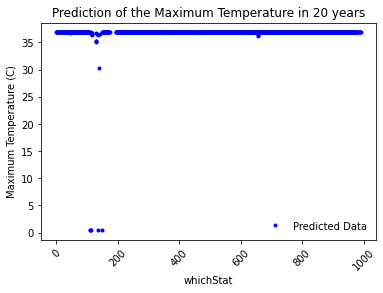

In [ ]:
#plot the predictions
fig,ax=plt.subplots()
plt.xticks(rotation=45)
predictions = np.array(predictions_Total)
ax.plot(whichStation_Now, predictions[:,0,0],'b.',label="Predicted Data")
ax.set_title("Prediction of the Maximum Temperature in 20 years")
ax.set_xlabel("whichStat")
ax.set_ylabel('Maximum Temperature (C)')
ax.legend()

**Disclaimer:**
I would like to apologise if parts of my notebook are unclear.
I would also like to explain that most of my code is just copy and paste from each other. I could've created functions to reduce the amount of code in this notebook. However, I would like to offer an explanation:
Given that I wanted to create a new model everytime but still save the one from before, I decided not to create a function for this. And given subtle differences between each use case scenario, I found it useless to create functions for most of my code anyway given that I would have had to create a new function for it anyway, functions have been kept to a minimum. That way also makes my code slightly more readable (I hope) and easier to debug. 
